In [1]:
# Predict abnormal patients with circle strain
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import ipywidgets
from ipywidgets import interact, interact_manual
import os

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

%matplotlib inline
%reload_ext autoreload
%autoreload 2
import ipywidgets
from ipywidgets import interact, interact_manual
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Evaluation import create_df_peak, get_pvals_uncorrected, get_pvals_corrected, cross_validate_f1, create_grid_search, ttest_per_keyframe, plot_strain_per_time, plot_report

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models


In [2]:
import sklearn
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier

def get_peak_rs_cs(df, per_phase=True):
    
    if per_phase:
        # by phase
        pcs = df[df['phase']==1]['our_cs'].values
        prs = df[df['phase']==1]['our_rs'].values
        
    else:
        # get the peak radial and circumferential strains from all time steps
        # min/max
        pcs = np.stack(df.groupby(['phase'])['our_cs'].apply(list).values).astype(np.float32)
        pcs = pcs.min(axis=0)
        prs = np.stack(df.groupby(['phase'])['our_rs'].apply(list).values).astype(np.float32)
        prs = prs.max(axis=0)
        
    return prs, pcs

def create_df_peak(df_strain_comp, df_strain_p2p):
    # peak radial and circumferential strain
    # for the composed and p2p strain values
    prs_com_p, pcs_com_p = get_peak_rs_cs(df_strain_comp, per_phase=True)
    prs_com_arg, pcs_com_arg = get_peak_rs_cs(df_strain_comp, per_phase=False)
    prs_p2p_p, pcs_p2p_p = get_peak_rs_cs(df_strain_p2p, per_phase=True)
    prs_p2p_arg, pcs_p2p_arg = get_peak_rs_cs(df_strain_p2p, per_phase=False)

    # 56 patients x 16 segments = 896 --> Peak strain per patient and segment
    df_peak = df_strain_comp[df_strain_comp['phase']==0].copy()

    # composed phase
    df_peak['prs_com_p']=prs_com_p
    df_peak['pcs_com_p']=pcs_com_p
    # composed arg-min/max
    df_peak['prs_com_arg']=prs_com_arg
    df_peak['pcs_com_arg']=pcs_com_arg
    # p2p phase
    df_peak['prs_p2p_p']=prs_p2p_p
    df_peak['pcs_p2p_p']=pcs_p2p_p
    # p2p arg-min/max
    df_peak['prs_p2p_arg']=prs_p2p_arg
    df_peak['pcs_p2p_arg']=pcs_p2p_arg
    # minor cleaning and dtype casting
    df_peak.drop(labels='phase', axis=1, inplace=True)
    df_peak.drop(labels='our_rs', axis=1, inplace=True)
    df_peak.drop(labels='our_cs', axis=1, inplace=True)
    df_peak.sort_values(by=['pat', 'aha'], inplace=True)
    df_peak = df_peak.apply(lambda x: x.astype(np.float32, errors='ignore'), axis=0)
    print(df_peak.shape)
    return df_peak
def cross_validate_f1(x,y):
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.rcParams.update({'font.size': 16})
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=5)
    cv = 5
    clfs = {}
    
    clfs['Logistic Regression'] = LogisticRegression(random_state=1, class_weight='balanced', max_iter=1000)
    clfs['Random Forest'] = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=500, random_state=1, class_weight='balanced')) #RandomForestClassifier(n_estimators=100, random_state=1, class_weight='balanced')
    clfs['Naive Bayes'] = GaussianNB()
    clfs['Scaled DecissionTree'] = make_pipeline(StandardScaler(), tree.DecisionTreeClassifier(class_weight='balanced'))
    clfs['KNN'] = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=2))
    clfs['Scaled SVC(poly)'] = make_pipeline(StandardScaler(), SVC(kernel='rbf',gamma='auto',class_weight='balanced', C=100))
    clfs['SVC(poly)'] = SVC(kernel='poly', gamma='auto',class_weight='balanced')
    # ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
    # NeighborhoodComponentsAnalysis(n_components=10, random_state=random_state),
 
    clfs['Ensemble'] = VotingClassifier(
        estimators=[
            
            ('lr', clfs['Logistic Regression']), 
            ('rf', clfs['Random Forest']), 
            ('gnb', clfs['Naive Bayes']),
            ('svc', clfs['Scaled SVC(poly)']),
            ('dt', clfs['Scaled DecissionTree'])
                   ],
        voting='hard')
    
    
    fig, ax = plt.subplots(1,8, figsize=(25,5))
    i = 0
    for label,clf in clfs.items():   
        y_pred = cross_val_predict(clf, x, y, cv=cv)
        scores = cross_validate(clf, x, y, scoring=['f1','recall', 'balanced_accuracy'], cv=cv)
        print('*'*10,label,'*'*10)
        print(scores['test_recall'])
        print("F1: %0.2f (+/- %0.2f) [%s]" % (scores['test_f1'].mean(), scores['test_f1'].std(), label))
        print("Recall: %0.2f (+/- %0.2f) [%s]" % (scores['test_recall'].mean(), scores['test_recall'].std(), label))
        print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores['test_balanced_accuracy'].mean(), scores['test_balanced_accuracy'].std(), label))
        ConfusionMatrixDisplay.from_predictions(y, y_pred, labels=[1,0],ax=ax[i], colorbar=False)
        ax[i].set_title(label)
        ax[i].xaxis.label.set_visible(False)
        ax[i].yaxis.label.set_visible(False)
        i = i + 1
    plt.show()
    
def create_grid_search():
    gammas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 'scale', 'auto']
    Cs = [0.1, 1, 5, 10, 20, 100, 1e3]
    kernels = ['linear', 
               'poly', 
               'rbf', 
               'sigmoid']
    weights = [None, 'balanced']
    degree = [2,3,4,5]
    n_estimators = [10,100,500,1000]
    depths = [None, 2, 5, 10, 20]

    penalties = ['l2']
    solvers = ['liblinear']

    scaler = [StandardScaler(), MinMaxScaler(), None]
    
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=5)

    [ 
     'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 
     'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 
     'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 
     'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose']

    svc_params = {'clf':(SVC(),), 
                  'clf__gamma': gammas, 
                  'clf__C': Cs, 
                  'clf__kernel': kernels, 
                  'clf__class_weight':weights,
                 'scaler': scaler}
    
    ################ ensemble #############
    clf1 = LogisticRegression(random_state=1, class_weight='balanced', penalty='l2',)
    clf2 = RandomForestClassifier(n_estimators=100, random_state=1, class_weight='balanced')
    clf4 = tree.DecisionTreeClassifier(class_weight='balanced')
    clf6 = SVC(kernel='poly',gamma='scale',class_weight='balanced', C=1, degree=3)
    
    eclf = VotingClassifier(
        estimators=[
            ('lr', clf1), 
            ('rf', clf2),
            ('svc', clf6)
                   ],
        voting='hard')
    
    ens_params = {'clf':(eclf,),
                 'scaler': scaler}
    
    
    rf_params = {'clf':(RandomForestClassifier( random_state=1, class_weight='balanced'),),
                'clf__n_estimators':n_estimators,
                 'clf__class_weight':weights,
                'scaler': scaler}
    lr_params = {'clf':(LogisticRegression(random_state=1, max_iter=10000,class_weight='balanced'),),
                 'clf__class_weight':weights,
                 'clf__penalty':penalties,
                 'clf__C': Cs,
                 'clf__solver': solvers,
                'scaler': scaler}
    et_params = {'clf': (ExtraTreesClassifier(n_estimators=250, max_depth=5, random_state=1),),
                 'clf__n_estimators':n_estimators,
                'scaler': scaler}
    dt_params = {'clf': (tree.DecisionTreeClassifier(class_weight='balanced'),),
                 'clf__class_weight':weights,
                 'clf__max_depth':depths,
                'scaler': scaler}
    params = [rf_params, svc_params, lr_params, et_params, dt_params]#, ens_params]


    pipeline = Pipeline( steps=[
        ('scaler',StandardScaler()), 
        ('clf', SVC())
    ])
    return GridSearchCV(estimator=pipeline, 
                        param_grid=params, 
                        scoring=['recall', 'accuracy', 'balanced_accuracy', 'average_precision','precision', 'f1', 'roc_auc'], 
                        refit='f1', # f1, balanced_accuracy
                        cv=skf,
                        n_jobs=16)
def plot_strain_per_time(df, title=None, method=None, hue='lge'):
    import seaborn
    sb.set_context('paper')
    sb.set(font_scale = 1.5)
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    
    # scale to % values
    df = df.copy()
    df['our_rs'] = df['our_rs'] * 100
    df['our_cs'] = df['our_cs'] * 100
    
    if method=='p2p':
        phases = ['ED-MS','MS-ES','ES-PF','PF-MD','MD-ED']
    elif method == 'comp':
        phases = ['ED-MS','ED-ES','ED-PF','ED-MD','ED-ED']
    elif method == 'window':
        phases = ['ED-w','MS-w','ES-w','PF-w','MD-w']
    ax1, ax2 = ax
    ax1 = sb.lineplot(x="phase", y="our_cs",
                      hue=hue,
                      err_style='band', legend=False,ax=ax1,
                 data=df)
    ax1 = sb.violinplot(x="phase", y="our_cs",inner='quart',
                   ax=ax1,
                 data=df, 
                        split=True,hue=hue
                       )
    ax1 = sb.stripplot(x="phase", y="our_cs",
                   ax=ax1,
                 data=df, 
                        hue=hue
                       )
    #_ = ax1.set_ylim((-25., 25))
    _ = ax1.set_xticks([0, 1, 2, 3, 4], minor=False)
    _ = ax1.set_xticklabels(phases)
    _ = ax1.legend(['neg','pos'])
    _ = ax1.set_xlabel('')
    _ = ax1.set_ylabel('Circumferential Strain (%)')

    ax2 = sb.lineplot(x="phase", y="our_rs",
                 hue=hue,
                      err_style='band', legend=False,ax=ax2,
                 data=df)
    ax2 = sb.violinplot(x="phase", y="our_rs",inner='quart',
                   ax=ax2,
                 data=df, 
                        split=True,hue=hue
                       )
    ax2 = sb.stripplot(x="phase", y="our_rs",
                   ax=ax2,
                 data=df, 
                        hue=hue
                       )

    #_ = ax2.set_ylim((-25, 150))
    _ = ax2.set_xticks([0, 1, 2, 3, 4], minor=False)
    _ = ax2.set_xticklabels(phases)
    _ = ax2.legend(['neg','pos'])
    _ = ax2.set_xlabel('')
    _ = ax2.set_ylabel('Radial Strain (%)')
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()
    return fig


def plot_report(clf, x, y, label=''):
    global hits, y_pred
    from sklearn.metrics import (precision_recall_curve,
                                 PrecisionRecallDisplay)
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import make_scorer
    def my_spec(gt,pred):
        tn, fp, fn, tp = confusion_matrix(gt, pred).ravel()
        specificity = tn / (tn+fp)
        return specificity
    def my_sens(gt,pred):
        tn, fp, fn, tp = confusion_matrix(gt, pred).ravel()
        sensitivity = tp / (tp+fn)
        return sensitivity
    #pats = np.stack(df_strain_comp.groupby(['pat','aha'])['pat'].apply(list).values)[0]
    spec_m = make_scorer(my_spec, greater_is_better=True)
    sens_m = make_scorer(my_sens, greater_is_better=True)
    roc_m = make_scorer(sklearn.metrics.roc_auc_score, greater_is_better=True )
    rec_m = make_scorer(sklearn.metrics.recall_score, greater_is_better=True )
    acc_m = make_scorer(sklearn.metrics.accuracy_score, greater_is_better=True)
    bacc_m = make_scorer(sklearn.metrics.balanced_accuracy_score, greater_is_better=True)
    prec_m = make_scorer(sklearn.metrics.precision_score, greater_is_better=True)
    f1_m = make_scorer(sklearn.metrics.f1_score, greater_is_better=True)
    

    skf = StratifiedKFold(n_splits=5)
    y_pred = cross_val_predict(clf, x, y, cv=skf)
    hits = y_pred==y
    scores2 = cross_validate(clf, x, y, scoring={'specificity':spec_m, 'sensitivity': sens_m, 'roc': roc_m, 'recall': rec_m, 
                                                 'accuracy': acc_m, 'balanced_accuracy': bacc_m, 'precision': prec_m, 'f1':f1_m}, cv=skf)
    print("Specifity: {:0.2f} (+/- {:0.2f})".format(scores2['test_specificity'].mean(), scores2['test_specificity'].std(), ""))
    print("Sensitivity: {:0.2f} (+/- {:0.2f})".format(scores2['test_sensitivity'].mean(), scores2['test_sensitivity'].std(), ""))
    print('params: {}'.format(label))
    print("Recall: {:0.2f} (+/- {:0.2f})".format(scores2['test_recall'].mean(), scores2['test_recall'].std()))
    print("Accuracy: {:0.2f} (+/- {:0.2f})".format(scores2['test_accuracy'].mean(), scores2['test_accuracy'].std()))
    print("Precision: {:0.2f} (+/- {:0.2f})".format(scores2['test_precision'].mean(), scores2['test_precision'].std()))
    print("Balanced Accuracy: {:0.2f} (+/- {:0.2f})".format(scores2['test_balanced_accuracy'].mean(), scores2['test_balanced_accuracy'].std()))
    print("F1: {:0.2f} (+/- {:0.2f})".format(scores2['test_f1'].mean(), scores2['test_f1'].std()))
    print("AUC: {:0.2f} (+/- {:0.2f})".format(scores2['test_roc'].mean(), scores2['test_roc'].std()))
    disp = ConfusionMatrixDisplay.from_predictions(y, y_pred,labels=[1,0], display_labels=['positive','negative'],colorbar=True)
    disp = PrecisionRecallDisplay.from_predictions(y,y_pred)

# Load RS and CS strain from Circle

In [2]:
# load circle strain
df_circ = pd.read_excel('/mnt/ssd2/data/dmd_combined_isotrop/02_imported_4D_unfiltered/metadata/cvi_DMD_t_82.xlsx', sheet_name='circumferential')
print(df_circ.shape)
# load circle strain
df_radial = pd.read_excel('/mnt/ssd2/data/dmd_combined_isotrop/02_imported_4D_unfiltered/metadata/cvi_DMD_t_82.xlsx', sheet_name='radial')
print(df_radial.shape)
print(df_radial.head())

# 57 patients x 16 segments x 30 timesteps = 27360
df_radial_melt = pd.melt(df_radial, id_vars=['pat', 'aha'], var_name='frame', value_name='radial_strain')
df_radial_melt.head()

df_circ_melt = pd.melt(df_circ, id_vars=['pat', 'aha'], var_name='frame', value_name='circ_strain')
df_melt = pd.concat([df_radial_melt,df_circ_melt['circ_strain']],axis=1)

(1984, 32)
(1984, 32)
            pat  aha      0      1      2       3       4       5       6  \
0  aea_20220314    1  0.867  4.069  3.537   2.772   2.099   0.903   2.500   
1  aea_20220314    2  1.206  4.706  7.123  12.066  17.099  20.001  24.471   
2  aea_20220314    3  1.425  1.266  0.992   1.262   2.382   5.438   7.839   
3  aea_20220314    4 -0.165  0.411  2.267   1.326   0.938   0.166  -3.828   
4  aea_20220314    5 -1.798 -2.474 -4.337  -3.386   4.168  13.057  23.275   

        7  ...      20      21     22     23     24     25     26     27   28  \
0   2.848  ...  -1.260  -2.403 -3.591 -3.701 -3.962 -3.836 -1.138  0.143  0.0   
1  30.571  ...  23.480  20.195  9.393  5.299  2.278  1.468 -0.146 -1.393  0.0   
2   9.942  ...   9.681   5.575  8.882  8.682  9.234  6.274  4.317  2.053  0.0   
3  -4.822  ...   0.309   0.074 -4.408 -4.088 -3.231 -1.723 -1.952 -0.432  0.0   
4  24.132  ...  14.539  11.317  7.976  6.552  8.868  7.717  6.104  2.265  0.0   

      29  
0  0.660  
1  0.4

In [3]:
len(df_radial.pat.unique())

124

# slice the strain values at the cardiac phases

In [4]:
df_phases = pd.read_csv('/mnt/ssd2/data/dmd_combined_isotrop/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase.csv')
df_phases['patient'] = df_phases['patient'].str.replace('\n','') # remove new line symbol
df_radial_p = pd.merge(left=df_radial, right=df_phases[['patient','ED#', 'MS#', 'ES#', 'PF#', 'MD#']], how='inner', left_on='pat', right_on='patient')
df_circ_p = pd.merge(left=df_circ, right=df_phases[['patient','ED#', 'MS#', 'ES#', 'PF#', 'MD#']], how='inner', left_on='pat', right_on='patient')
df_radial_p.head()

pat  aha      0      1      2       3       4       5       6  \
0  aea_20220314    1  0.867  4.069  3.537   2.772   2.099   0.903   2.500   
1  aea_20220314    2  1.206  4.706  7.123  12.066  17.099  20.001  24.471   
2  aea_20220314    3  1.425  1.266  0.992   1.262   2.382   5.438   7.839   
3  aea_20220314    4 -0.165  0.411  2.267   1.326   0.938   0.166  -3.828   
4  aea_20220314    5 -1.798 -2.474 -4.337  -3.386   4.168  13.057  23.275   

        7  ...     26     27   28     29       patient  ED#  MS#  ES#  PF#  \
0   2.848  ... -1.138  0.143  0.0  0.660  aea_20220314   28    6   12   18   
1  30.571  ... -0.146 -1.393  0.0  0.470  aea_20220314   28    6   12   18   
2   9.942  ...  4.317  2.053  0.0  0.324  aea_20220314   28    6   12   18   
3  -4.822  ... -1.952 -0.432  0.0 -0.142  aea_20220314   28    6   12   18   
4  24.132  ...  6.104  2.265  0.0 -2.066  aea_20220314   28    6   12   18   

   MD#  
0   26  
1   26  
2   26  
3   26  
4   26  

[5 rows x 38 columns]

In [5]:
df_radial_p.isna().any()

pat        False
aha        False
0          False
1          False
2          False
3          False
4          False
5          False
6          False
7          False
8          False
9          False
10         False
11         False
12         False
13         False
14         False
15         False
16         False
17         False
18         False
19         False
20         False
21         False
22         False
23         False
24         False
25         False
26         False
27         False
28         False
29         False
patient    False
ED#        False
MS#        False
ES#        False
PF#        False
MD#        False
dtype: bool

In [6]:
phases = ['ED#', 'MS#', 'ES#', 'PF#', 'MD#']
p = df_radial_p.iloc[0,:]
p[p[phases]-1]

27    0.143
5     0.903
11    4.614
17   -1.737
25   -3.836
Name: 0, dtype: object

In [7]:
df_radial_sliced = pd.DataFrame(columns=['pat', 'aha', 0,1,2,3,4])
df_radial_sliced['pat'] = df_radial_p['pat']
df_radial_sliced['aha'] = df_radial_p['aha']
df_radial_sliced[0] = df_radial_p.apply(lambda x : x[x['ED#']], axis=1)
df_radial_sliced[1] = df_radial_p.apply(lambda x : x[x['MS#']], axis=1)
df_radial_sliced[2] = df_radial_p.apply(lambda x : x[x['ES#']], axis=1)
df_radial_sliced[3] = df_radial_p.apply(lambda x : x[x['PF#']], axis=1)
df_radial_sliced[4] = df_radial_p.apply(lambda x : x[x['MD#']], axis=1)

df_circ_sliced = pd.DataFrame(columns=['pat', 'aha', 0,1,2,3,4])
df_circ_sliced['pat'] = df_circ_p['pat']
df_circ_sliced['aha'] = df_circ_p['aha']
df_circ_sliced[0] = df_circ_p.apply(lambda x : x[x['ED#']], axis=1)
df_circ_sliced[1] = df_circ_p.apply(lambda x : x[x['MS#']], axis=1)
df_circ_sliced[2] = df_circ_p.apply(lambda x : x[x['ES#']], axis=1)
df_circ_sliced[3] = df_circ_p.apply(lambda x : x[x['PF#']], axis=1)
df_circ_sliced[4] = df_circ_p.apply(lambda x : x[x['MD#']], axis=1)

# 57 patients x 16 segments x 30 timesteps = 27360
df_radial_melt = pd.melt(df_radial_sliced, id_vars=['pat', 'aha'], var_name='frame', value_name='radial_strain')
df_radial_melt.head()

df_circ_melt = pd.melt(df_circ_sliced, id_vars=['pat', 'aha'], var_name='frame', value_name='circ_strain')
df_melt = pd.concat([df_radial_melt,df_circ_melt['circ_strain']],axis=1)

In [25]:
df_circ_sliced

pat  aha      0       1       2       3      4
0     aea_20220314    1  0.000   0.138  -3.096   5.201  1.196
1     aea_20220314    2  0.000 -15.437 -17.574 -18.166  0.261
2     aea_20220314    3  0.000  -5.182 -11.763  -7.994 -3.845
3     aea_20220314    4  0.000   6.038   7.887   7.754  2.138
4     aea_20220314    5  0.000 -12.750 -22.944 -18.394 -5.235
...            ...  ...    ...     ...     ...     ...    ...
1963   wr_20170905   12 -1.333 -14.263 -20.499 -13.909 -7.516
1964   wr_20170905   13 -1.808 -10.313 -17.881 -14.772 -1.070
1965   wr_20170905   14 -3.530 -11.246 -22.540 -10.567 -2.489
1966   wr_20170905   15 -0.500  -3.534  -7.153  -9.619 -3.373
1967   wr_20170905   16  3.019  -7.478 -15.683 -12.740 -5.725

[1968 rows x 7 columns]

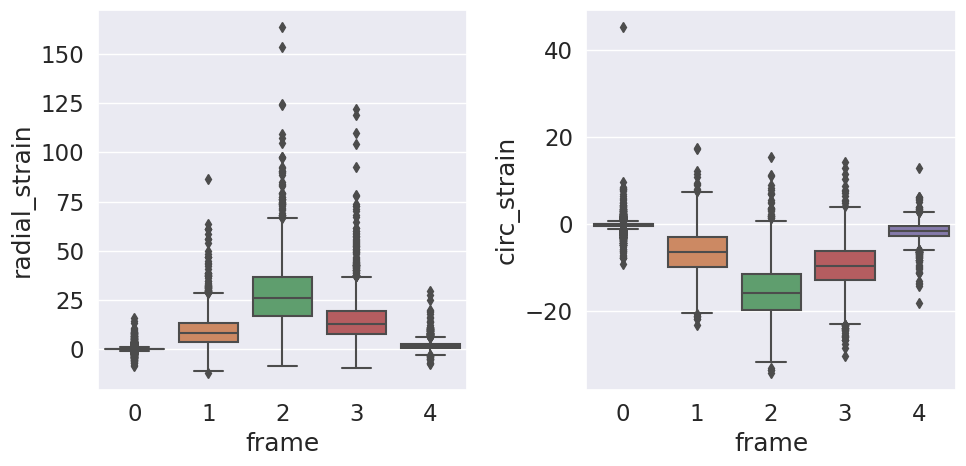

In [9]:
sb.set_context('paper')
sb.set(font_scale = 1.5)
fig, (ax, ax1) = plt.subplots(1,2,figsize=(10,5))
sb.boxplot(x="frame", y="radial_strain",
                 data=df_melt,
              ax=ax)

sb.boxplot(x="frame", y="circ_strain",
                 data=df_melt,
              ax=ax1)
plt.tight_layout()
plt.show()

In [10]:
# load meta
path_to_df_meta = '/mnt/ssd2/data/dmd_combined_isotrop/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase.csv'
df_meta = pd.read_csv(path_to_df_meta)
df_meta = df_meta.loc[:, ~df_meta.columns.str.contains('^Unnamed')]
df_meta['patient'] = df_meta['patient'].str.lower().str.ljust(11, '0')
df_meta.head()

ED#  MS#  ES#  PF#  MD#       patient           pat   Age Gender  Weight  \
0   28    6   12   18   26  aea_20220314  aea_20220314  None   None    55.9   
1   28    5   12   18   25  aja_20230331  aja_20230331  None   None    31.0   
2   29    1   10   19   21  ajs_20200519  ajs_20200519  None   None    41.2   
3   29    5   11   18   25  baj_20210528  baj_20210528  None   None    34.0   
4   29    4    8   12   27   ba_20201019   ba_20201019  None   None    64.5   

   ...  Wheelchair Ambulatory Steroid Use Any Med Use ACE-I   ARB   MRA    BB  \
0  ...        None       None        None        None  None  None  None  None   
1  ...        None       None        None        None  None  None  None  None   
2  ...        None       None        None        None  None  None  None  None   
3  ...        None       None        None        None  None  None  None  None   
4  ...        None       None        None        None  None  None  None  None   

    soa        lgepos  
0  None          None  
1  None          5,11  
2  None  5,6,11,13,16  
3  None         11,12  
4  None          None  

[5 rows x 38 columns]

In [11]:
len(df_melt.pat.unique())

123

In [12]:
df_merged = pd.merge(left=df_melt, right=df_meta, how='inner', left_on='pat', right_on='patient')
df_merged['target'] = df_merged['LGE present']
df_merged['pat'] = df_merged['pat_x']
df_merged.head()

pat_x  aha frame  radial_strain  circ_strain  ED#  MS#  ES#  PF#  \
0  aea_20220314    1     0            0.0          0.0   28    6   12   18   
1  aea_20220314    2     0            0.0          0.0   28    6   12   18   
2  aea_20220314    3     0            0.0          0.0   28    6   12   18   
3  aea_20220314    4     0            0.0          0.0   28    6   12   18   
4  aea_20220314    5     0            0.0          0.0   28    6   12   18   

   MD#  ... Steroid Use Any Med Use ACE-I   ARB   MRA    BB   soa lgepos  \
0   26  ...        None        None  None  None  None  None  None   None   
1   26  ...        None        None  None  None  None  None  None   None   
2   26  ...        None        None  None  None  None  None  None   None   
3   26  ...        None        None  None  None  None  None  None   None   
4   26  ...        None        None  None  None  None  None  None   None   

  target           pat  
0      N  aea_20220314  
1      N  aea_20220314  
2      N  aea_20220314  
3      N  aea_20220314  
4      N  aea_20220314  

[5 rows x 45 columns]

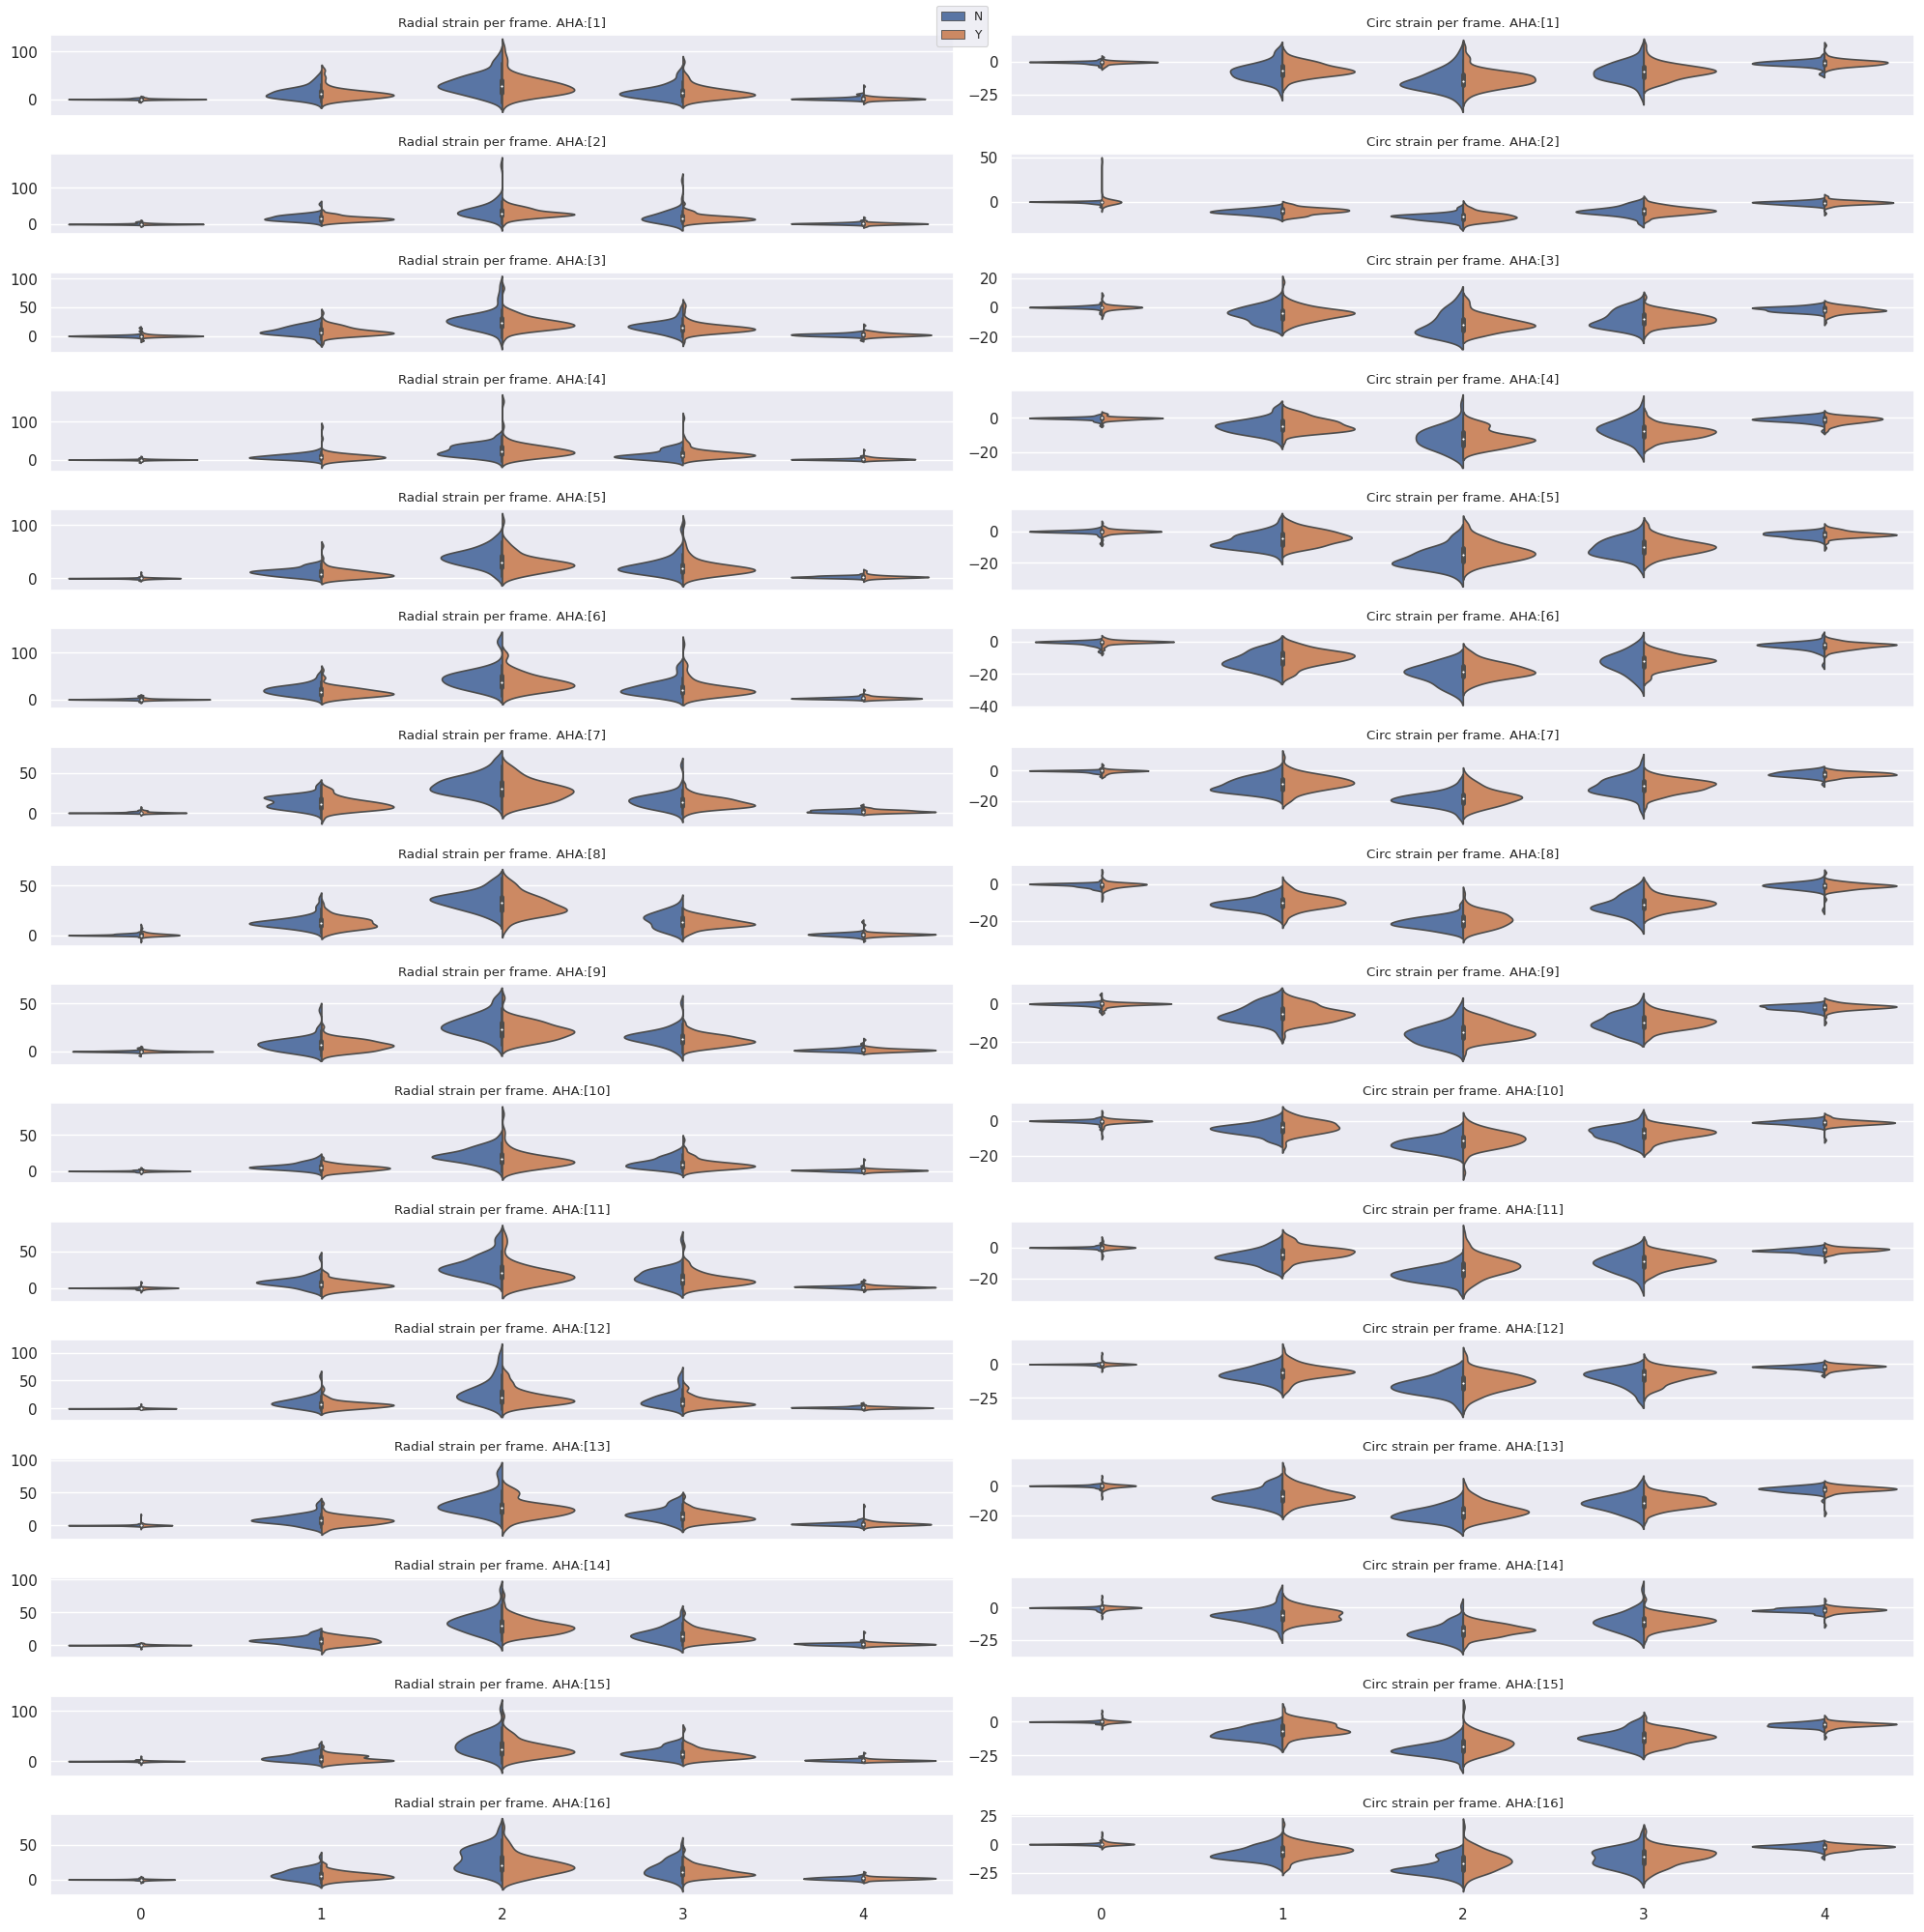

In [13]:
def plot_strain(df, segments=[1], ax=None, ax1=None, show_xlabel=False):
    sb.set_context('paper')
    #sb.set(font_scale = 1.5)
    if ax is None:
        fig, (ax, ax1) = plt.subplots(1,2,figsize=(20,4))
    ax.set_title('Radial strain per frame. AHA:{}'.format(segments))
    ax1.set_title('Circ strain per frame. AHA:{}'.format(segments))
    g1 = sb.violinplot(x="frame", y='radial_strain',
                     data=df[df['aha'].isin(segments)],
                  ax=ax,
                 hue='target',
                 split=True, legend=False)
    g2 = sb.violinplot(x="frame", y='circ_strain',
                     data=df[df['aha'].isin(segments)],
                  ax=ax1,
                 hue='target',
                 split=True)
    
    if show_xlabel:
        pass
    else:
        g1.set(ylabel=None)
        g2.set(ylabel=None)
        g1.set(xlabel=None)
        g2.set(xlabel=None)
        g1.legend([],[],frameon=False)
        g2.legend([],[],frameon=False)
        #g2.set(xticklabels=[])
        #g1.set(xticklabels=[])
    
    
seg_of_interest = 16
sb.set_context('paper')
sb.set(font_scale = 1)
fig, axes = plt.subplots(seg_of_interest,2,figsize=(20,20), sharex=True)
_ = [plot_strain(df_merged, segments=[i], ax=axes[i-1,0], ax1=axes[i-1,1], show_xlabel=i==seg_of_interest+1) for i in range(1,1 + seg_of_interest)]
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.tight_layout()
plt.savefig('/mnt/ssd2/jcmr2023/circle/strain138@frame_per_segment.png')
plt.show()

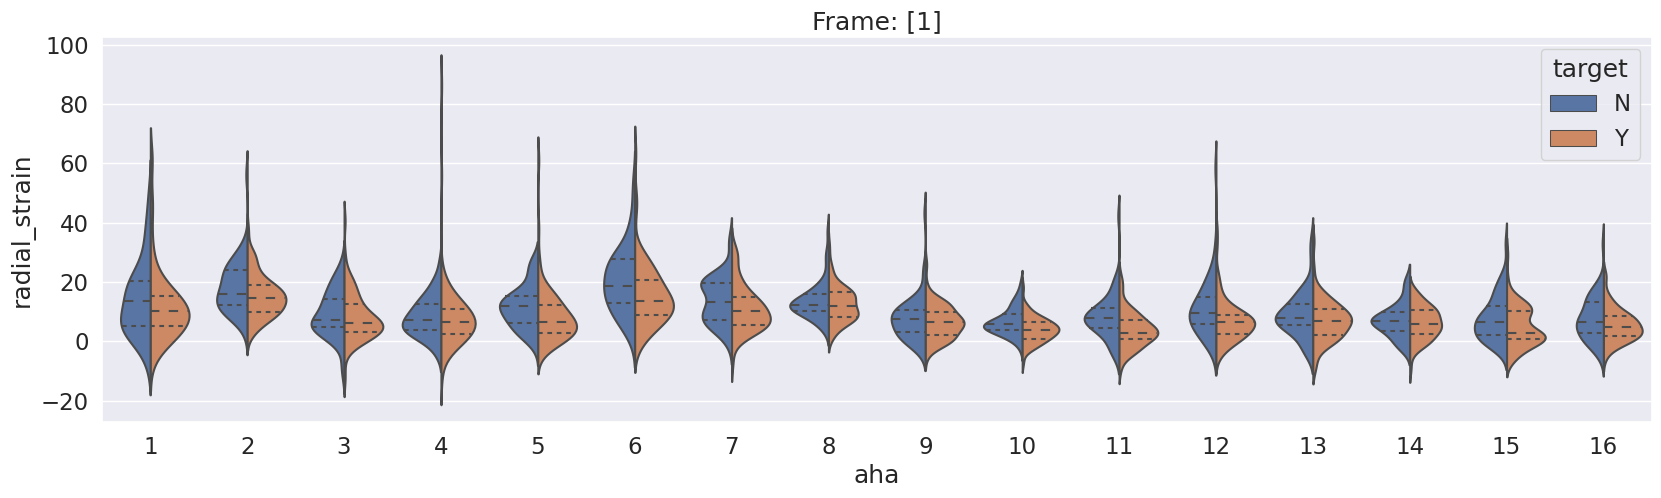

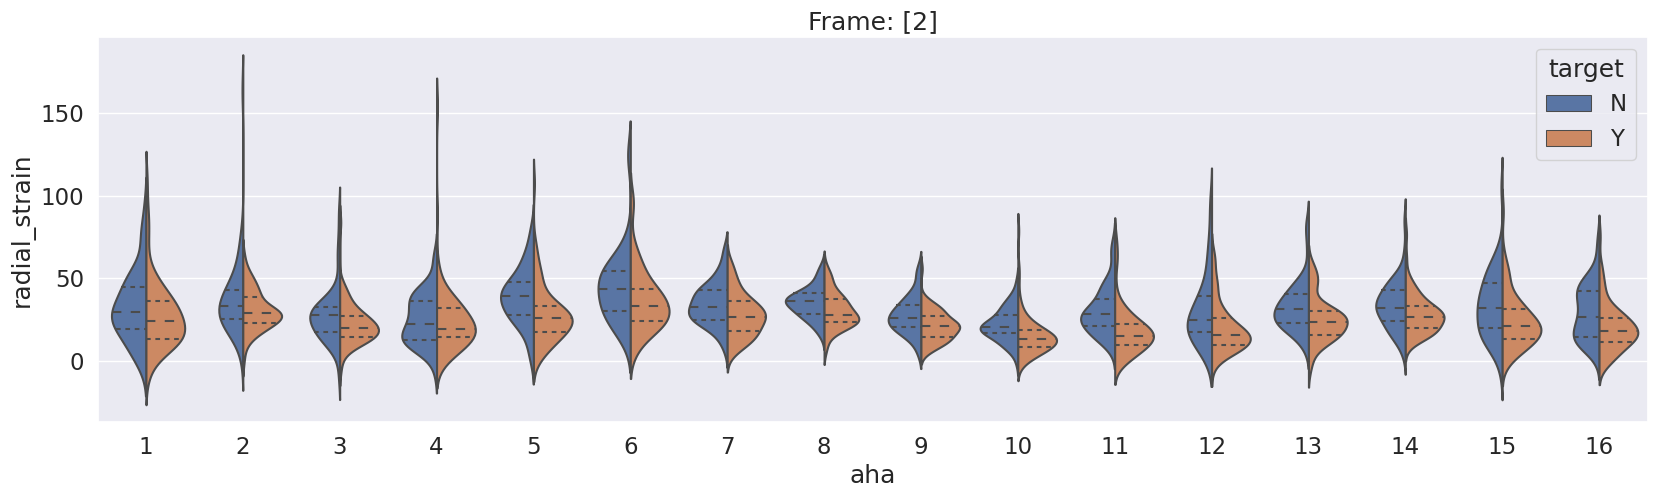

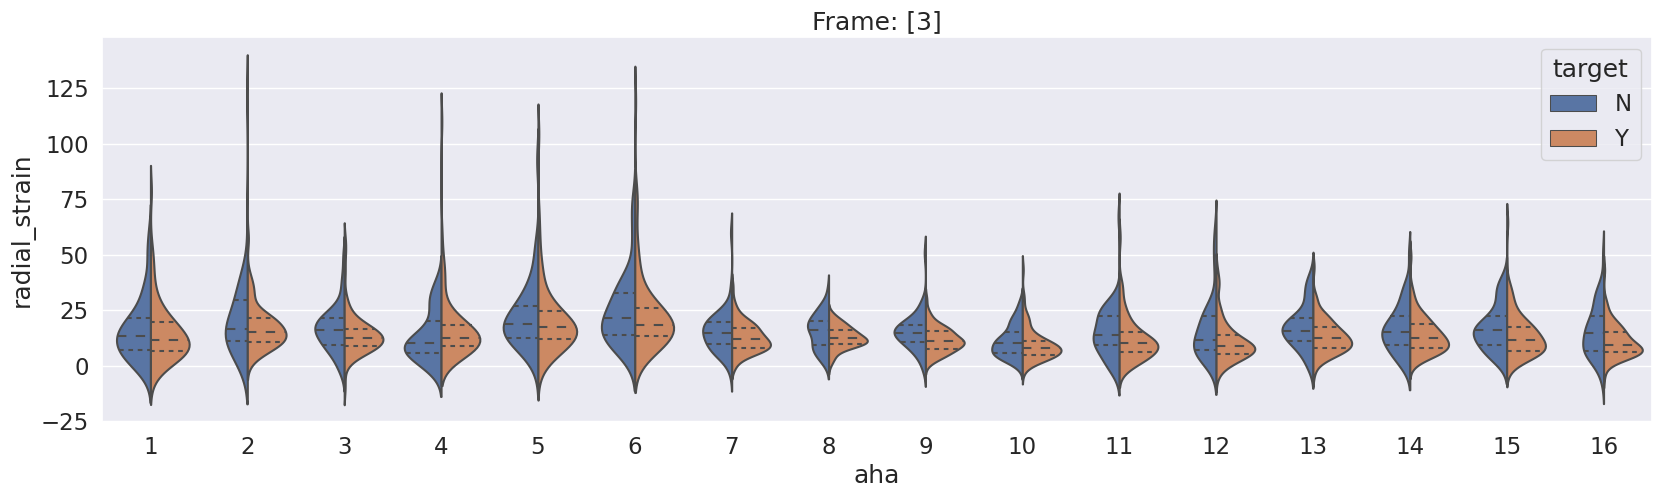

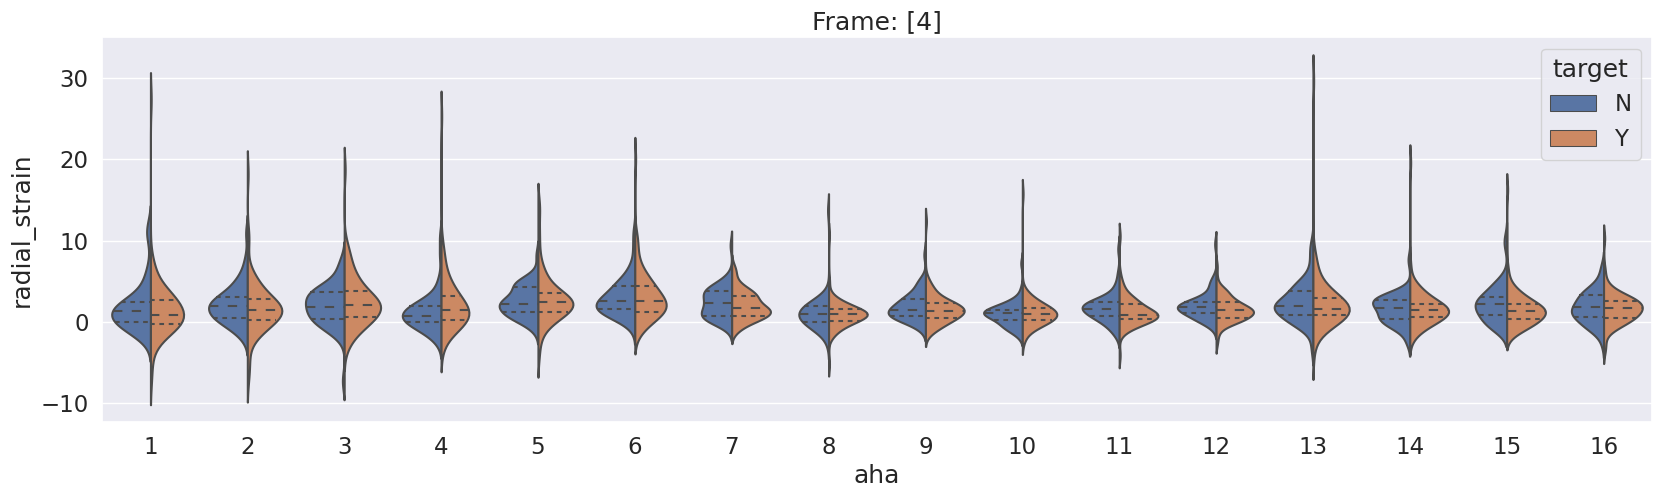

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_101493/1250327862.py", line 12, in <cell line: 12>
    _ = [plot_strain(df_merged, segments=[i]) for i in range(1,30)]
  File "/tmp/ipykernel_101493/1250327862.py", line 12, in <listcomp>
    _ = [plot_strain(df_merged, segments=[i]) for i in range(1,30)]
  File "/tmp/ipykernel_101493/1250327862.py", line 6, in plot_strain
    sb.violinplot(x="aha", y="radial_strain",inner='quart',
  File "/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/seaborn/_decorators.py", line 46, in inner_f
    return f(**kwargs)
  File "/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/seaborn/categorical.py", line 2397, in violinplot
    plotter = _ViolinPlotter(x, y, hue, data, order, hue_order,
  File "/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-pack

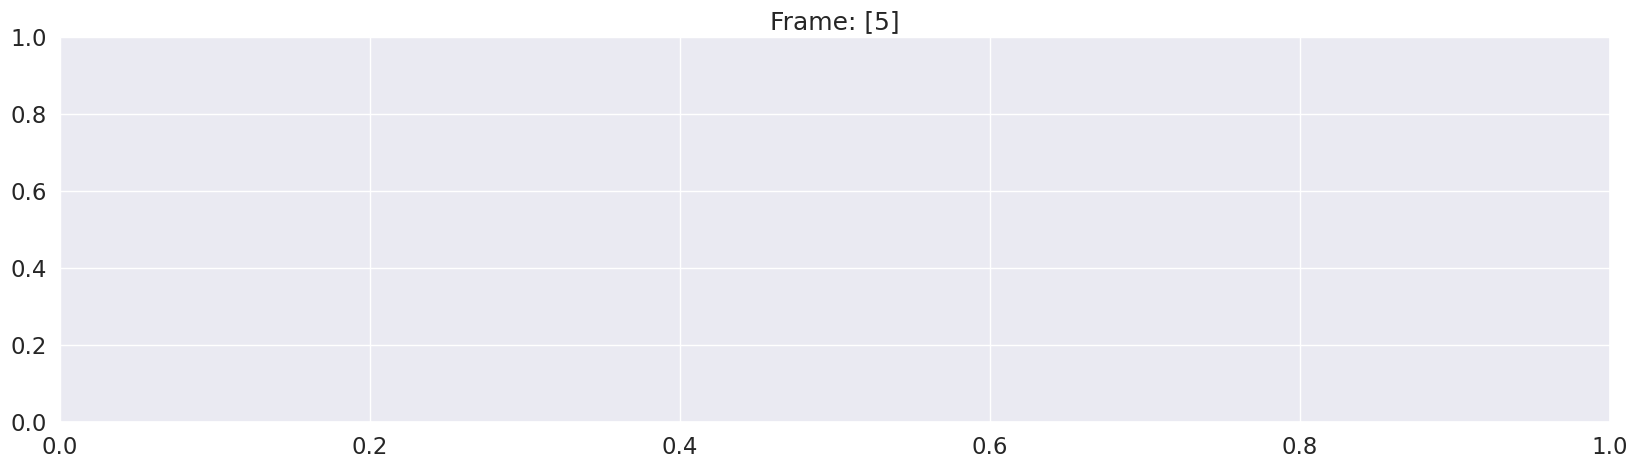

In [14]:
def plot_strain(df, segments=[1]):
    sb.set_context('paper')
    sb.set(font_scale = 1.5)
    fig, ax = plt.subplots(1,1,figsize=(20,5))
    plt.title('Frame: {}'.format(segments))
    sb.violinplot(x="aha", y="radial_strain",inner='quart',
                     data=df[df['frame'].isin(segments)],
                  ax=ax,
                 hue='target',
                 split=True
                 );plt.show()
_ = [plot_strain(df_merged, segments=[i]) for i in range(1,30)]

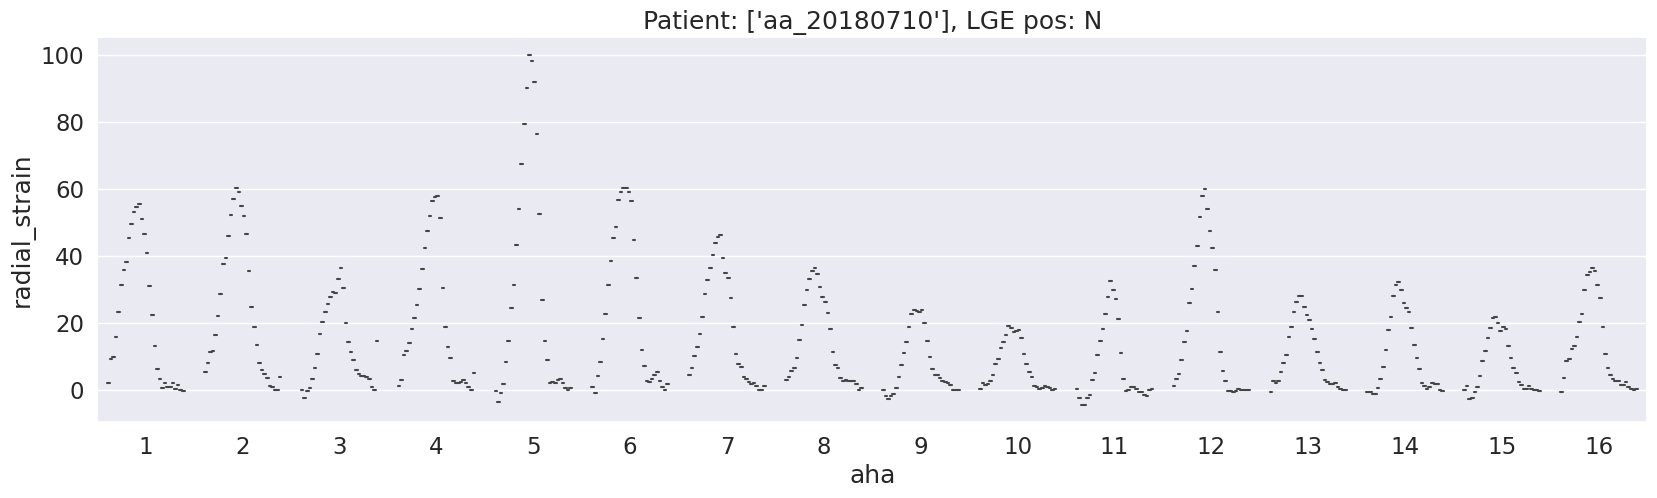

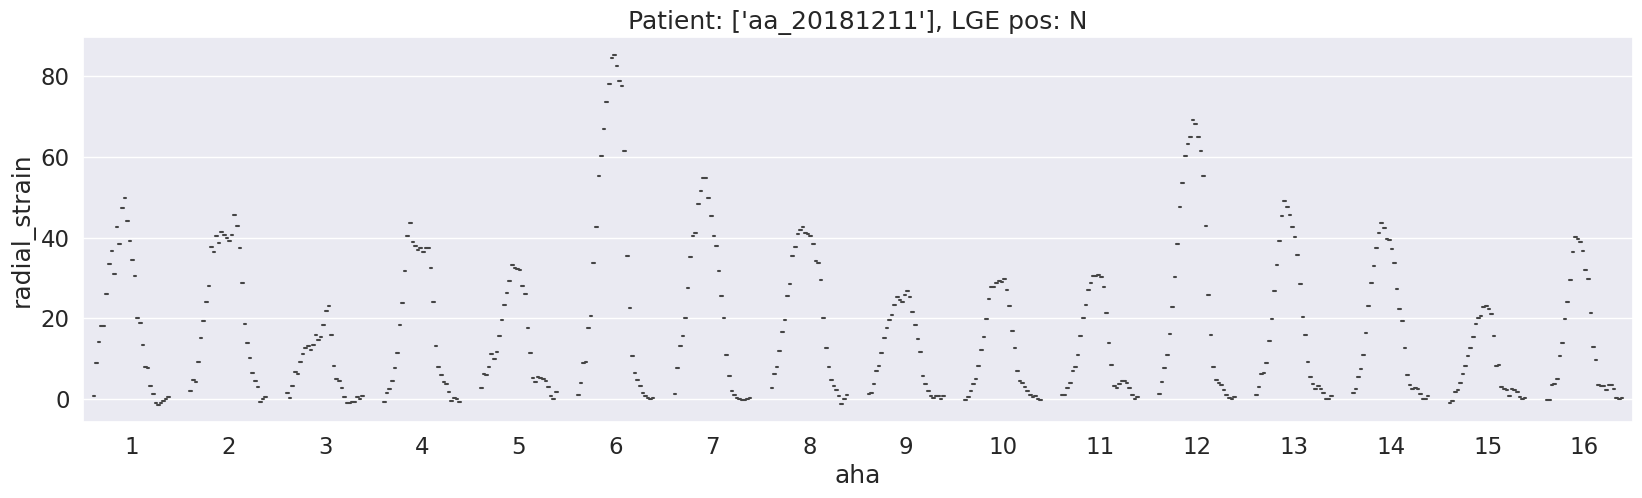

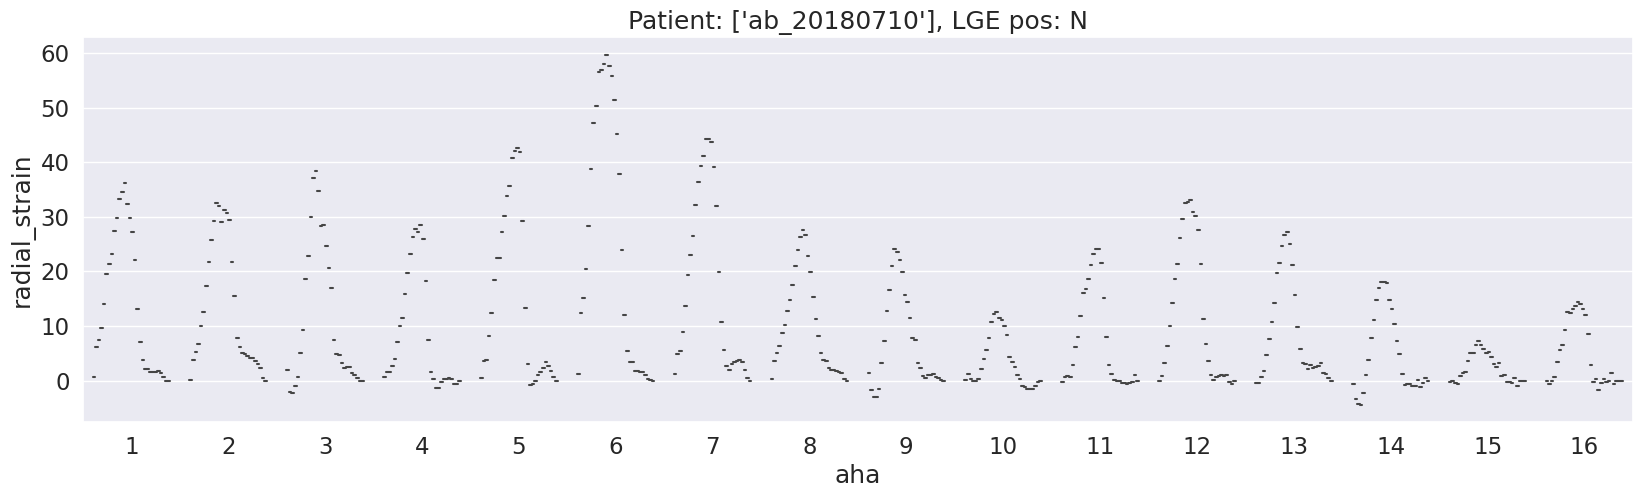

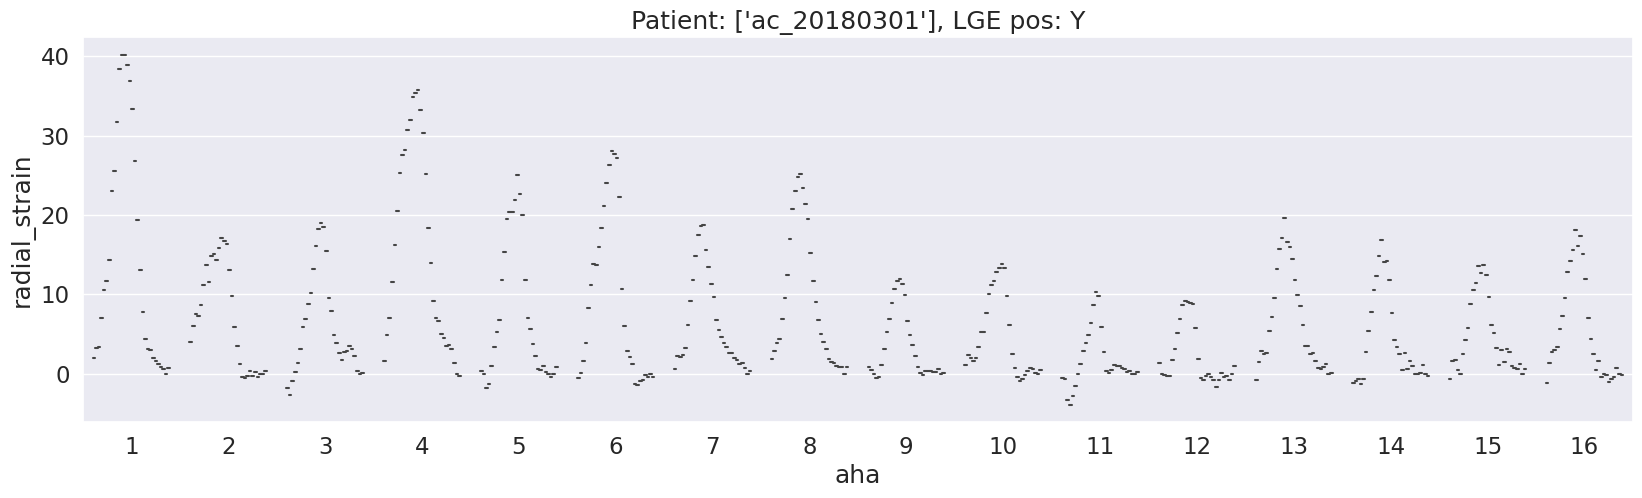

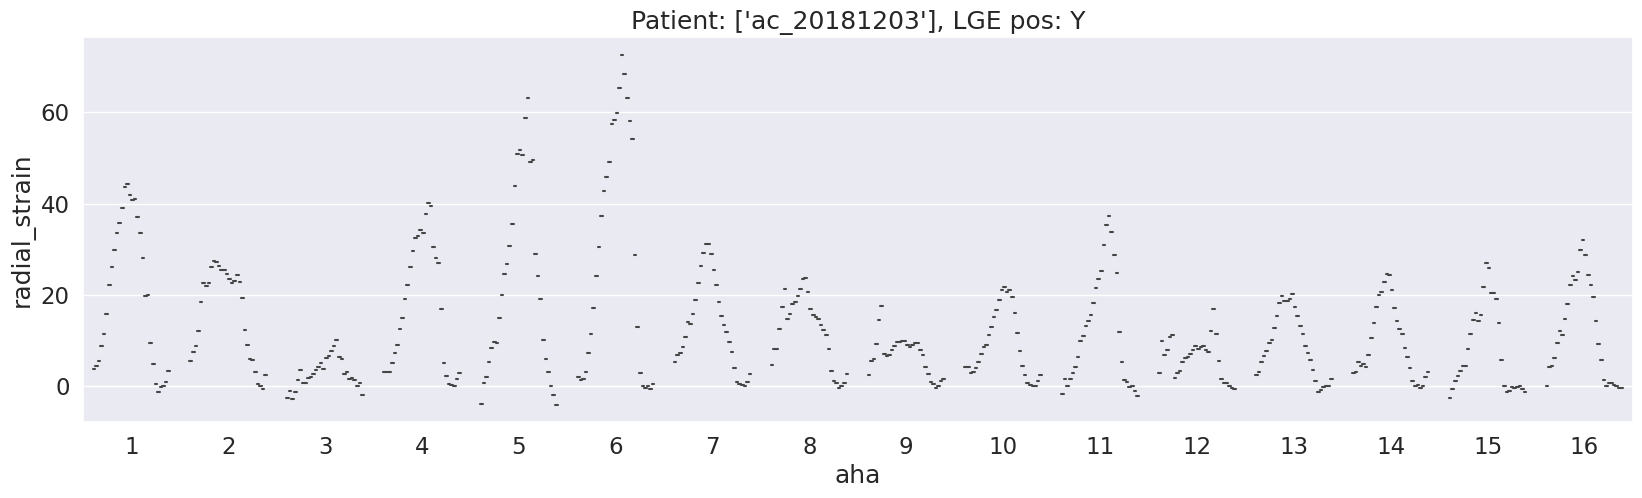

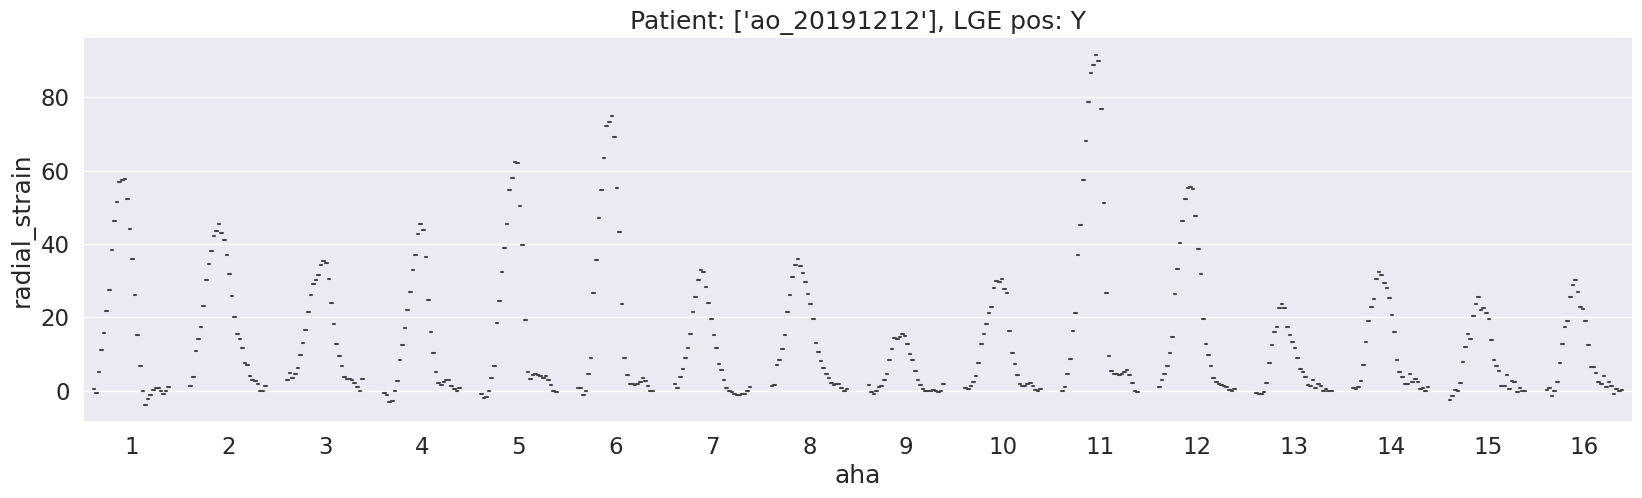

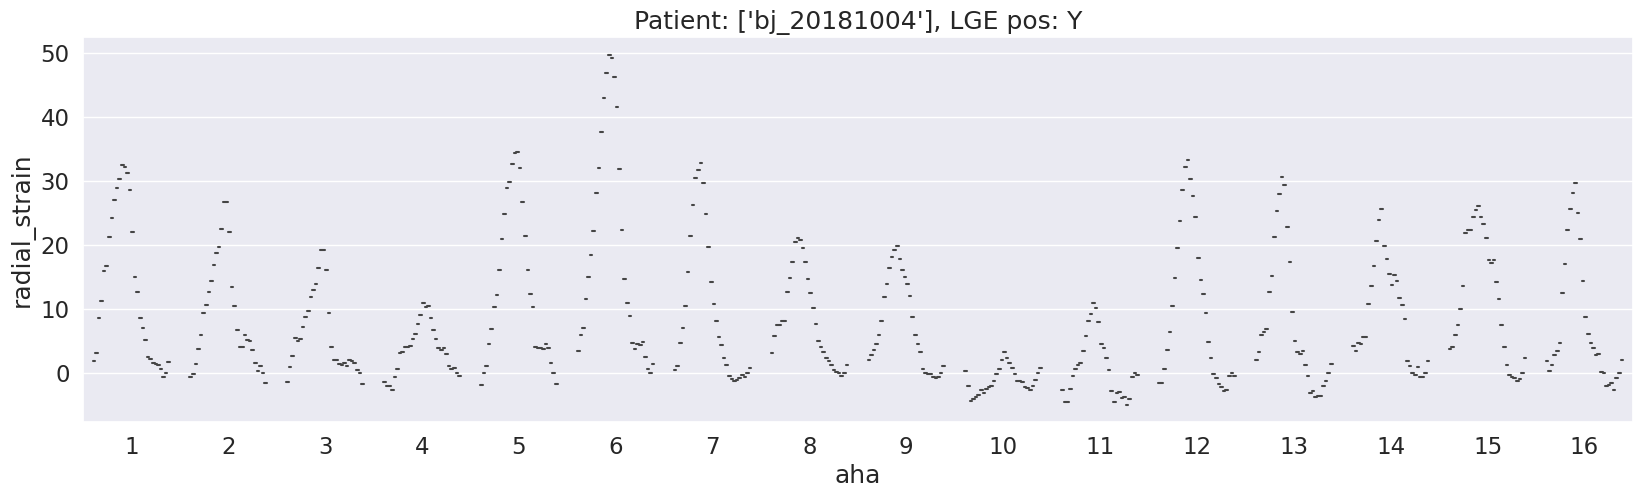

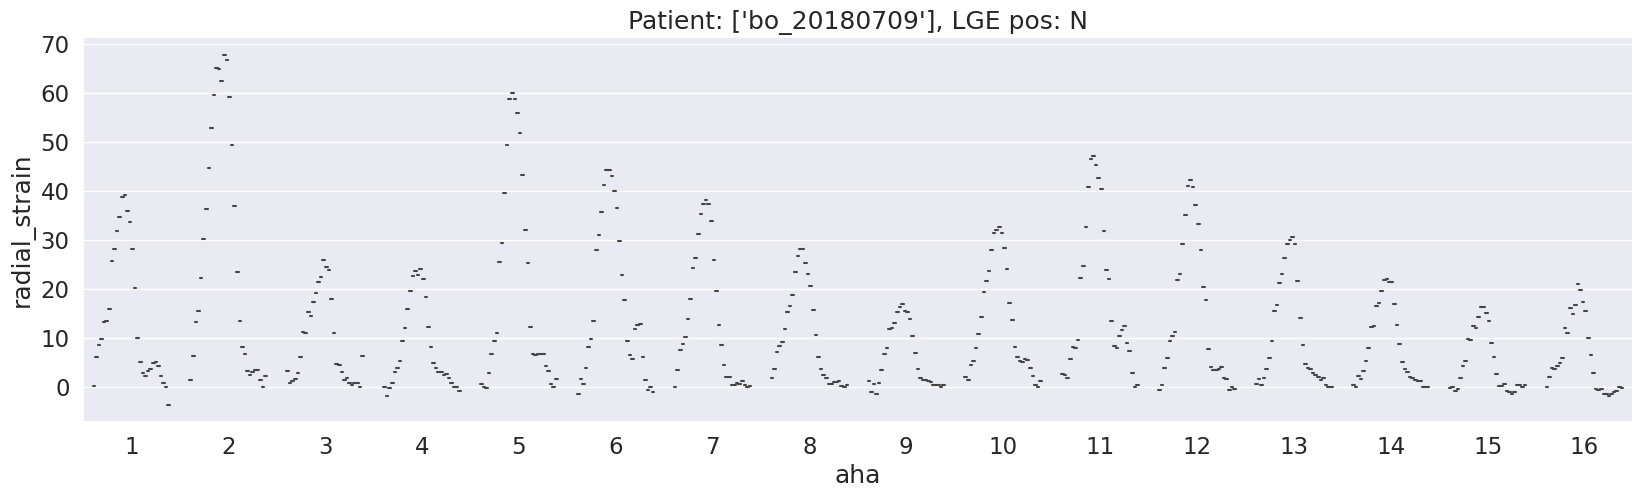

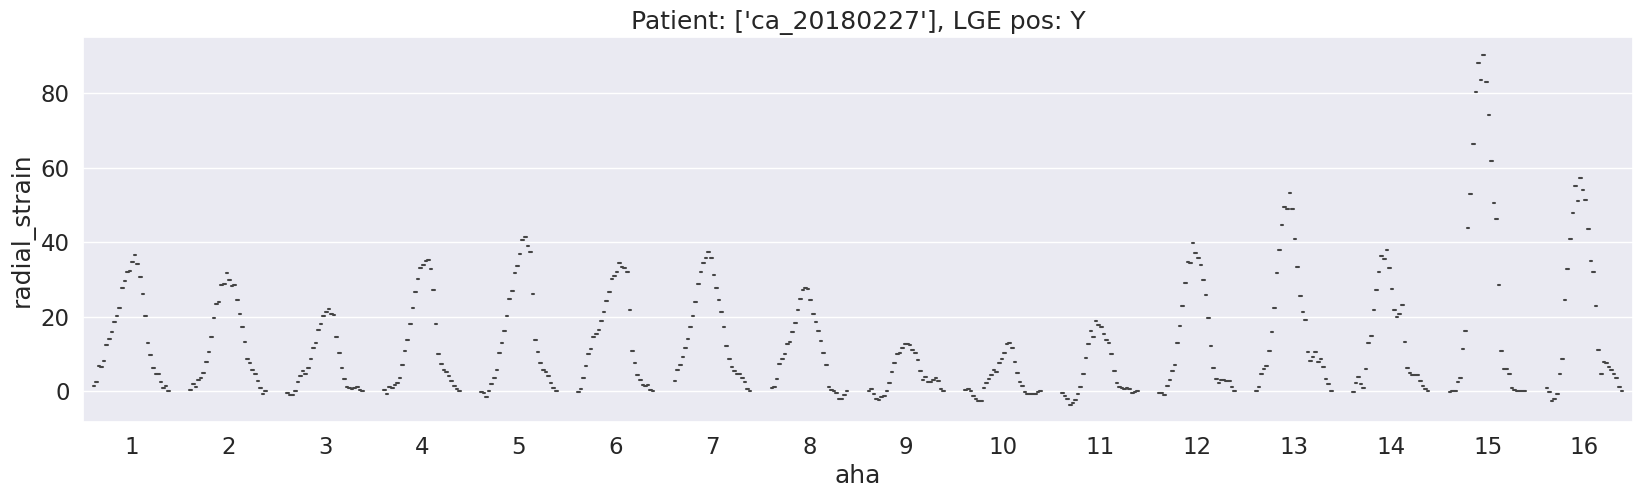

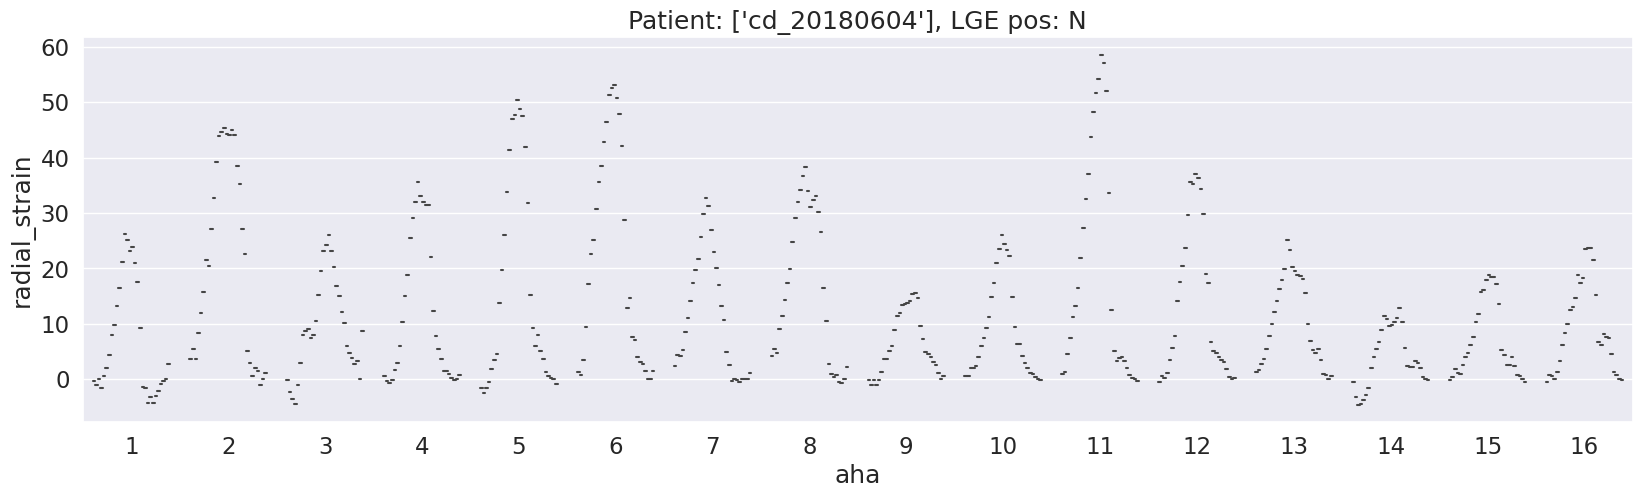

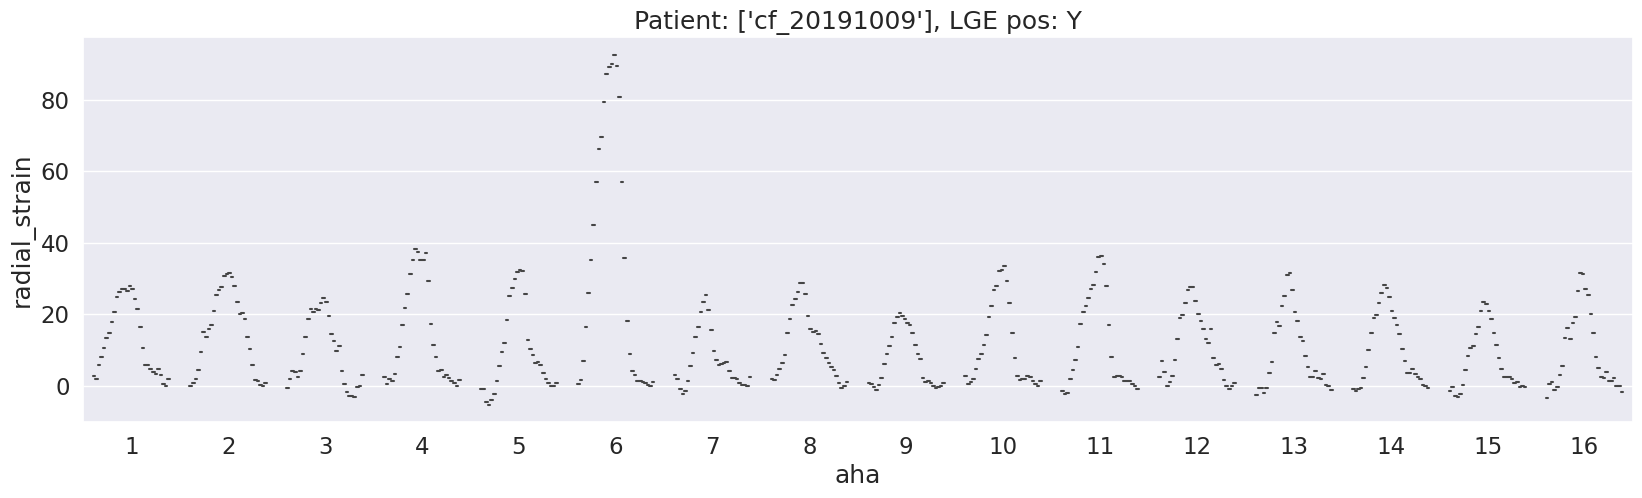

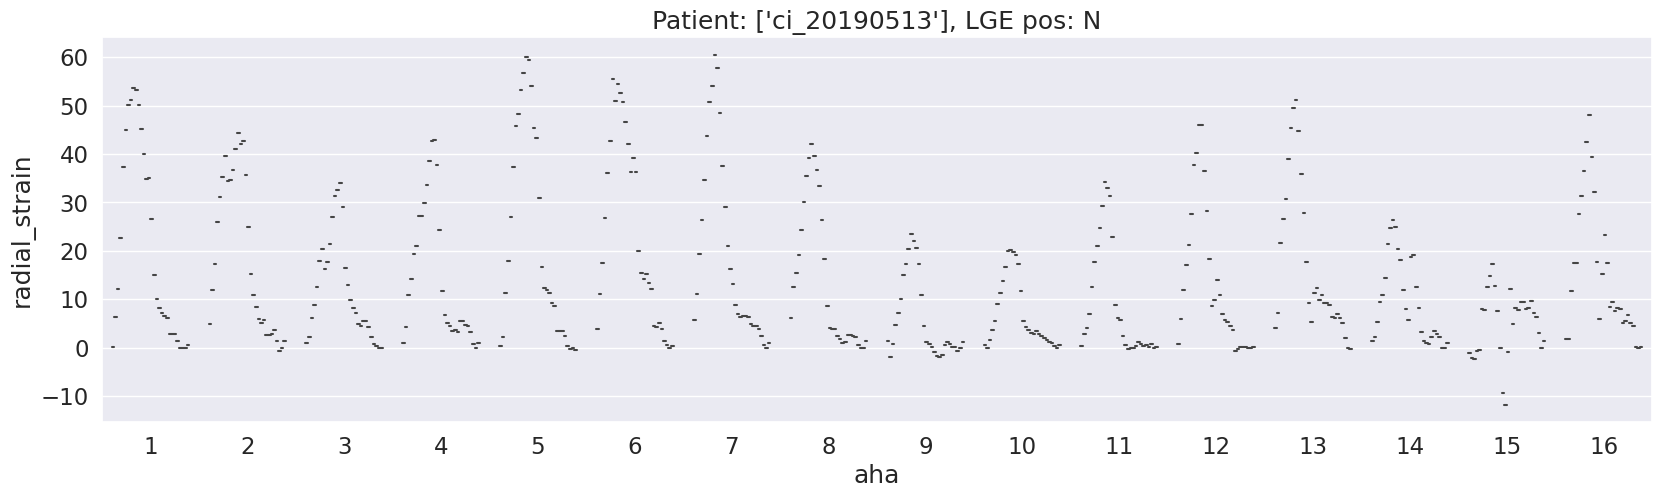

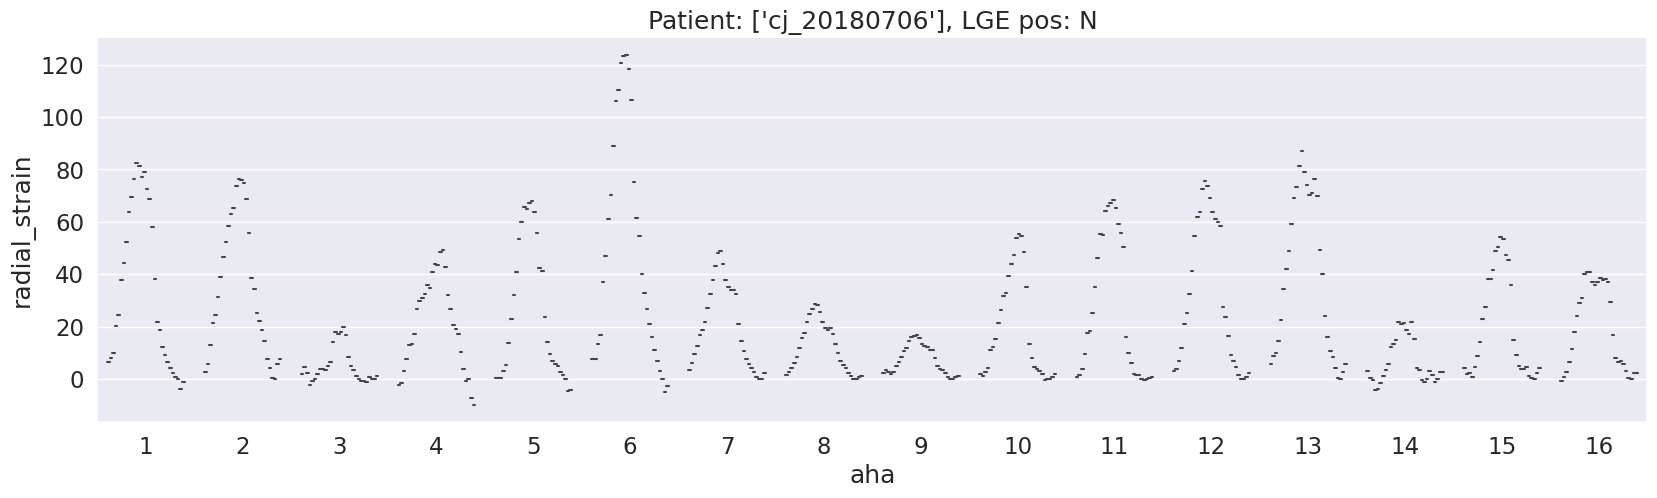

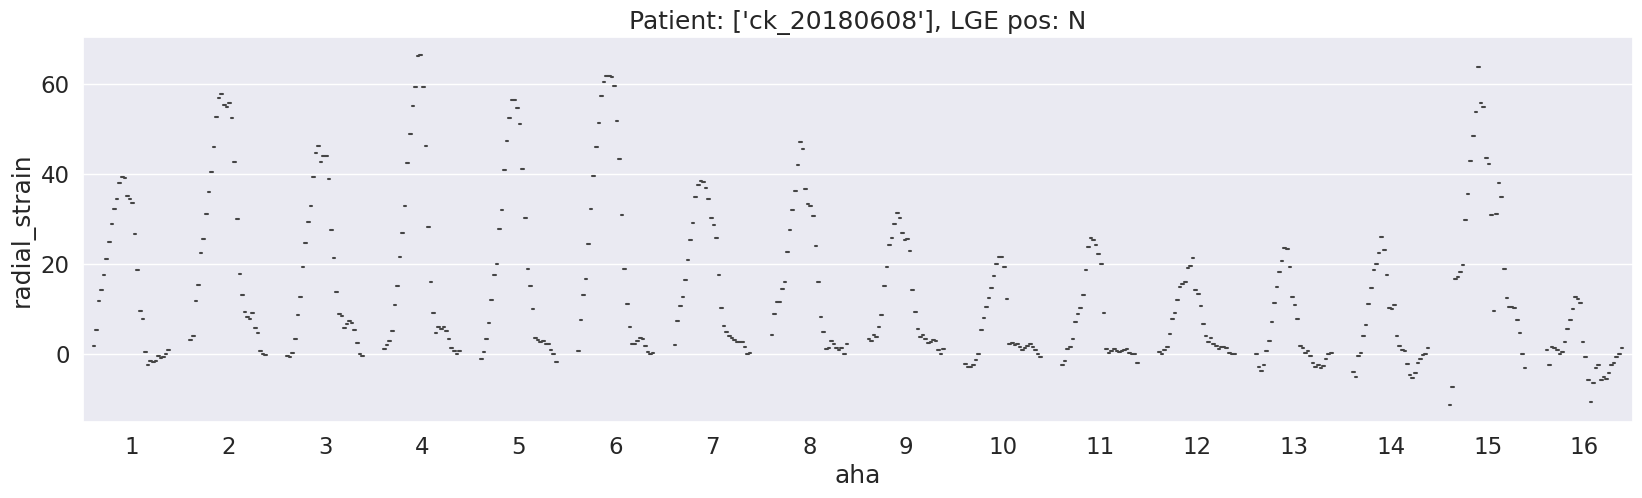

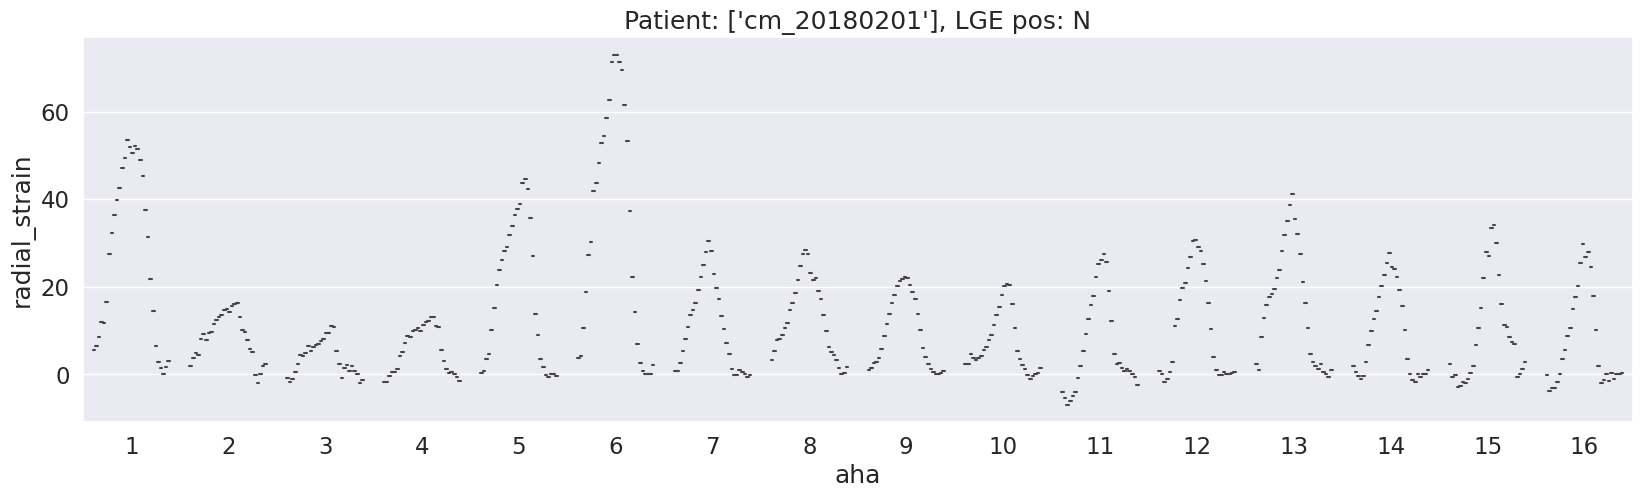

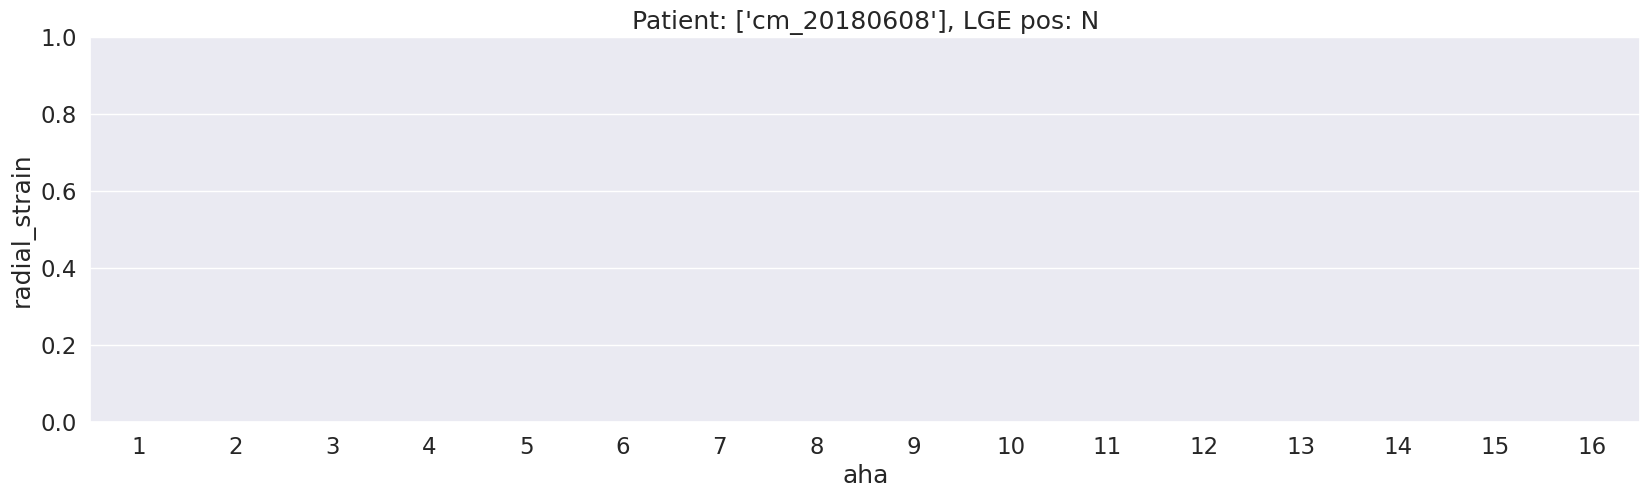

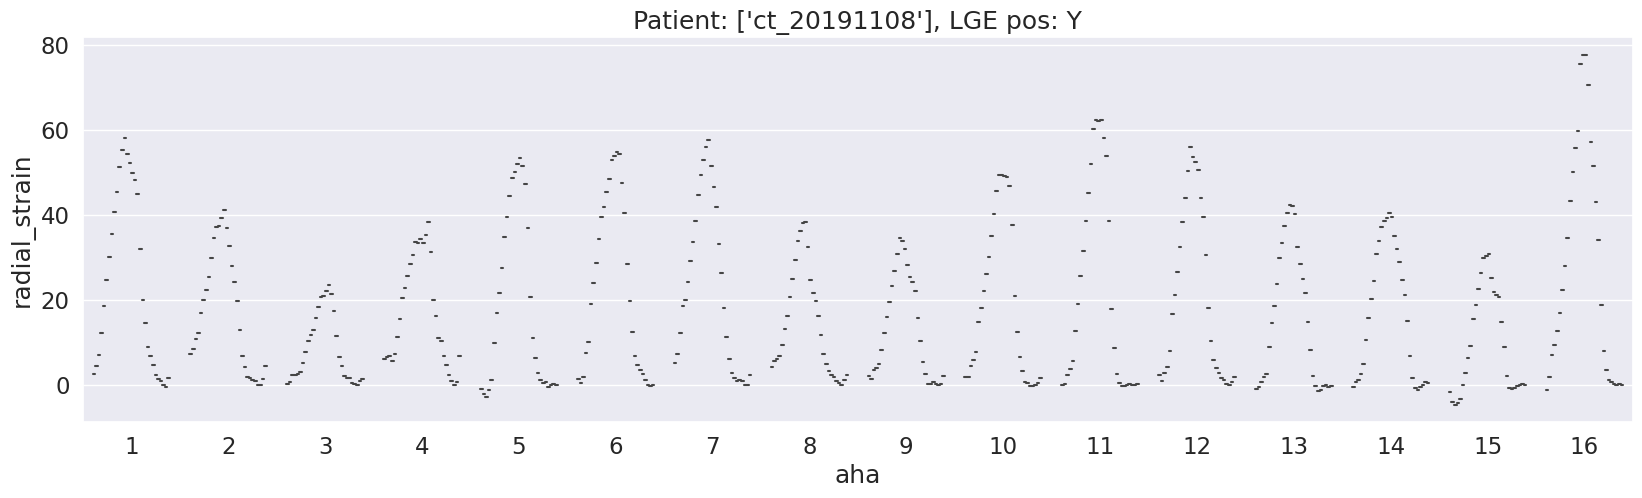

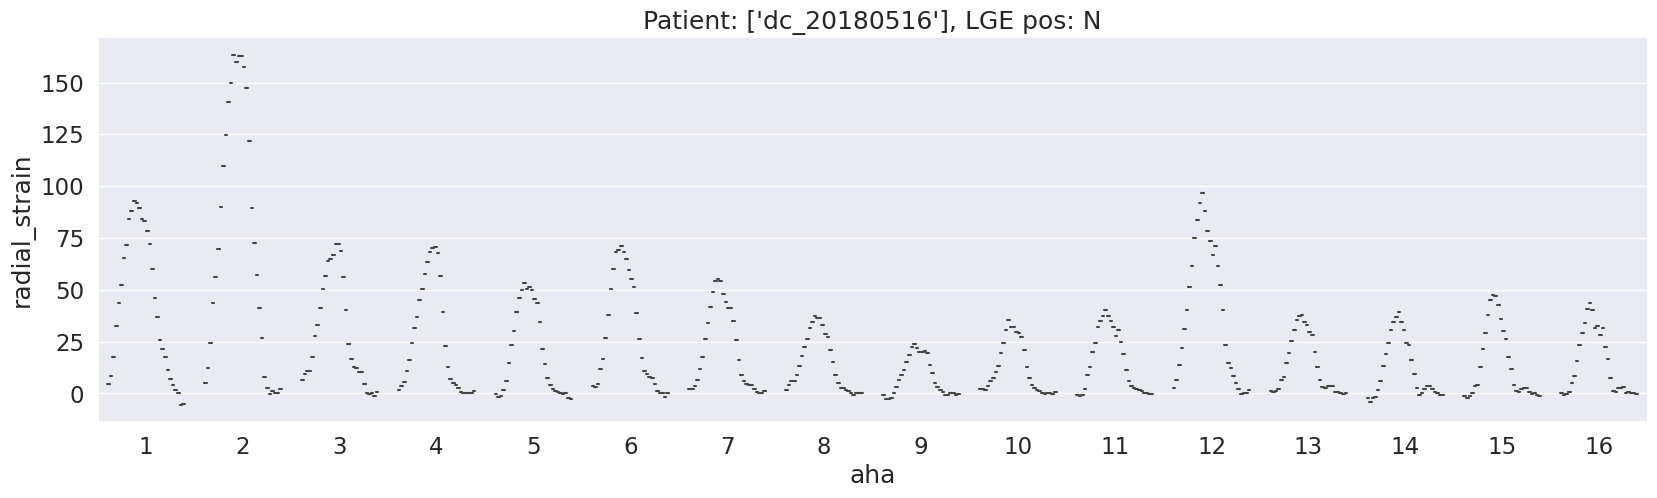

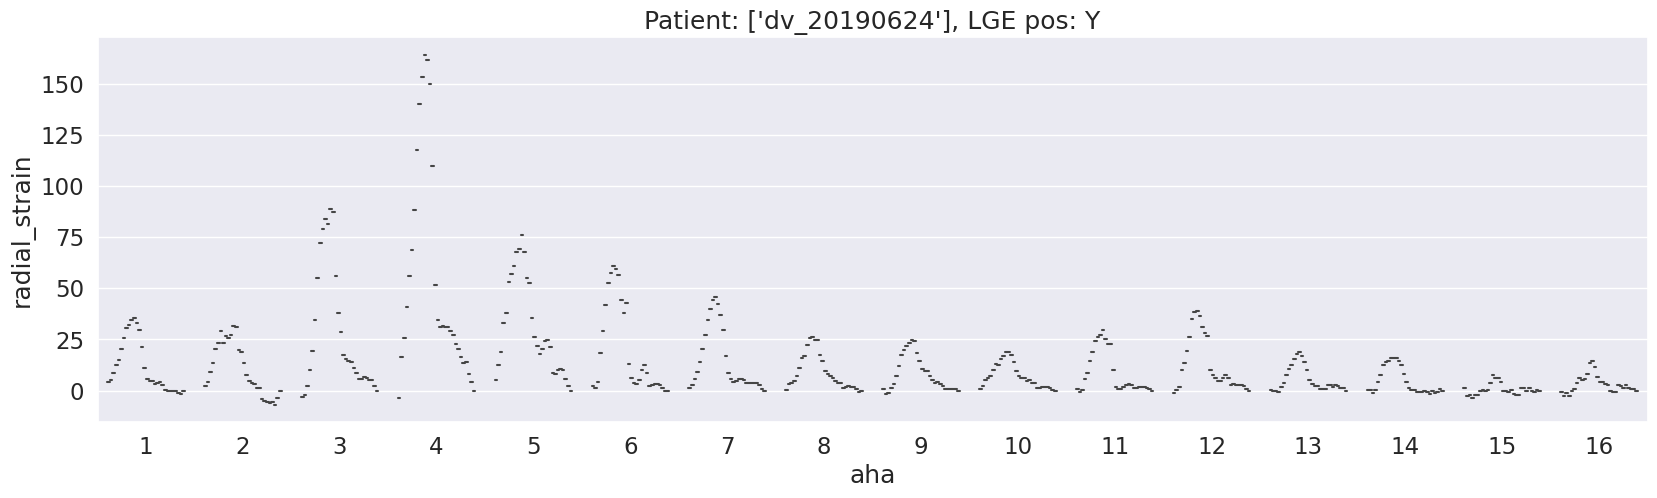

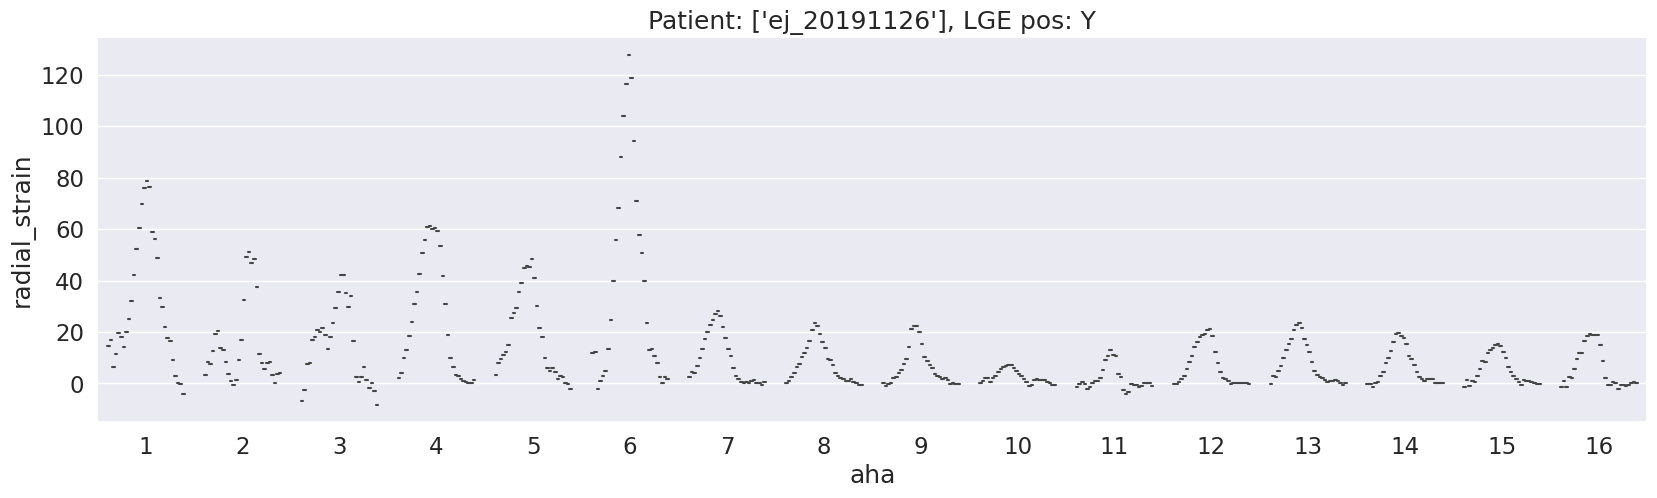

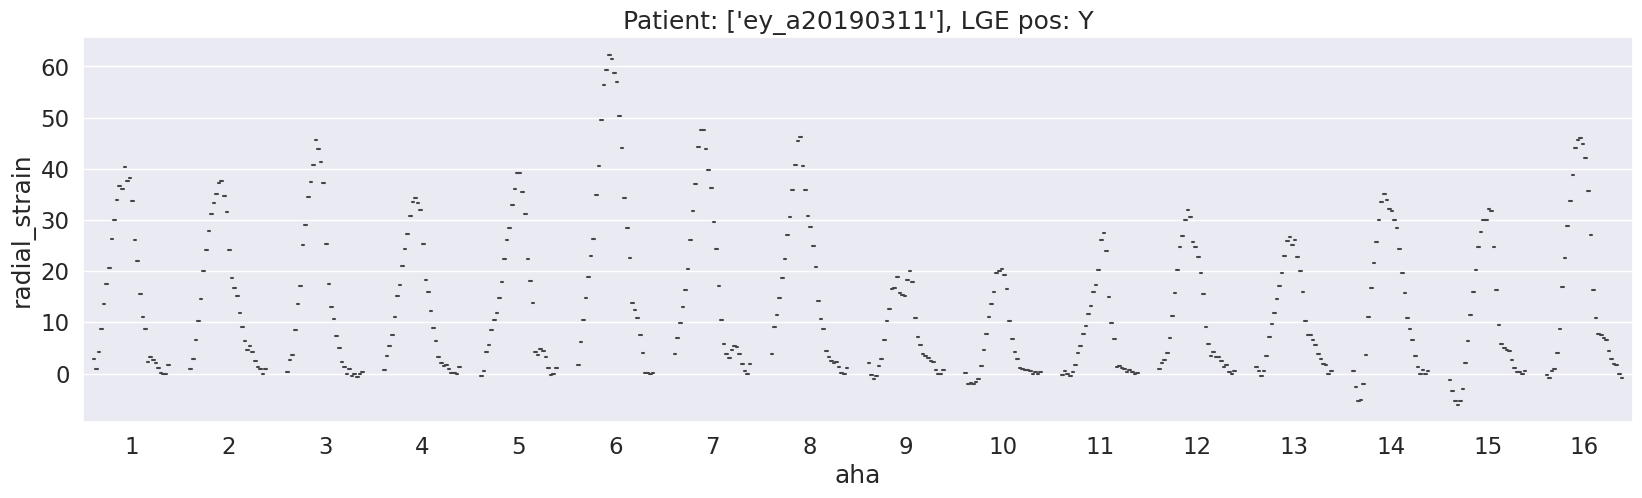

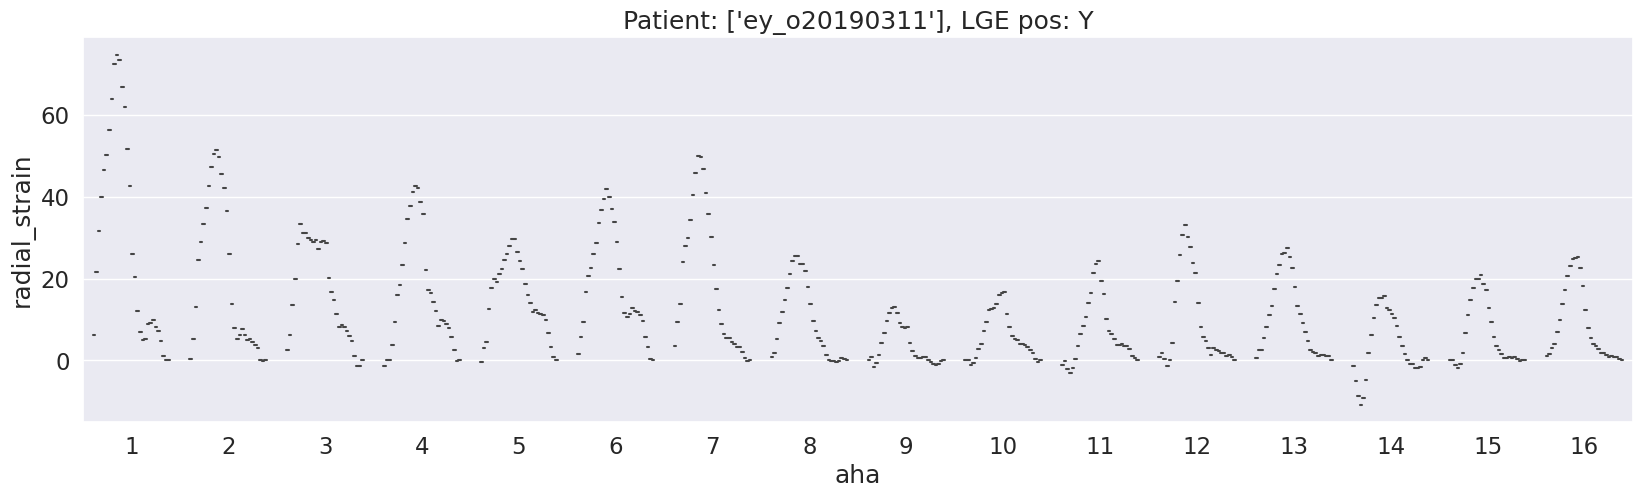

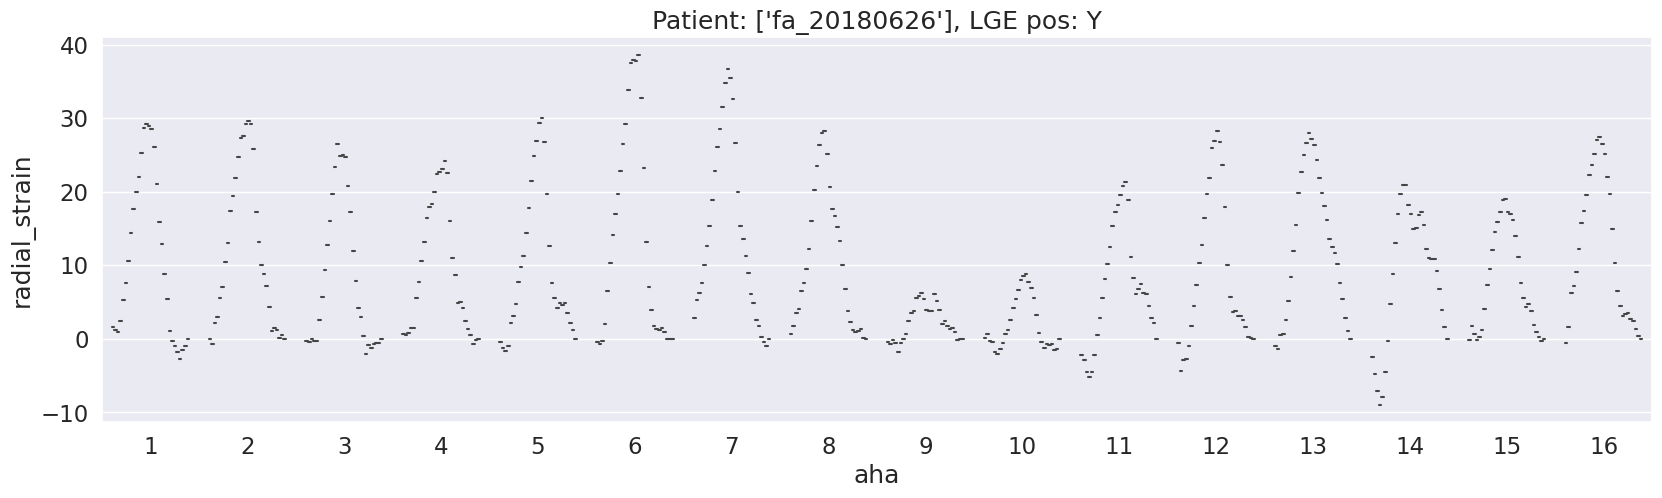

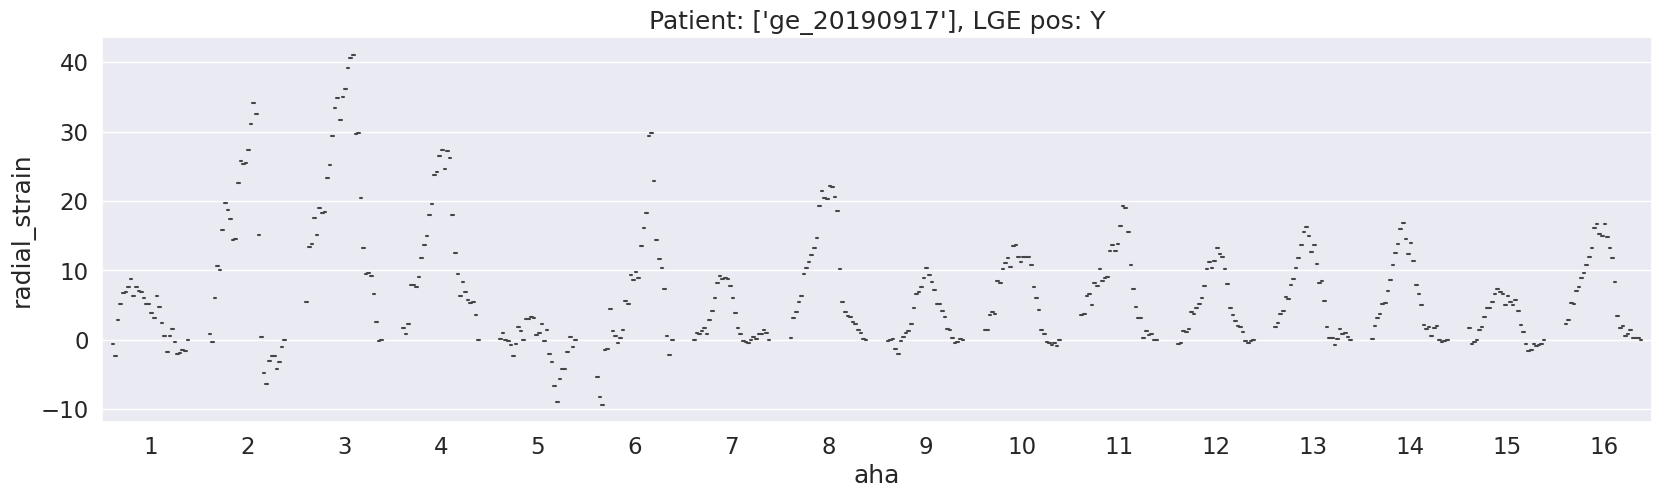

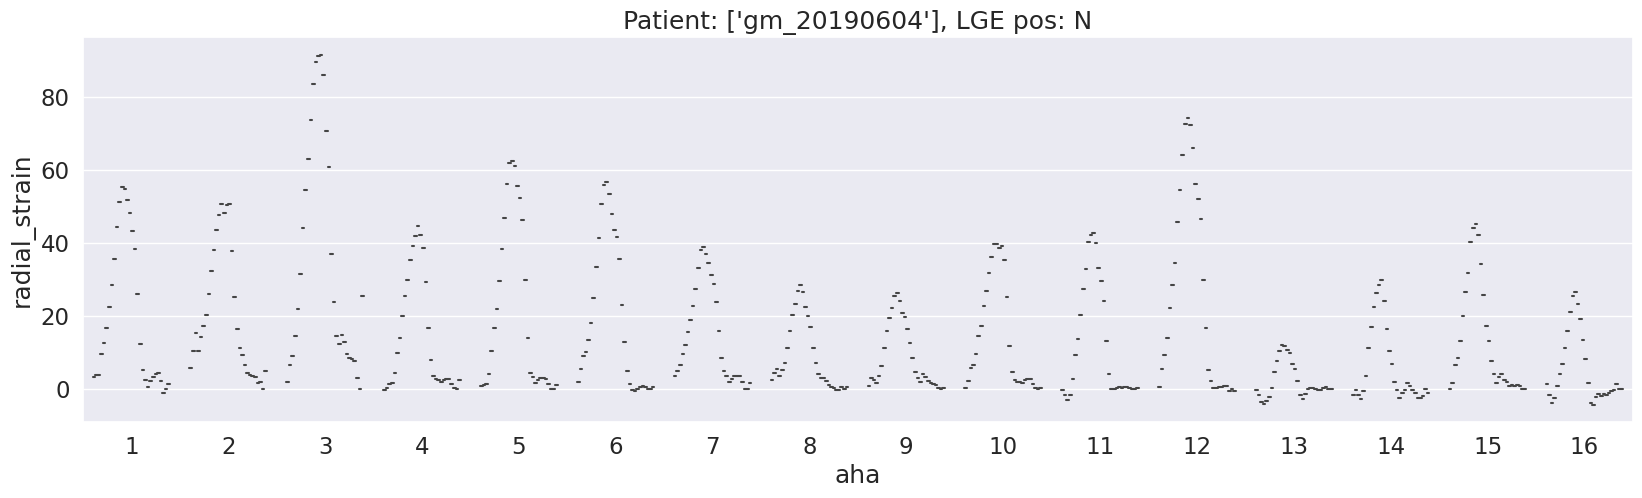

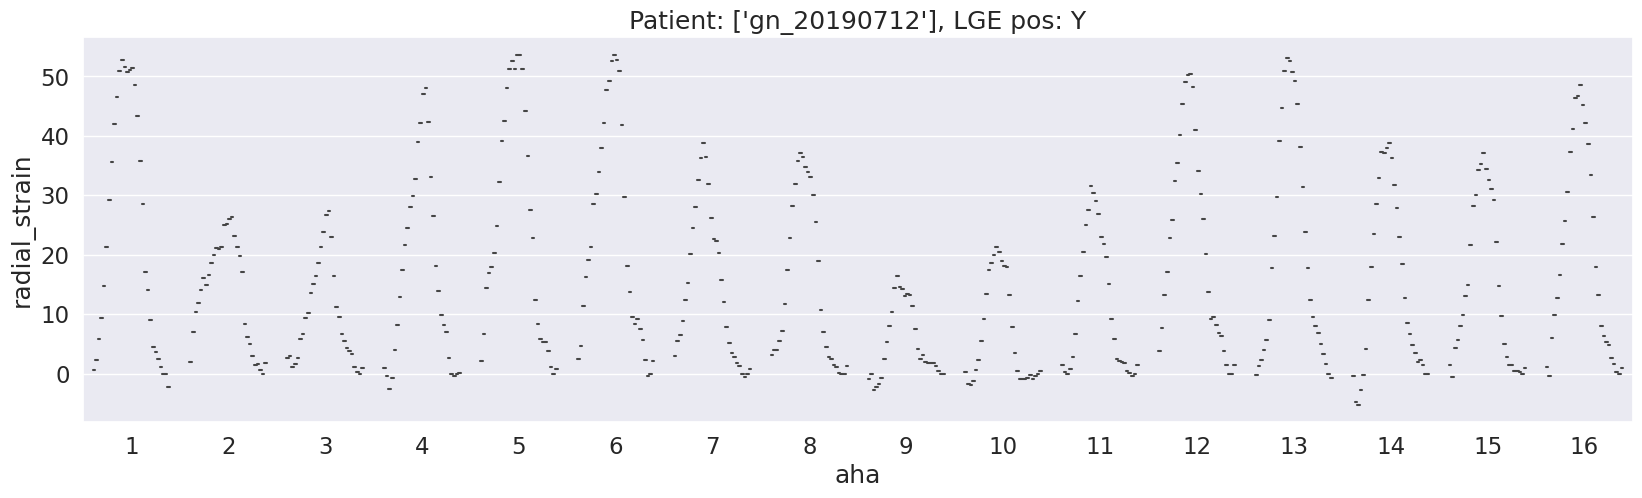

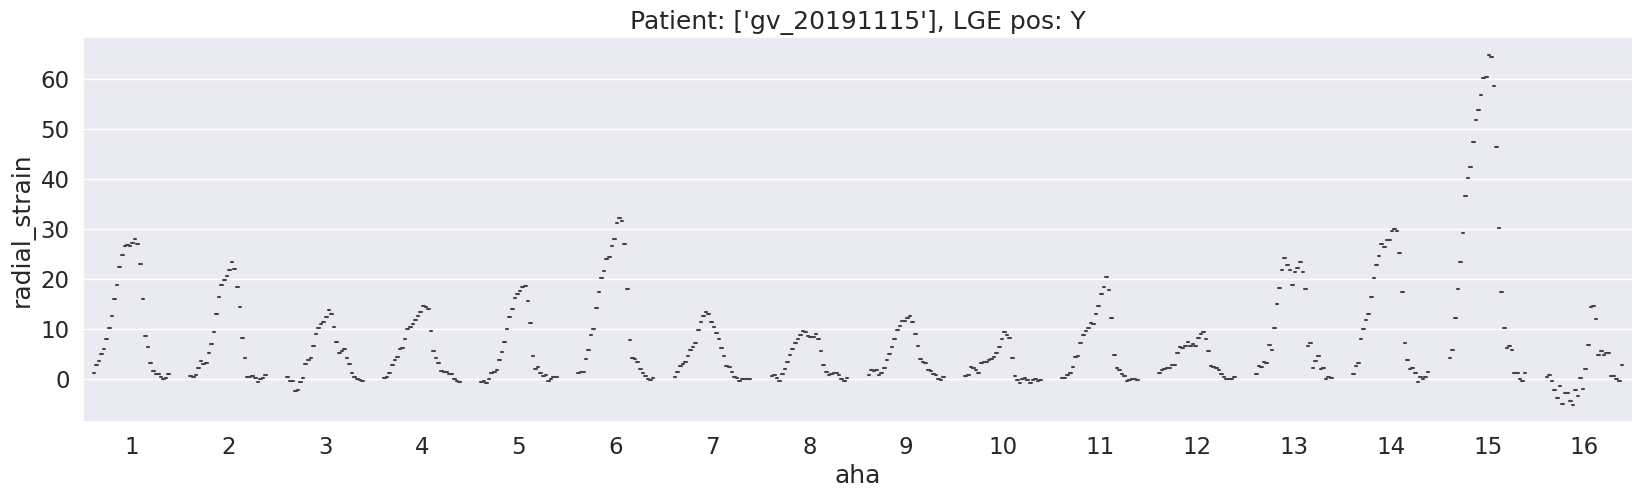

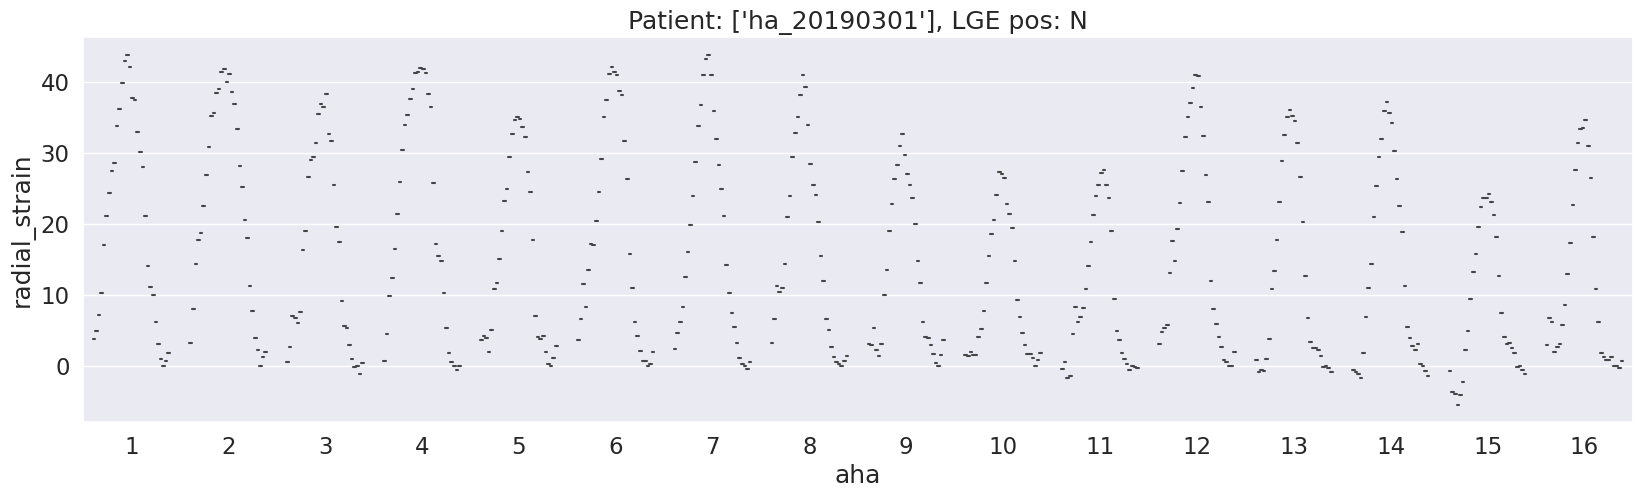

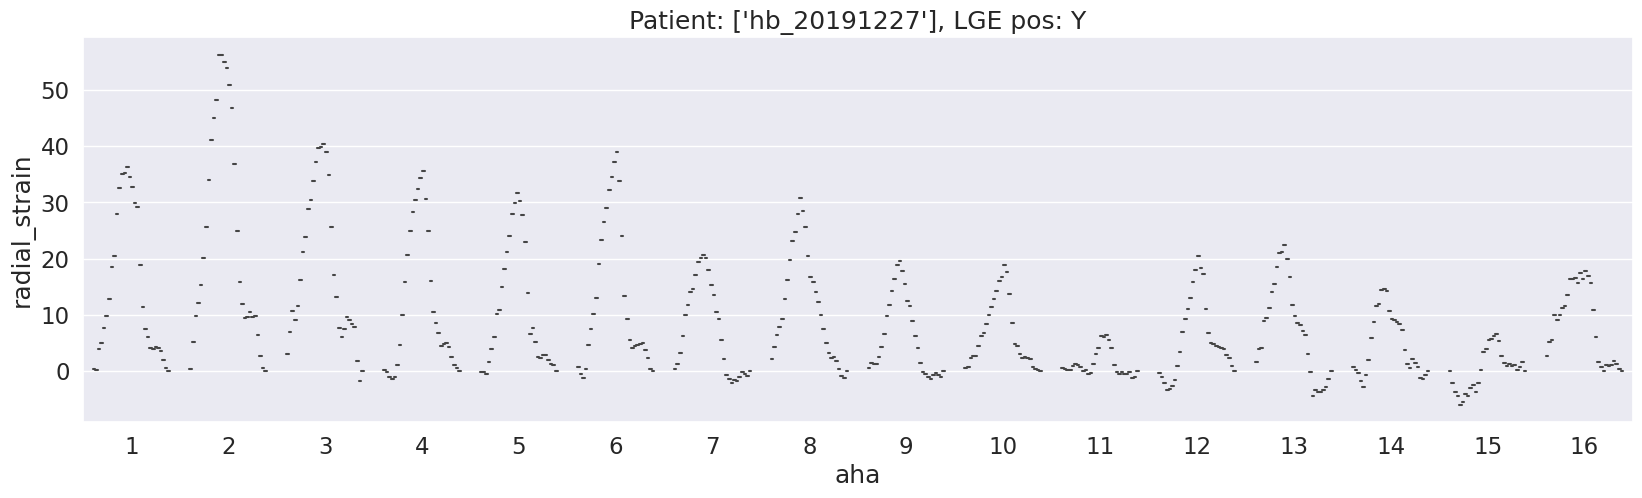

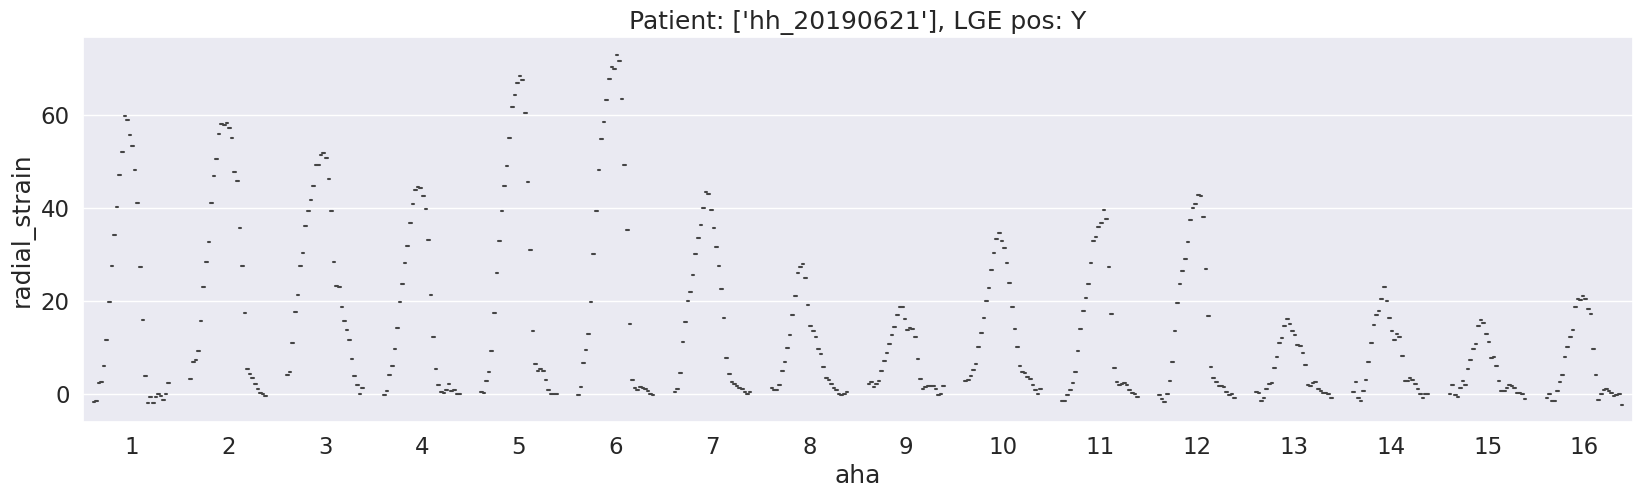

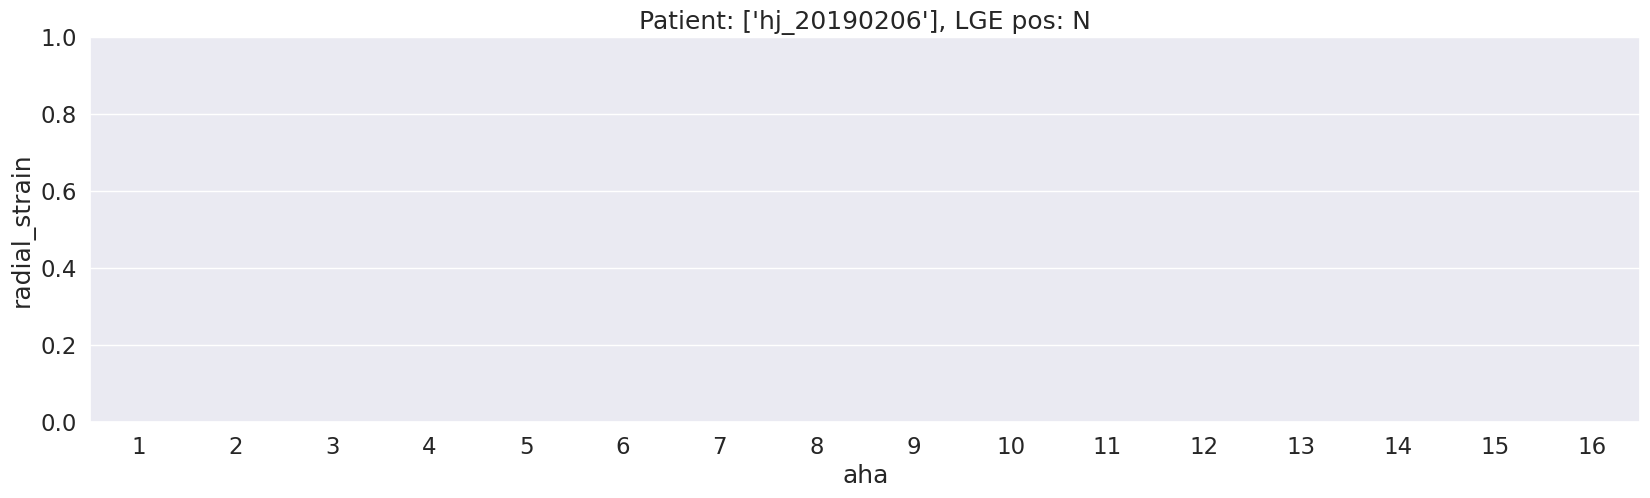

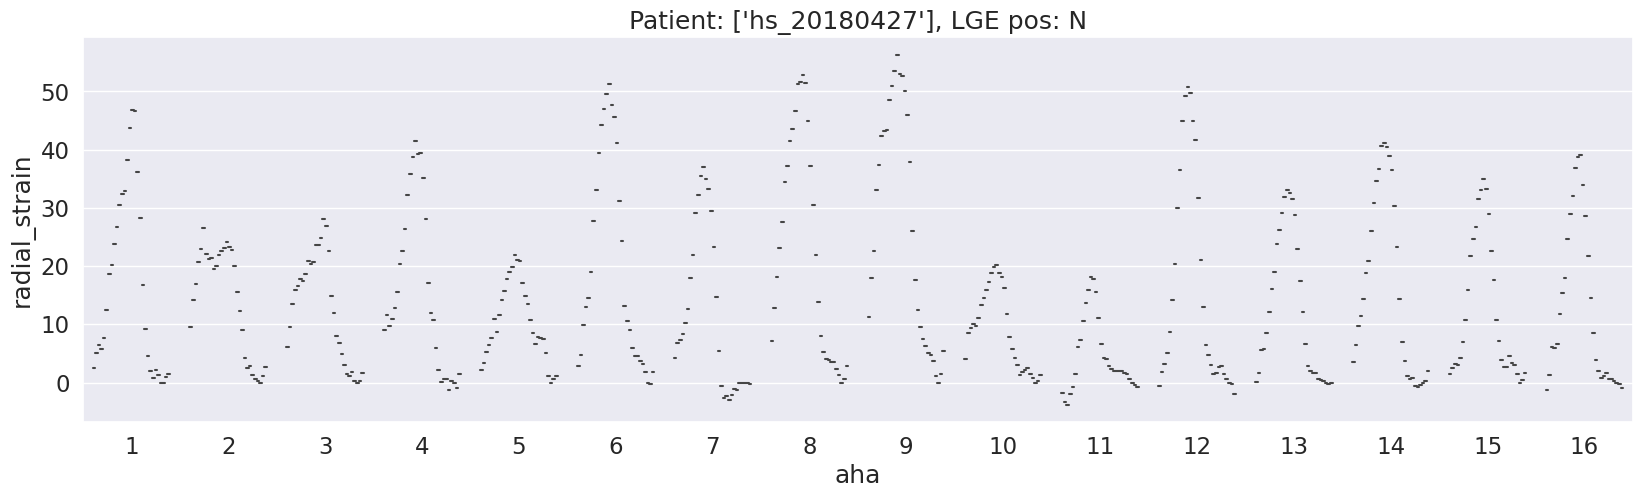

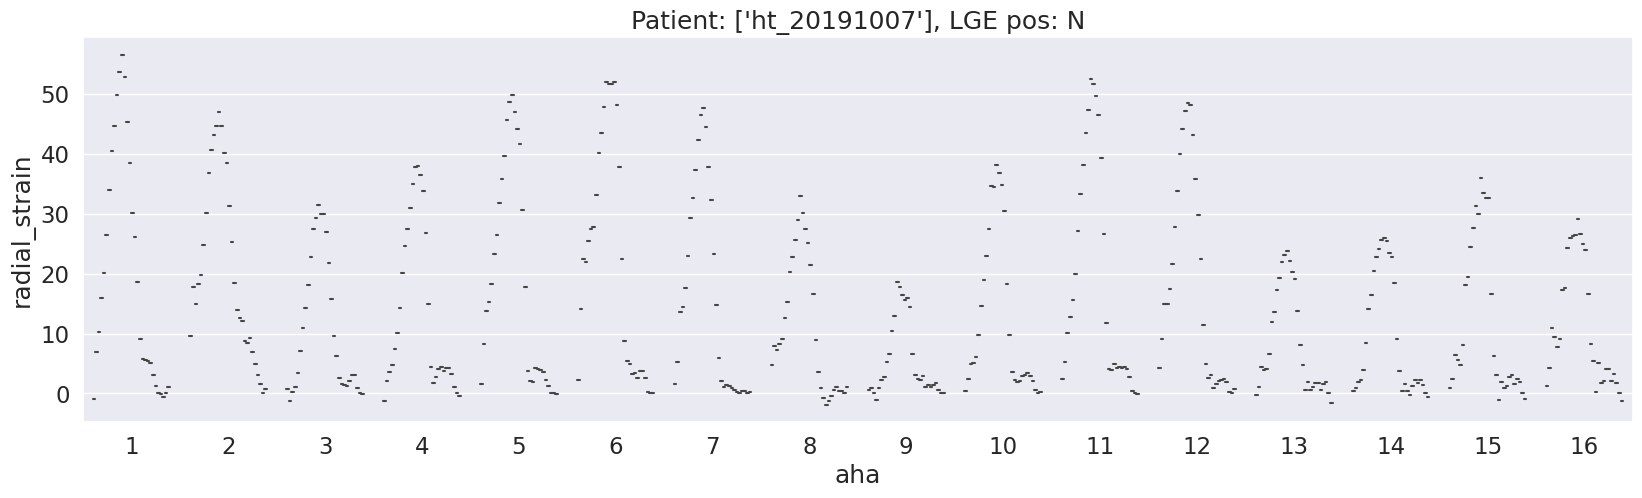

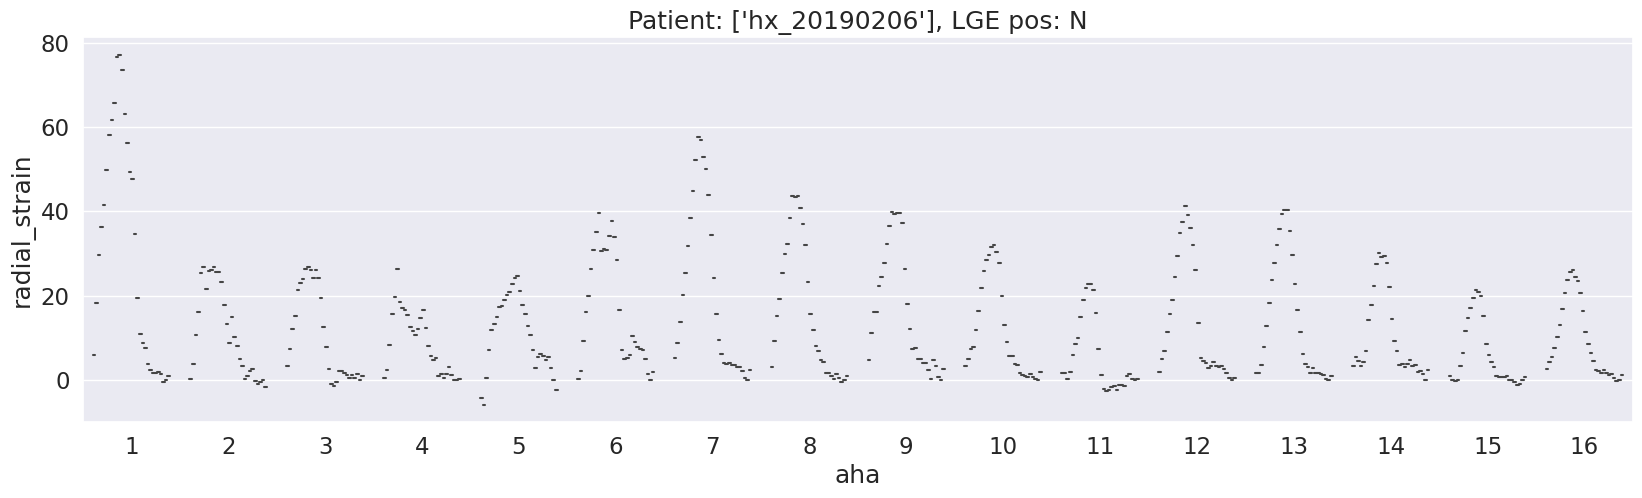

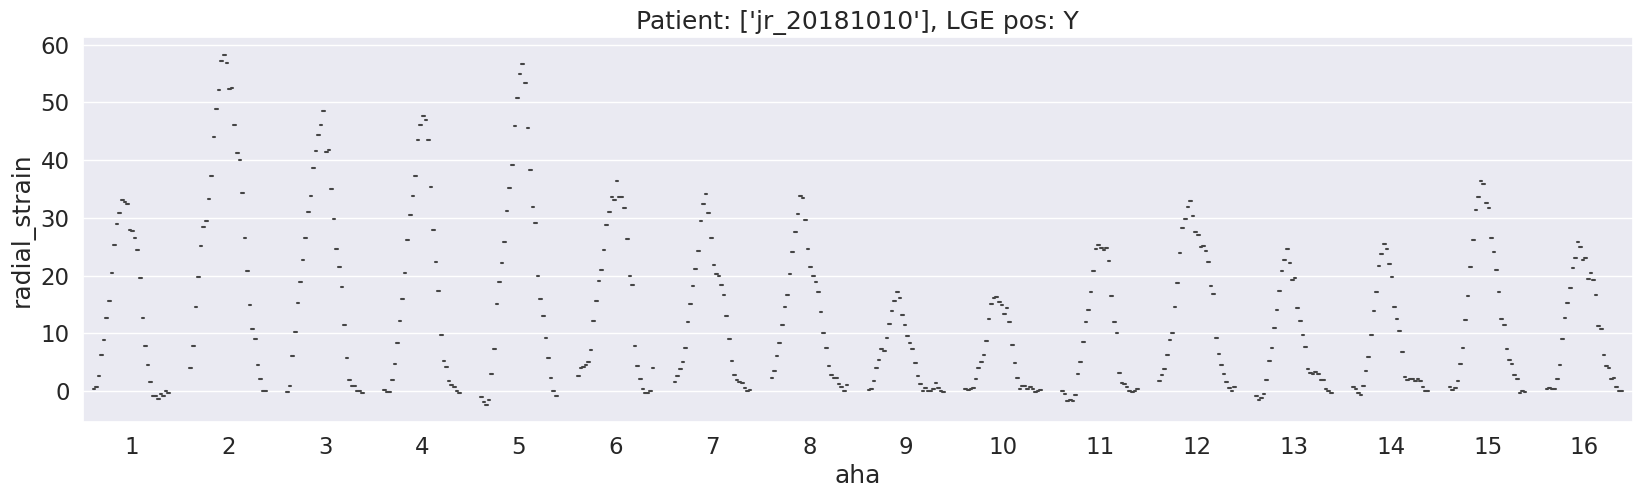

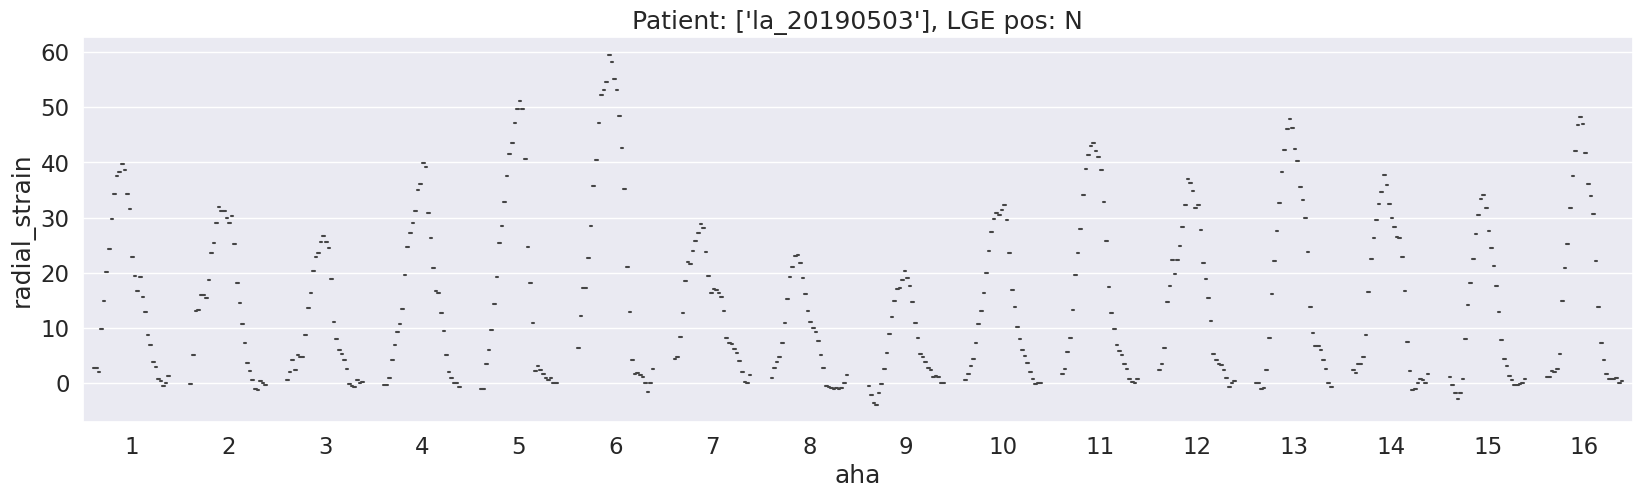

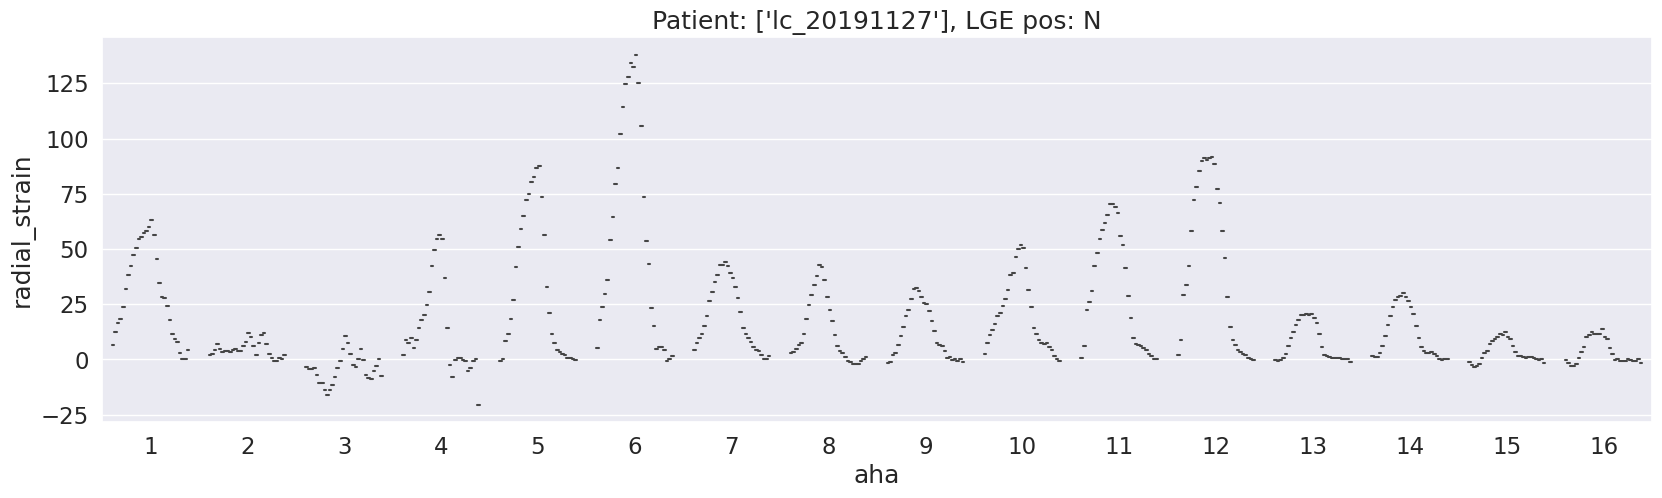

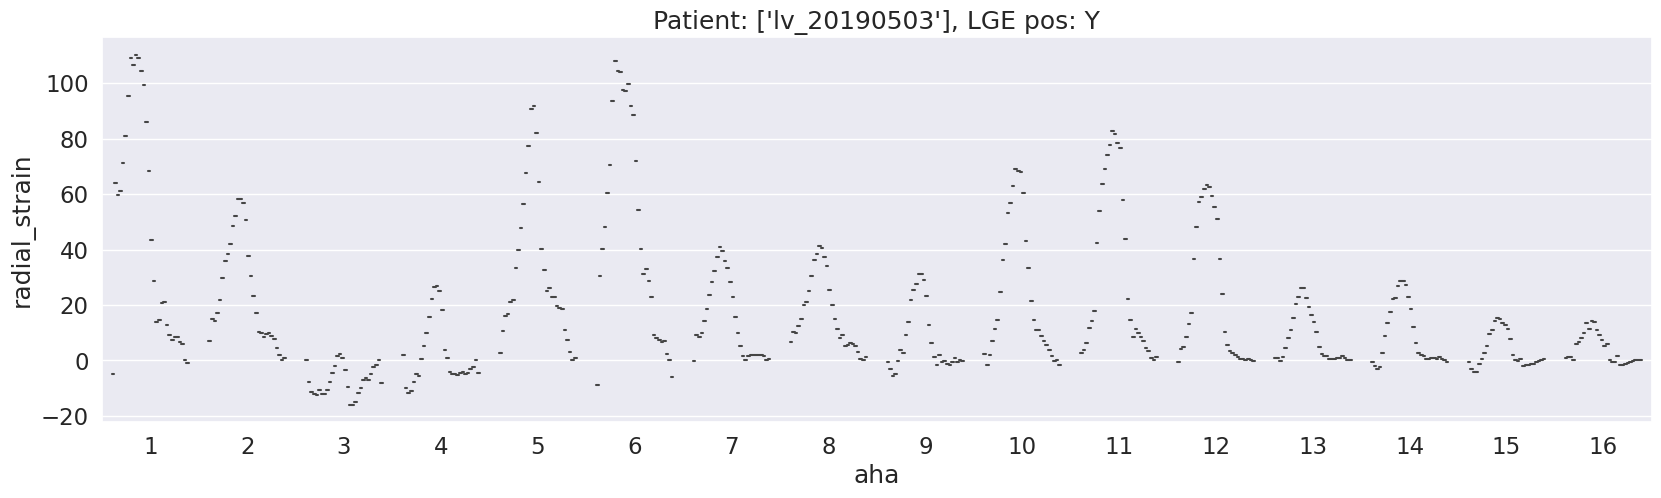

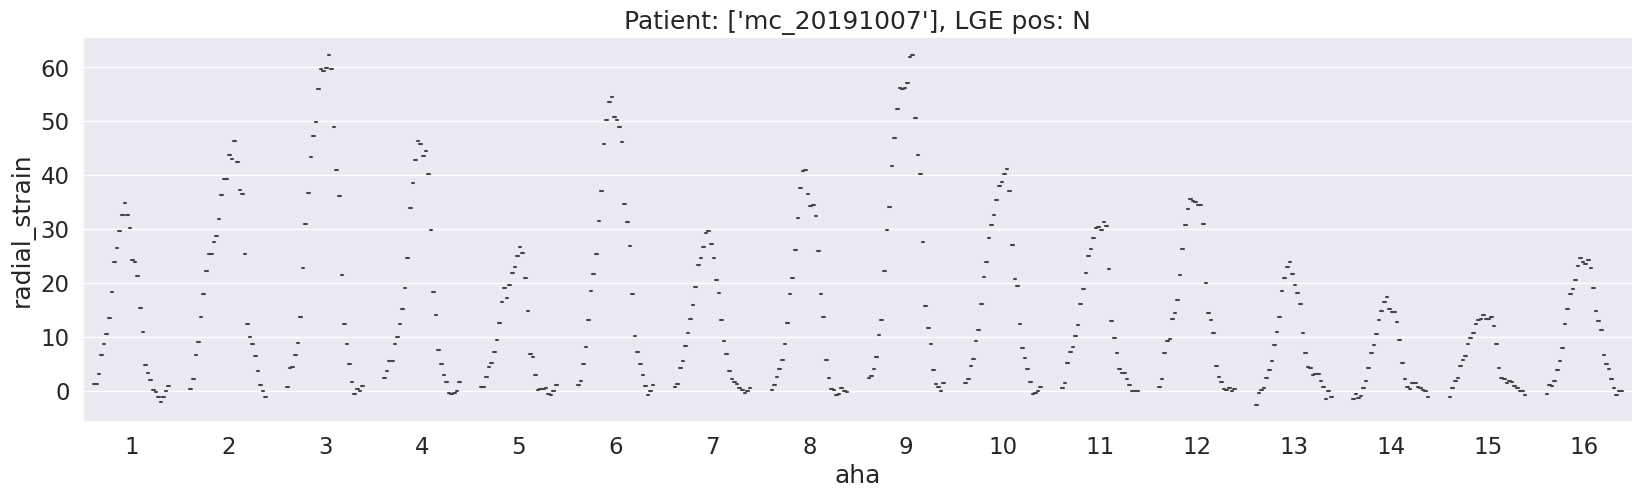

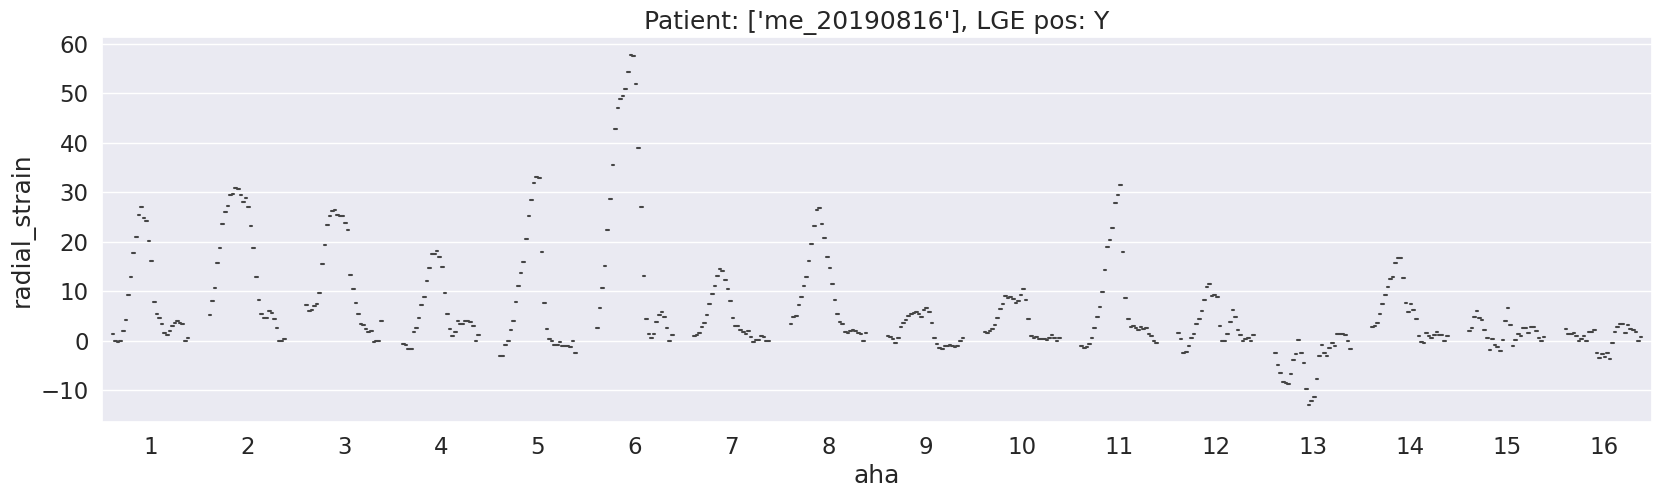

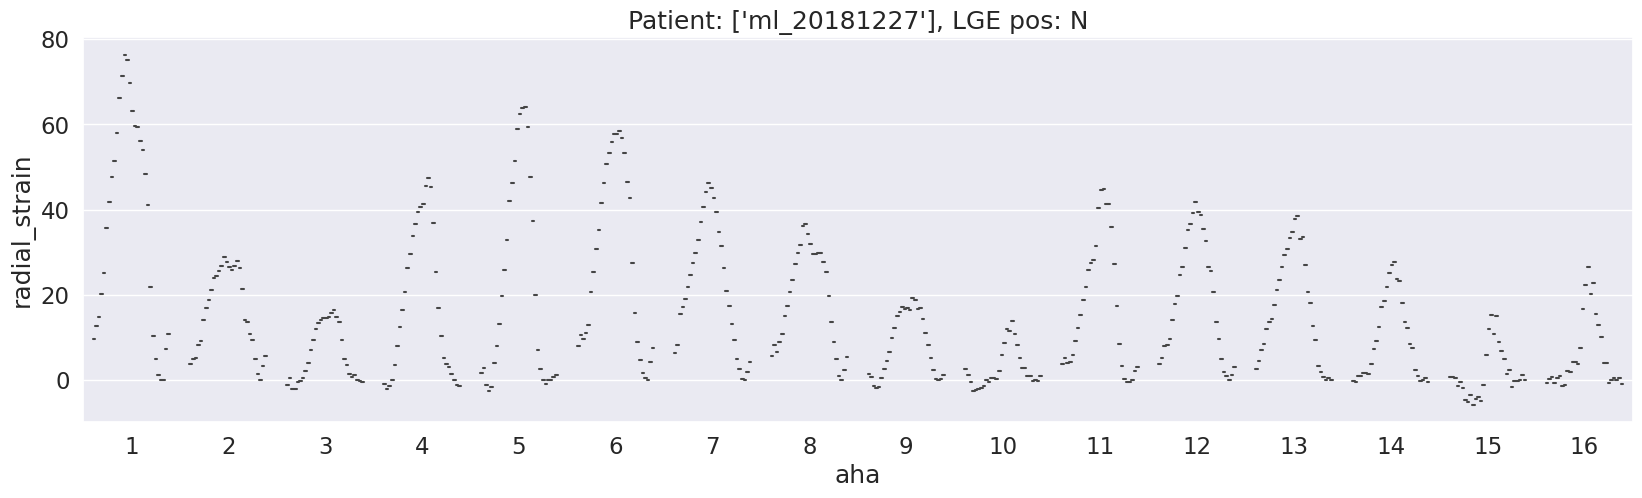

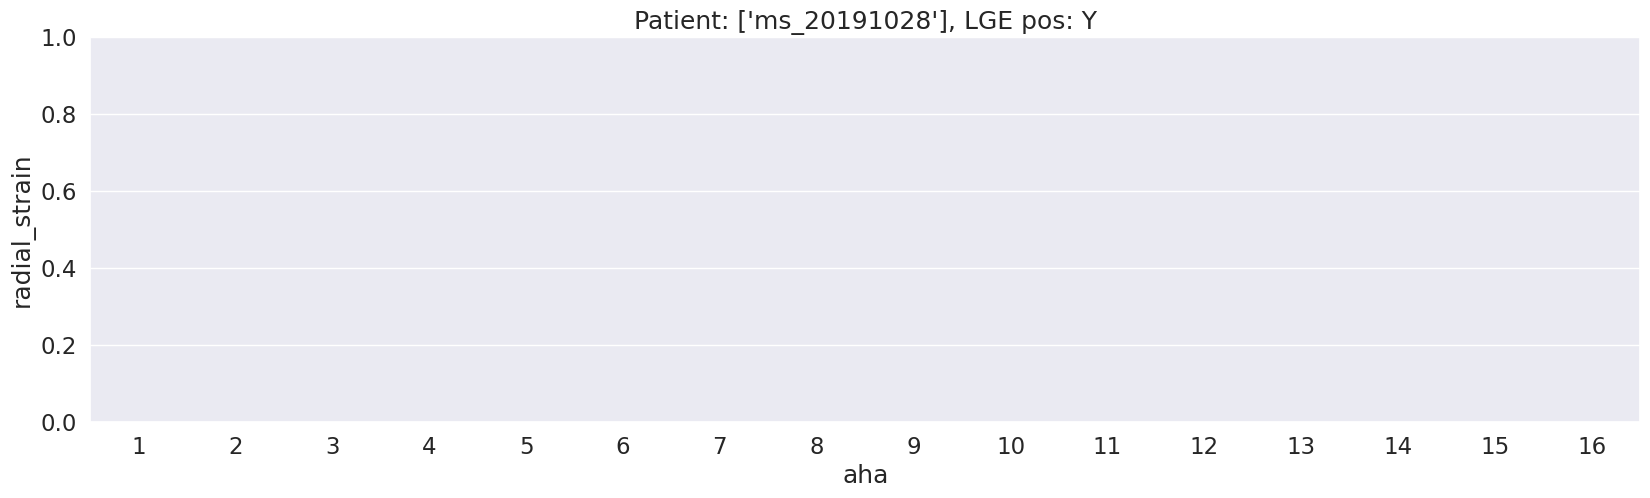

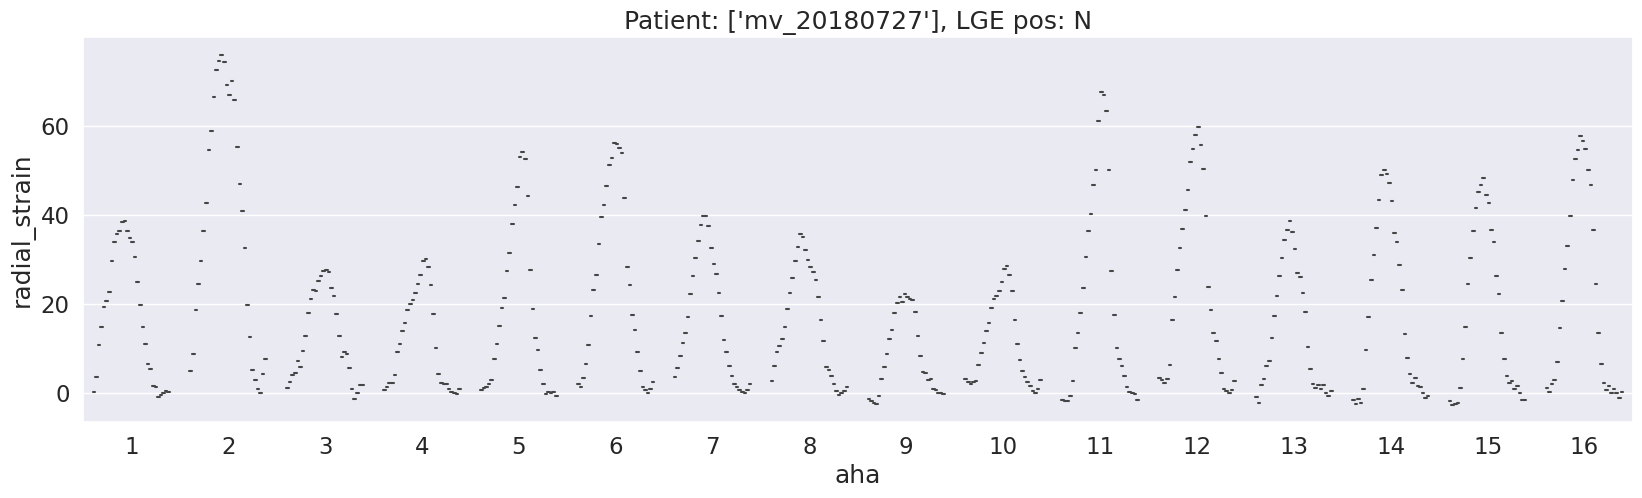

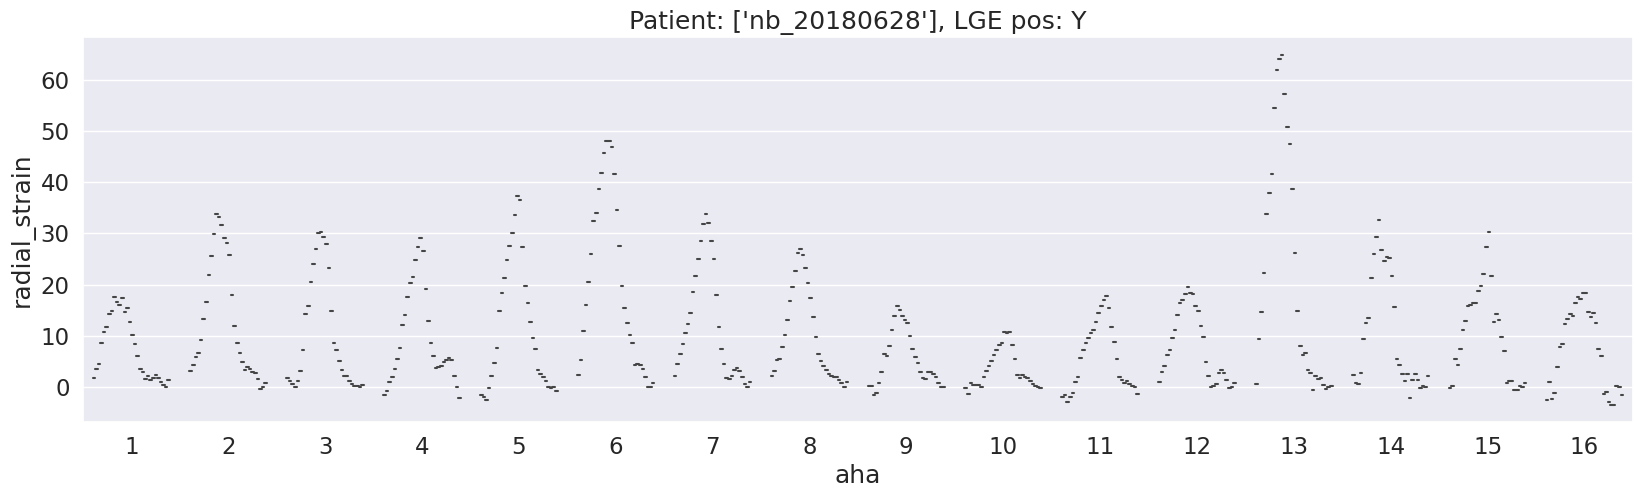

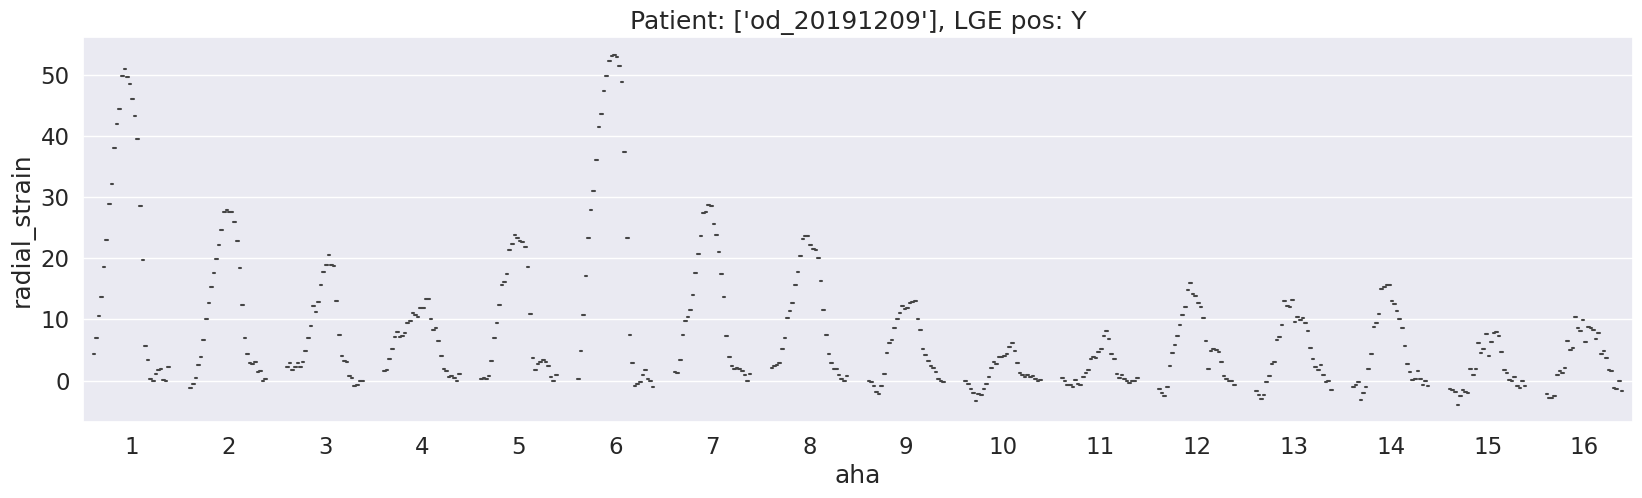

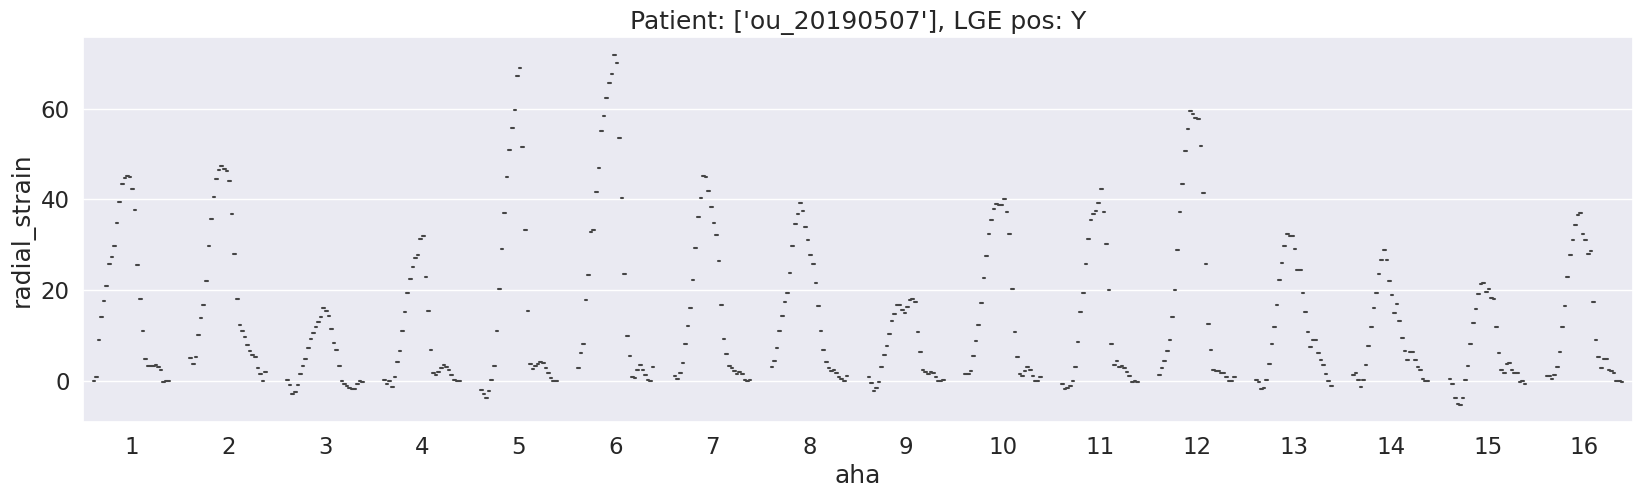

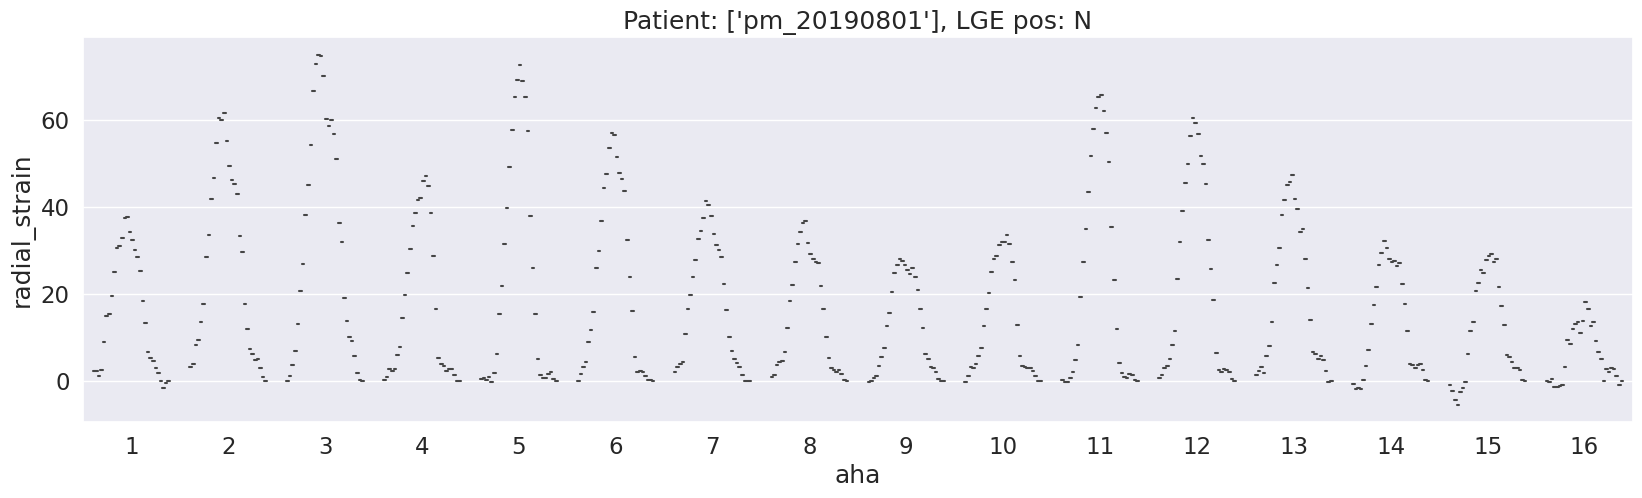

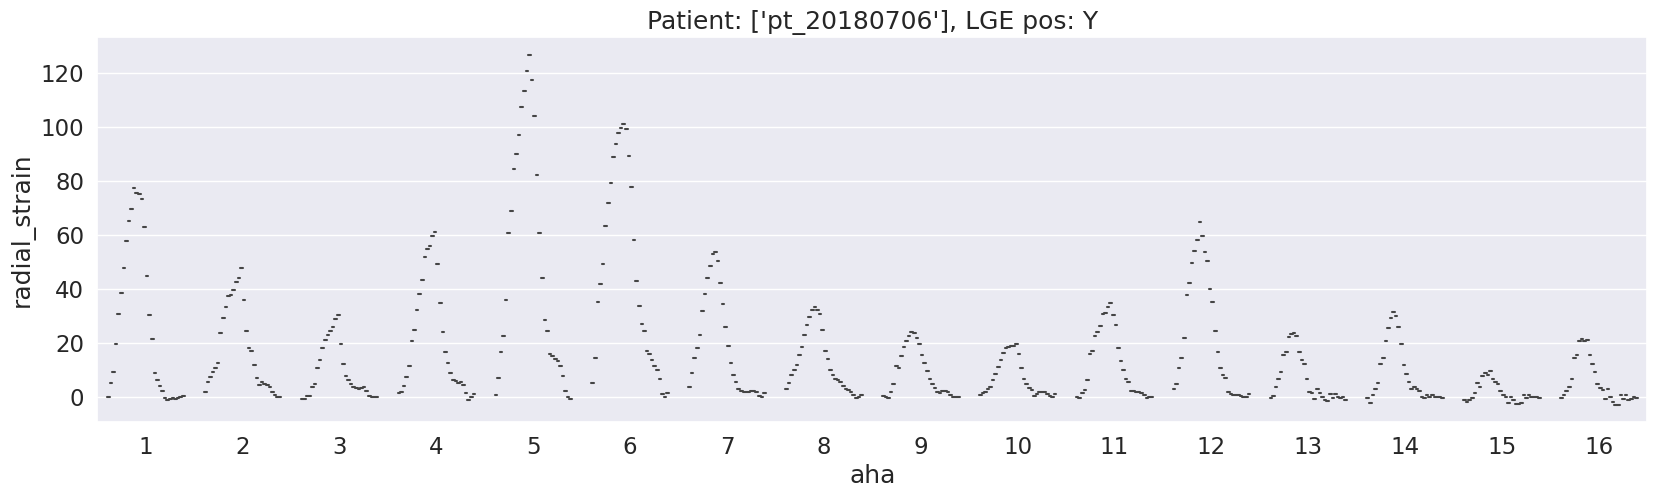

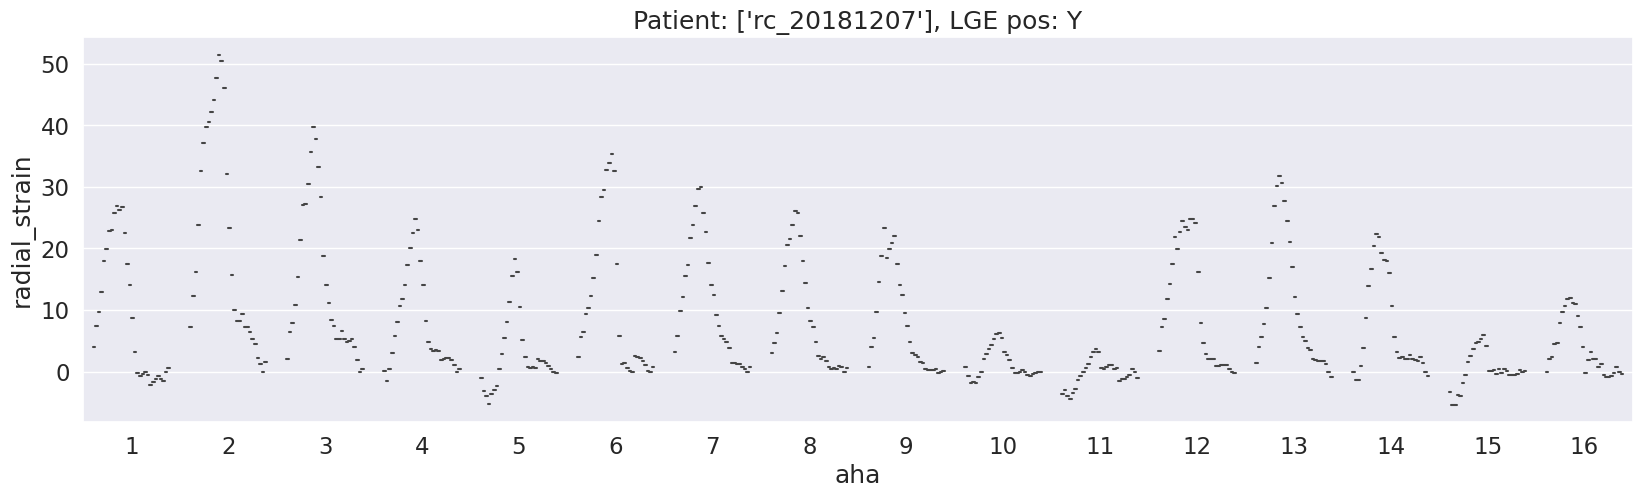

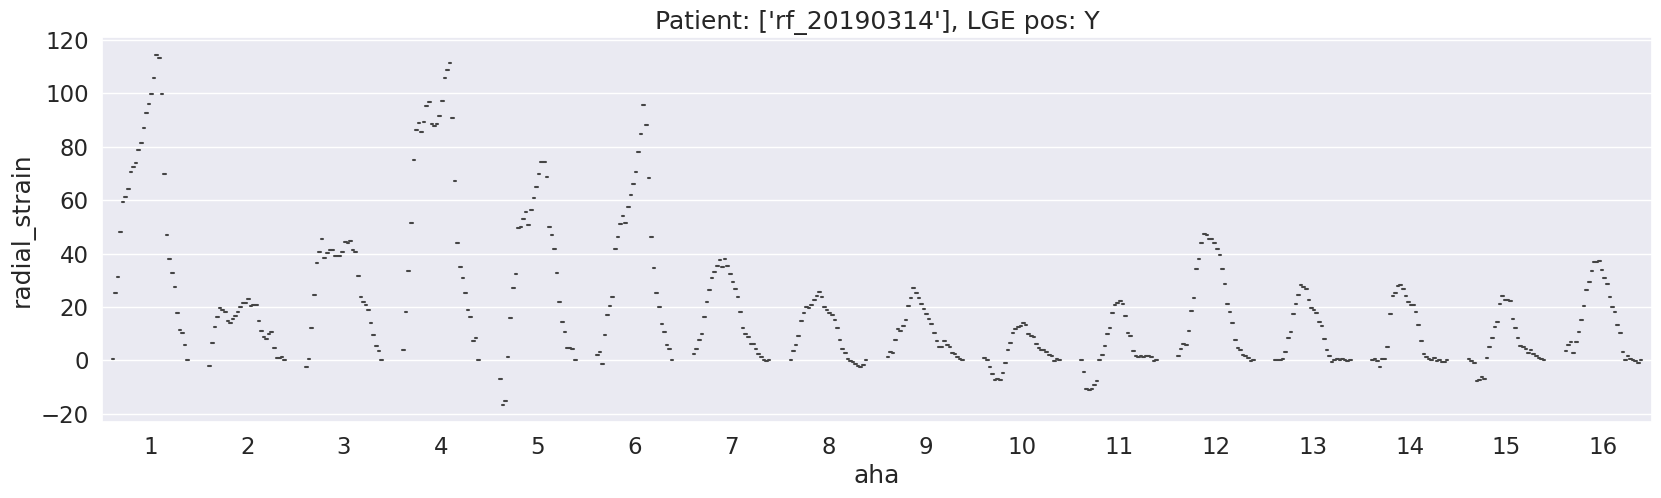

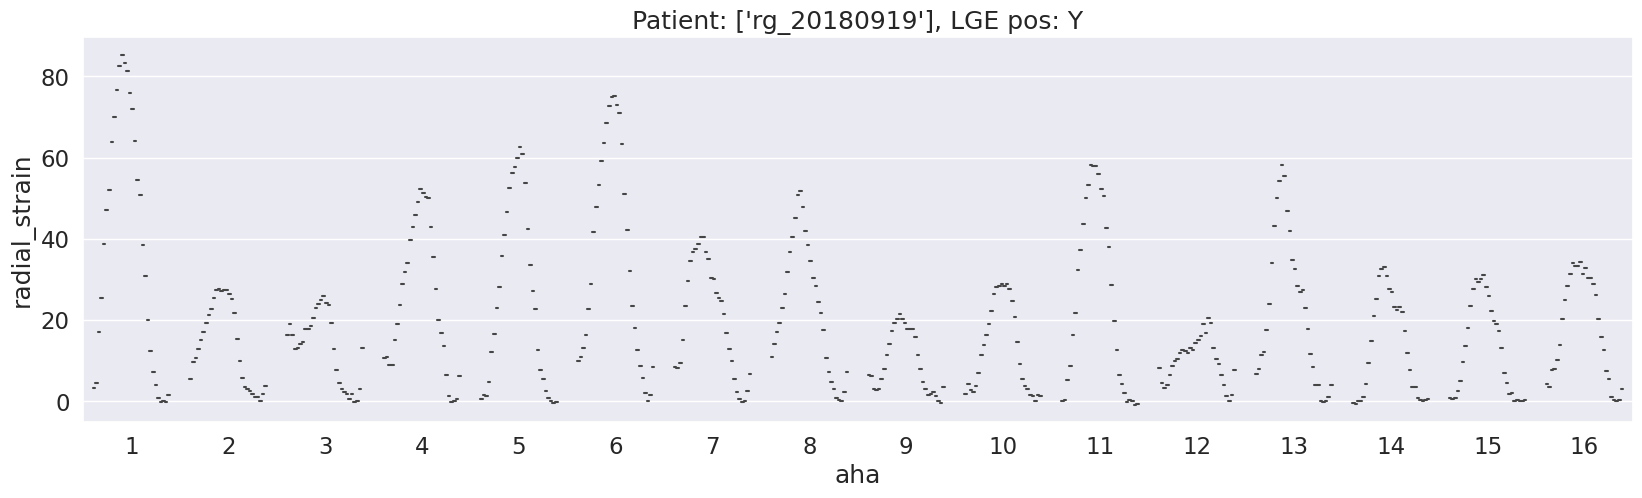

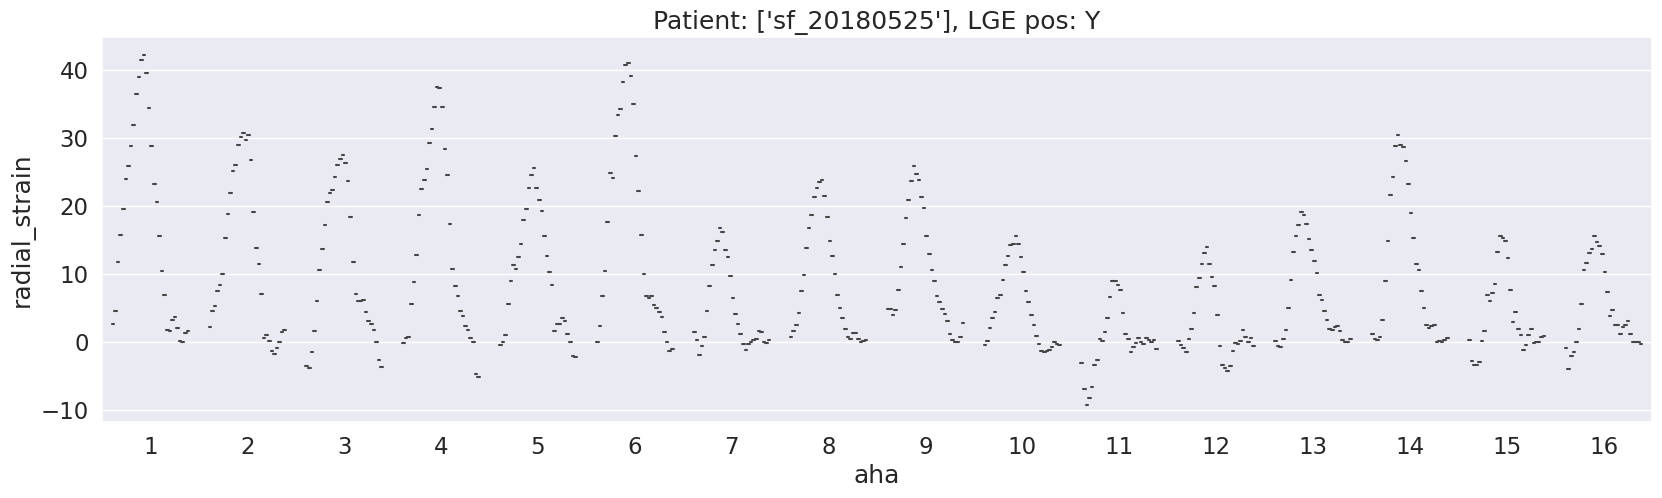

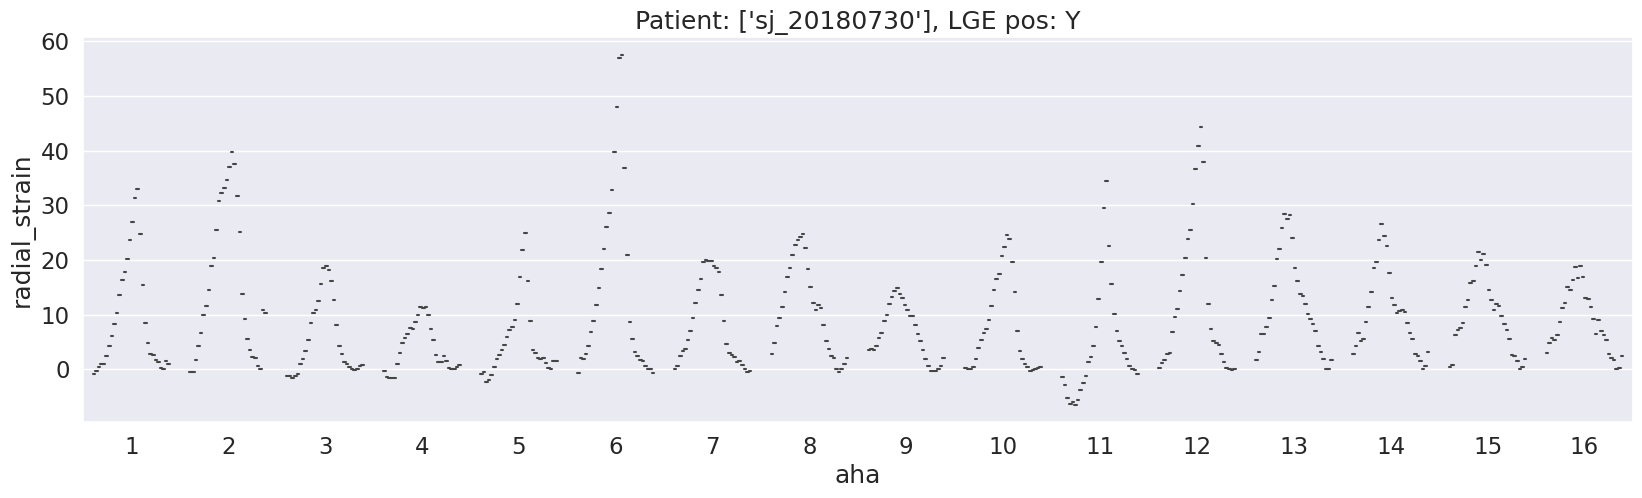

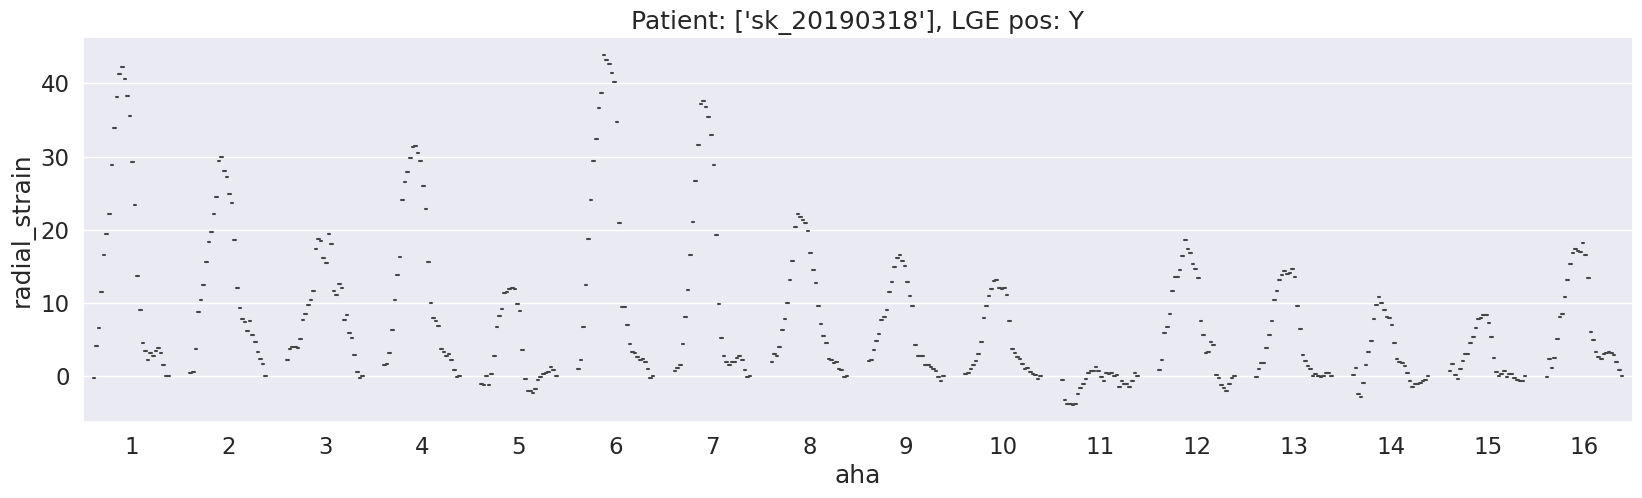

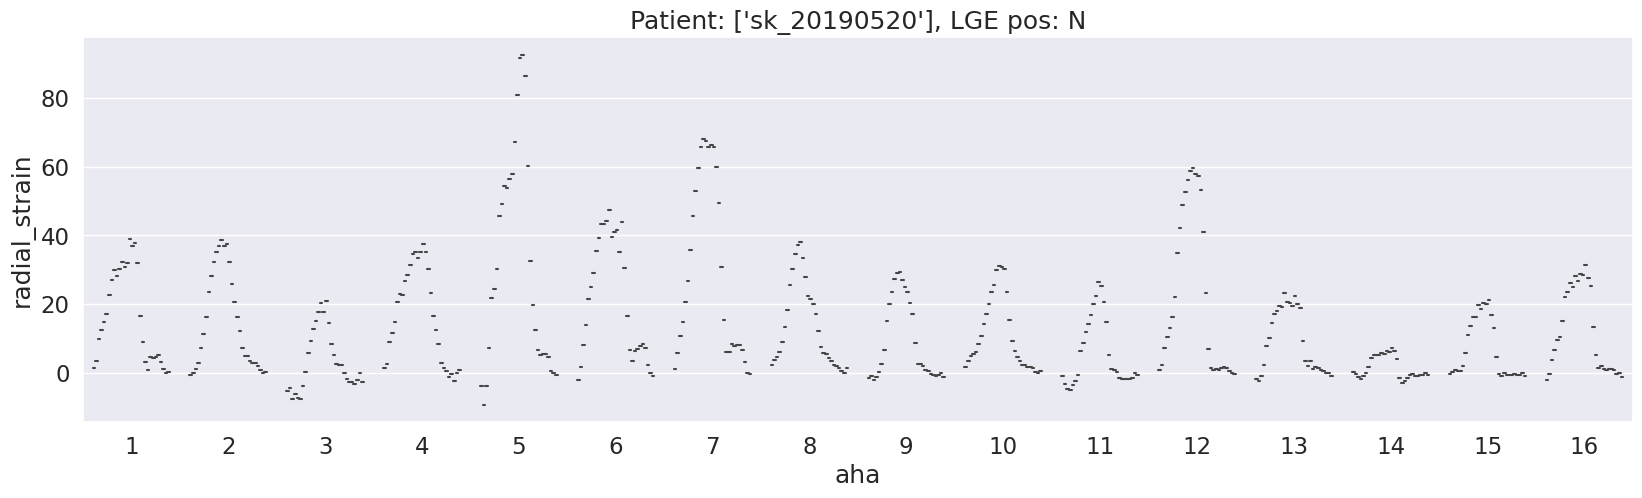

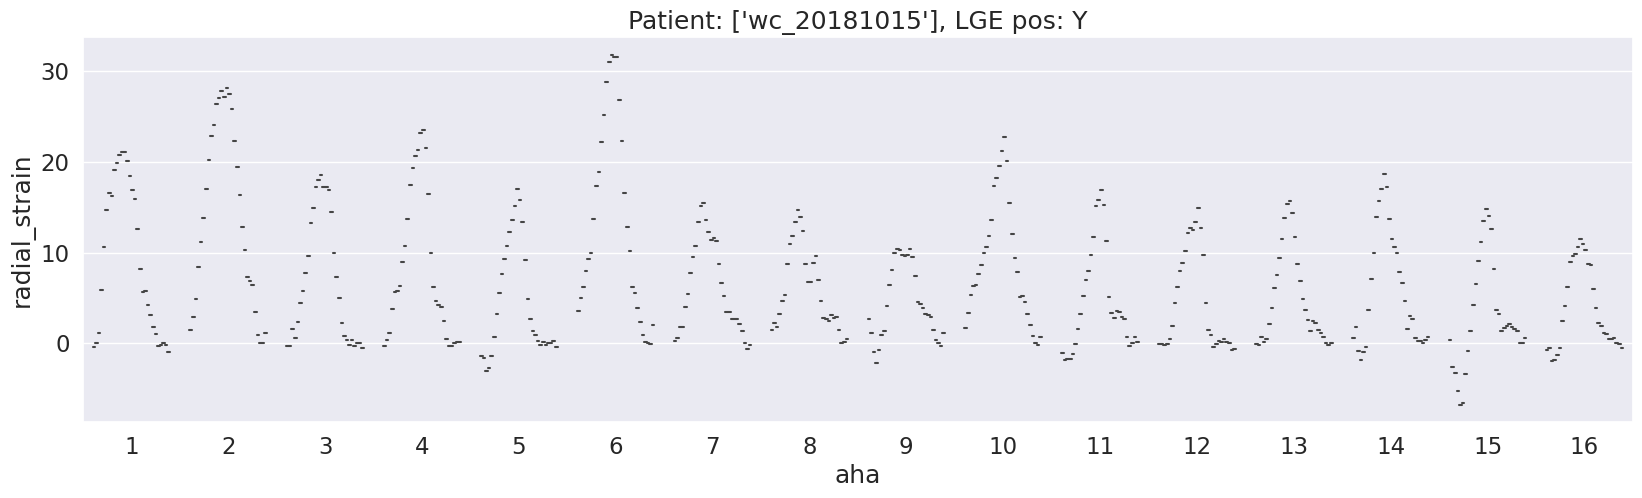

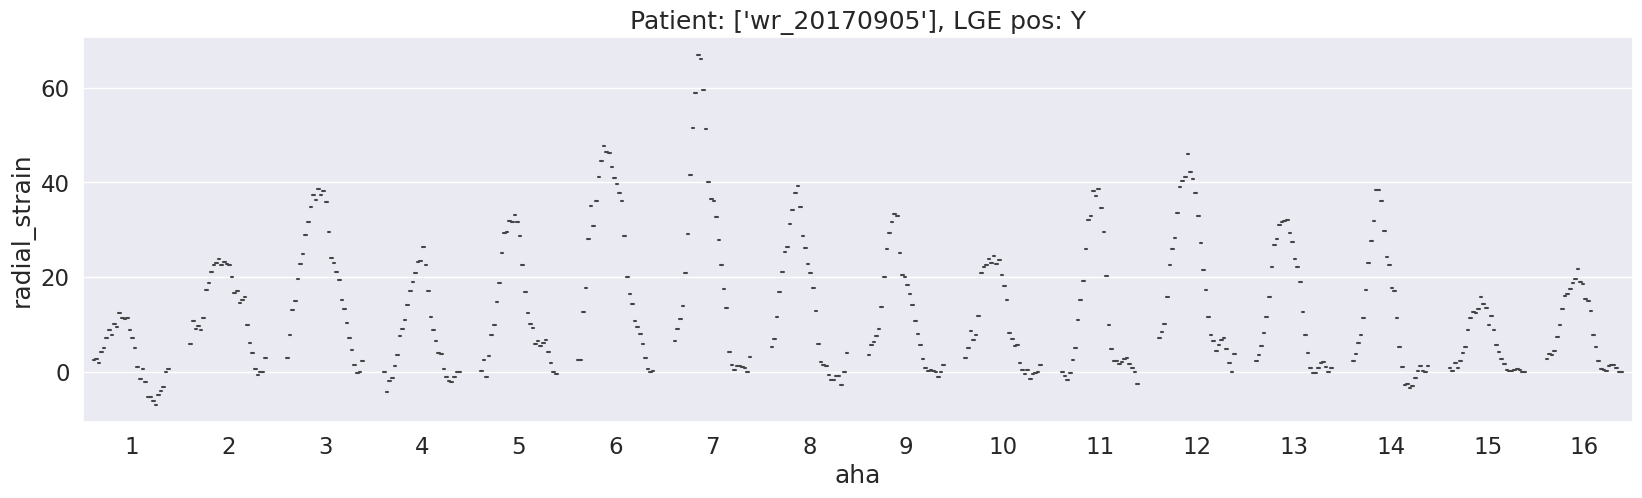

In [58]:
def plot_strain(df, segments=[1]):
    sb.set_context('paper')
    sb.set(font_scale = 1.5)
    fig, ax = plt.subplots(1,1,figsize=(20,5))
    plt.title('Patient: {}, LGE pos: {}'.format(segments, df[df['patient'].isin(segments)].target.values[0]))
    sb.violinplot(x="aha", y="radial_strain",inner='quart',
                     data=df[df['patient'].isin(segments)],
                  ax=ax,
                 hue='frame',
                  #scale_hue=True,
                 #split=True
                 )
    plt.legend([],[], frameon=False)
    plt.show()
_ = [plot_strain(df_merged, segments=[i]) for i in df_merged.patient.unique()]

In [13]:
df_merged.describe() # 27360 = 57 patients x 16 segments x 30 frames

aha  radial_strain  circ_strain          ED#          MS#  \
count  9840.000000    9840.000000  9840.000000  9840.000000  9840.000000   
mean      8.500000      11.044185    -6.760735    25.243902     4.878049   
std       4.610006      14.293530     7.195681     8.792851     1.024829   
min       1.000000     -11.987000   -34.412000     0.000000     1.000000   
25%       4.750000       0.714750   -11.744250    28.000000     4.000000   
50%       8.500000       5.839000    -4.755000    28.000000     5.000000   
75%      12.250000      16.906500    -0.666750    29.000000     5.000000   
max      16.000000     163.389000    45.347000    29.000000     8.000000   

               ES#          PF#          MD#       Weight       Height  \
count  9840.000000  9840.000000  9840.000000  9840.000000  9840.000000   
mean     11.390244    17.707317    25.105691    58.156911   147.182927   
std       1.285595     1.894597     2.422287    24.089943    17.397612   
min       6.000000    12.000000     1.000000    22.700000    65.800000   
25%      11.000000    16.000000    25.000000    39.300000   136.000000   
50%      11.000000    18.000000    25.000000    53.900000   147.200000   
75%      12.000000    19.000000    26.000000    70.400000   160.000000   
max      14.000000    22.000000    29.000000   153.900000   182.000000   

              LVEF        LVEDV        LVESV      LV mass         RVEF  \
count  9840.000000  9840.000000  9840.000000  9840.000000  9840.000000   
mean     54.666667   111.414634    53.293496    66.008130    25.154715   
std       8.581628    49.928649    40.040209    25.962045    28.089266   
min      16.000000    54.000000    12.000000    27.000000     0.330000   
25%      50.000000    82.000000    33.000000    51.000000     0.550000   
50%      56.000000    97.000000    43.000000    59.000000     0.640000   
75%      60.000000   125.000000    59.000000    74.000000    55.000000   
max      78.000000   476.000000   400.000000   195.000000    74.000000   

             RVEDV        RVESV   reduced EF  
count  9840.000000  9840.000000  9840.000000  
mean     99.504065    43.780488     0.487805  
std      31.803179    17.437665     0.499877  
min      49.000000    17.000000     0.000000  
25%      80.000000    32.000000     0.000000  
50%      92.000000    41.000000     0.000000  
75%     112.000000    51.000000     1.000000  
max     267.000000   132.000000     1.000000

In [14]:
y = (df_merged[df_merged.frame==0].sort_values(['pat']).groupby('pat')['target'].apply(lambda x: list(x)[0]).values=='Y').astype(int) # 57 patients
print(y.shape, y.sum(), y.shape[0]-y.sum())

(123,) 74 49


In [15]:
y

array([0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [16]:
# drop nan rows...
df_merged.isna().values.any()

False

1. select the features of choice
2. start the grid search, which will use the current x and y values
3. Refit an estimator with the best parameters from the gridseach and plot the metrics + SD per split

(123, 160)
********** Logistic Regression **********
[0.53333333 0.4        0.6        0.71428571 0.8       ]
Balanced accuracy: 0.52 (+/- 0.06) [Logistic Regression]
Sensitivity: 0.61 (+/- 0.14) [Logistic Regression]
Specifity: 0.42 (+/- 0.17) [Logistic Regression]
********** Random Forest **********
[0.8        0.86666667 0.93333333 0.78571429 0.93333333]
Balanced accuracy: 0.63 (+/- 0.03) [Random Forest]
Sensitivity: 0.86 (+/- 0.06) [Random Forest]
Specifity: 0.39 (+/- 0.07) [Random Forest]
********** Naive Bayes **********
[0.46666667 0.66666667 0.66666667 0.71428571 0.8       ]
Balanced accuracy: 0.60 (+/- 0.09) [Naive Bayes]
Sensitivity: 0.66 (+/- 0.11) [Naive Bayes]
Specifity: 0.53 (+/- 0.10) [Naive Bayes]
********** Scaled DecissionTree **********
[0.66666667 0.73333333 0.66666667 0.5        0.73333333]
Balanced accuracy: 0.58 (+/- 0.09) [Scaled DecissionTree]
Sensitivity: 0.66 (+/- 0.09) [Scaled DecissionTree]
Specifity: 0.49 (+/- 0.14) [Scaled DecissionTree]
********** KNN **

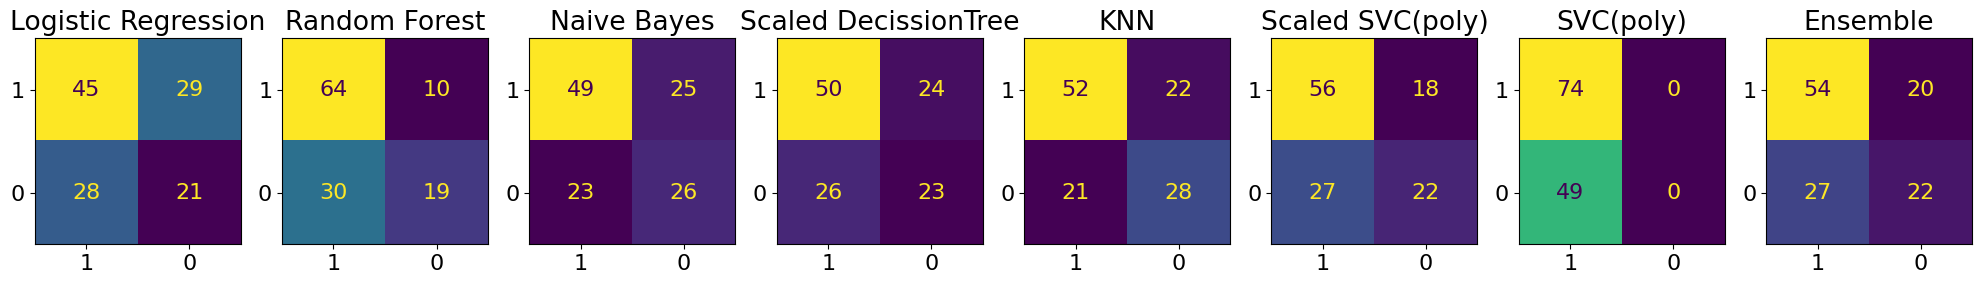

In [20]:
# radial and circ strain per segment and frame 16 x time x 2
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat'])['radial_strain'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
x2 = np.stack(df_merged.sort_values(['pat']).groupby(['pat'])['circ_strain'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
x = np.concatenate([x,x2], axis=1)
print(x.shape)
x = np.nan_to_num(x)
cross_validate_f1(x,y)

(123, 32)
********** Logistic Regression **********
[0.6        0.6        0.73333333 0.85714286 0.73333333]
Balanced accuracy: 0.67 (+/- 0.09) [Logistic Regression]
Sensitivity: 0.70 (+/- 0.10) [Logistic Regression]
Specifity: 0.63 (+/- 0.14) [Logistic Regression]
********** Random Forest **********
[0.66666667 0.73333333 0.86666667 0.78571429 0.86666667]
Balanced accuracy: 0.65 (+/- 0.07) [Random Forest]
Sensitivity: 0.78 (+/- 0.08) [Random Forest]
Specifity: 0.51 (+/- 0.07) [Random Forest]
********** Naive Bayes **********
[0.6        0.66666667 0.86666667 0.71428571 0.86666667]
Balanced accuracy: 0.76 (+/- 0.05) [Naive Bayes]
Sensitivity: 0.74 (+/- 0.11) [Naive Bayes]
Specifity: 0.77 (+/- 0.11) [Naive Bayes]
********** Scaled DecissionTree **********
[0.6        0.6        0.53333333 0.64285714 0.73333333]
Balanced accuracy: 0.57 (+/- 0.06) [Scaled DecissionTree]
Sensitivity: 0.62 (+/- 0.07) [Scaled DecissionTree]
Specifity: 0.51 (+/- 0.10) [Scaled DecissionTree]
********** KNN ***

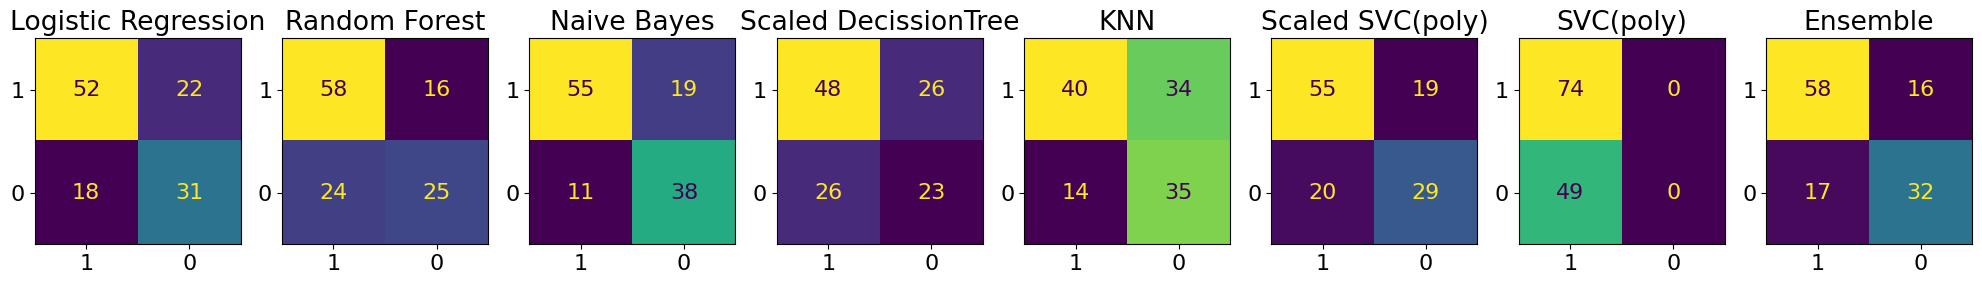

In [17]:
# Peak radial and circ strain per segment 16 x 2
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['radial_strain'].apply(lambda x: max(list(x))).values).astype(np.float32).reshape((y.shape[0],16))
x2 = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['circ_strain'].apply(lambda x: min(list(x))).values).astype(np.float32).reshape((y.shape[0],16))
x = np.concatenate([x,x2], axis=1)
print(x.shape)
x = np.nan_to_num(x)
cross_validate_f1(x,y)

(126, 2)
********** Logistic Regression **********
[0.4        0.86666667 0.46666667 0.66666667 0.86666667]
Balanced accuracy: 0.63 (+/- 0.10) [Logistic Regression]
Sensitivity: 0.65 (+/- 0.20) [Logistic Regression]
Specifity: 0.61 (+/- 0.17) [Logistic Regression]
********** Random Forest **********
[0.53333333 0.8        0.2        0.6        0.66666667]
Balanced accuracy: 0.52 (+/- 0.10) [Random Forest]
Sensitivity: 0.56 (+/- 0.20) [Random Forest]
Specifity: 0.49 (+/- 0.05) [Random Forest]
********** Naive Bayes **********
[0.73333333 0.86666667 0.93333333 0.73333333 1.        ]
Balanced accuracy: 0.54 (+/- 0.02) [Naive Bayes]
Sensitivity: 0.85 (+/- 0.11) [Naive Bayes]
Specifity: 0.23 (+/- 0.11) [Naive Bayes]
********** Scaled DecissionTree **********
[0.33333333 0.46666667 0.4        0.26666667 0.93333333]
Balanced accuracy: 0.43 (+/- 0.17) [Scaled DecissionTree]
Sensitivity: 0.48 (+/- 0.24) [Scaled DecissionTree]
Specifity: 0.37 (+/- 0.15) [Scaled DecissionTree]
********** KNN ****

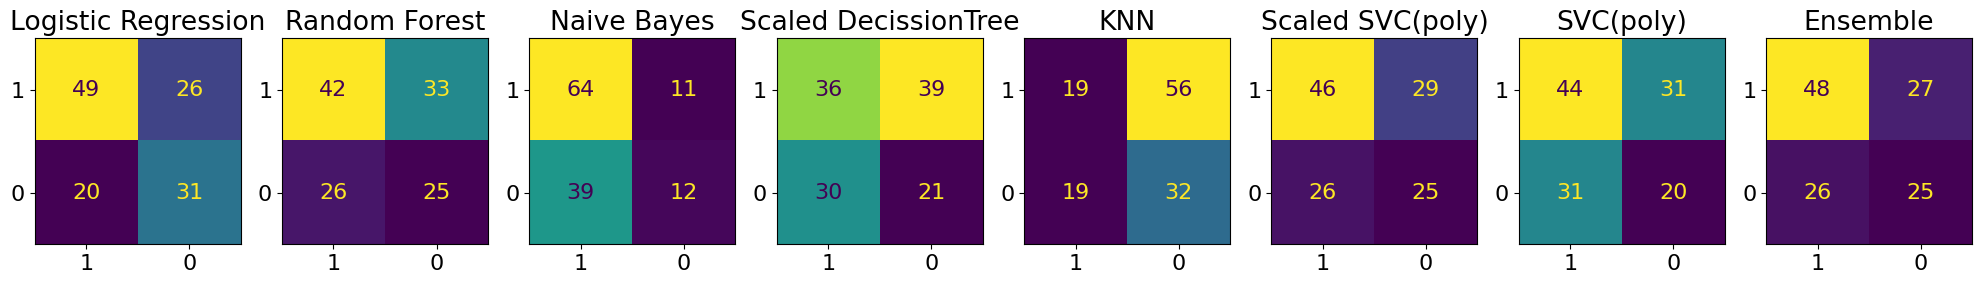

In [18]:
# Peak radial and circ strain per patient
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['radial_strain'].apply(lambda x: np.mean(list(x))).values).astype(np.float32).reshape((y.shape[0],16))
x = np.max(x, axis=1)
x2 = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['circ_strain'].apply(lambda x: np.mean(list(x))).values).astype(np.float32).reshape((y.shape[0],16))
x2 = np.min(x2, axis=1)
x = np.stack([x,x2], axis=1)
print(x.shape)
x = np.nan_to_num(x)
cross_validate_f1(x,y)

(123, 5)
********** Logistic Regression **********
[0. 0. 0. 0. 0.]
Balanced accuracy: 0.50 (+/- 0.00) [Logistic Regression]
Sensitivity: 0.00 (+/- 0.00) [Logistic Regression]
Specifity: 1.00 (+/- 0.00) [Logistic Regression]
********** Random Forest **********
[0. 1. 0. 0. 1.]
Balanced accuracy: 0.50 (+/- 0.00) [Random Forest]
Sensitivity: 0.40 (+/- 0.49) [Random Forest]
Specifity: 0.60 (+/- 0.49) [Random Forest]
********** Naive Bayes **********
[0. 0. 0. 0. 0.]
Balanced accuracy: 0.50 (+/- 0.00) [Naive Bayes]
Sensitivity: 0.00 (+/- 0.00) [Naive Bayes]
Specifity: 1.00 (+/- 0.00) [Naive Bayes]
********** Scaled DecissionTree **********
[0. 0. 0. 1. 1.]
Balanced accuracy: 0.50 (+/- 0.00) [Scaled DecissionTree]
Sensitivity: 0.40 (+/- 0.49) [Scaled DecissionTree]
Specifity: 0.60 (+/- 0.49) [Scaled DecissionTree]
********** KNN **********
[0. 0. 0. 0. 0.]
Balanced accuracy: 0.50 (+/- 0.00) [KNN]
Sensitivity: 0.00 (+/- 0.00) [KNN]
Specifity: 1.00 (+/- 0.00) [KNN]
********** Scaled SVC(poly)

/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/sklearn/naive_bayes.py:489: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/sklearn/naive_bayes.py:490: RuntimeWarning: invalid value encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/sklearn/naive_bayes.py:489: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/sklearn/naive_bayes.py:490: RuntimeWarning: invalid value encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/sklearn/naive_bayes.py:489: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.su

********** Ensemble **********
[0. 0. 0. 0. 0.]
Balanced accuracy: 0.50 (+/- 0.00) [Ensemble]
Sensitivity: 0.00 (+/- 0.00) [Ensemble]
Specifity: 1.00 (+/- 0.00) [Ensemble]


/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/sklearn/naive_bayes.py:489: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/sklearn/naive_bayes.py:490: RuntimeWarning: invalid value encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)


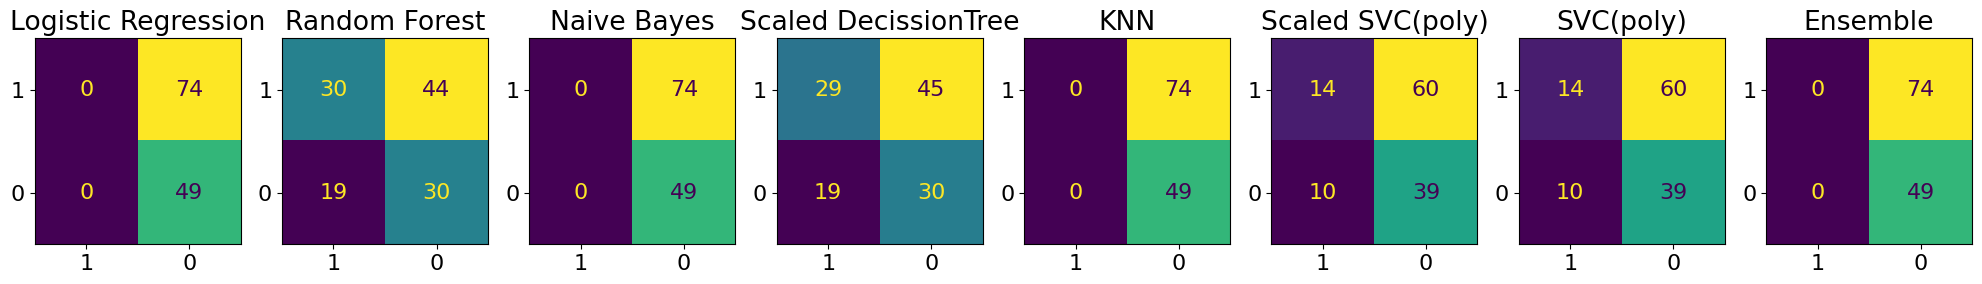

In [32]:
# CS strain at the 4 keyframes
x = np.stack(df_circ_sliced.sort_values(['pat']).groupby(['pat'])[[0,1,2,3,4]].apply(list).values).astype(np.float32)
print(x.shape)
x = np.nan_to_num(x)
cross_validate_f1(x,y)

In [23]:
gs = create_grid_search()
gs = gs.fit(x, y)

# create a df from the gs results
results = pd.DataFrame.from_dict(gs.cv_results_)
results["params_str"] = results.params.apply(str)
pd.set_option('display.max_colwidth', None)
results.shape

KeyboardInterrupt: 

In [23]:
# sort by balanced acc
results.sort_values(by=['rank_test_balanced_accuracy','rank_test_recall','rank_test_f1'])[['mean_test_balanced_accuracy','mean_test_spec','mean_test_sens','mean_test_roc_auc', 'params_str']].head(5)

NameError: name 'results' is not defined

In [ ]:
# sort by spec
results.sort_values(by=['rank_test_spec','rank_test_balanced_accuracy','rank_test_recall'])[['mean_test_balanced_accuracy','mean_test_spec','mean_test_sens','mean_test_roc_auc', 'params_str']].head(5)

In [ ]:
# sort by f1
results.sort_values(by=['rank_test_f1','rank_test_balanced_accuracy','rank_test_recall'])[['mean_test_balanced_accuracy','mean_test_spec','mean_test_sens','mean_test_roc_auc', 'params_str']].head(5)

## Evaluate best estimators from gridsearch CV

**Recall** in this context is also referred to as the true positive rate or sensitivity, and 

$\frac{tp}{tp+fn}$ 



**Precision** is also referred to as positive predictive value (PPV); other related measures used in classification include true negative rate and accuracy. True negative rate is also called specificity.

$\frac{tp}{tp+fp)}$



**Accuracy** (maybe missleading for imbalanced data.)

$\frac{tp+tn}{tp+tn+fp+fn}$



Specifity: 0.34 (+/- 0.12)
Sensitivity: 0.94 (+/- 0.08)
params: {'clf': SVC(C=5, gamma=0.001, kernel='poly'), 'clf__C': 5, 'clf__class_weight': None, 'clf__gamma': 0.001, 'clf__kernel': 'poly', 'scaler': None}
Recall: 0.94 (+/- 0.08)
Accuracy: 0.68 (+/- 0.10)
Precision: 0.66 (+/- 0.08)
Balanced Accuracy: 0.64 (+/- 0.10)
F1: 0.77 (+/- 0.08)
AUC: 0.64 (+/- 0.10)


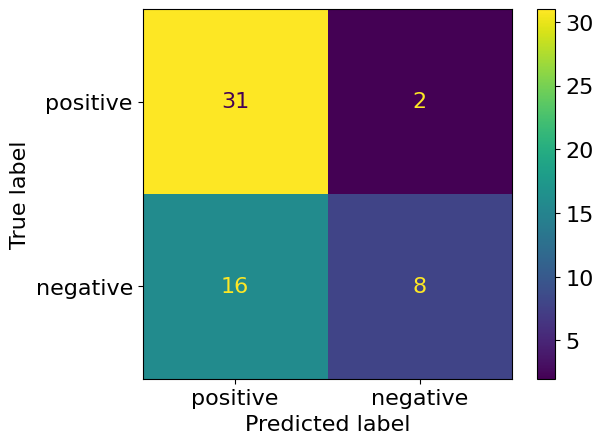

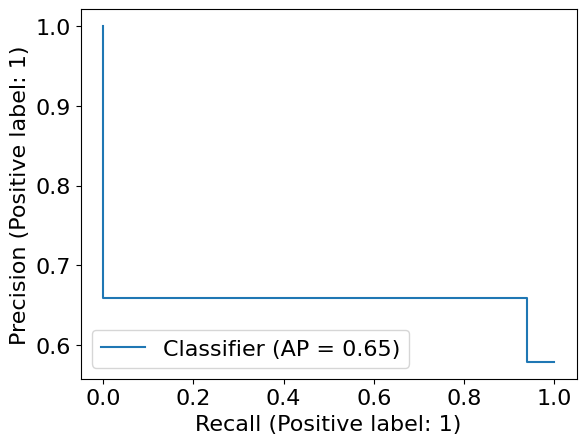

In [31]:
# use the parameters of the best classifier from the gridsearch and refit on data in CV manner 
hits, y_pred = plot_report(gs.best_estimator_, x, y, label=gs.best_params_, df_strain_comp=df_strain_comp)
plt.show()

(123, 16)
********** Logistic Regression **********
[0.46666667 0.66666667 0.8        0.64285714 0.8       ]
Balanced accuracy: 0.62 (+/- 0.08) [Logistic Regression]
Sensitivity: 0.68 (+/- 0.12) [Logistic Regression]
Specifity: 0.57 (+/- 0.13) [Logistic Regression]
********** Random Forest **********
[0.73333333 0.66666667 0.8        0.85714286 0.86666667]
Balanced accuracy: 0.63 (+/- 0.07) [Random Forest]
Sensitivity: 0.78 (+/- 0.08) [Random Forest]
Specifity: 0.47 (+/- 0.12) [Random Forest]
********** Naive Bayes **********
[0.46666667 0.66666667 0.73333333 0.71428571 0.86666667]
Balanced accuracy: 0.71 (+/- 0.09) [Naive Bayes]
Sensitivity: 0.69 (+/- 0.13) [Naive Bayes]
Specifity: 0.73 (+/- 0.13) [Naive Bayes]
********** Scaled DecissionTree **********
[0.66666667 0.53333333 0.66666667 0.78571429 0.86666667]
Balanced accuracy: 0.66 (+/- 0.08) [Scaled DecissionTree]
Sensitivity: 0.70 (+/- 0.11) [Scaled DecissionTree]
Specifity: 0.61 (+/- 0.15) [Scaled DecissionTree]
********** KNN ***

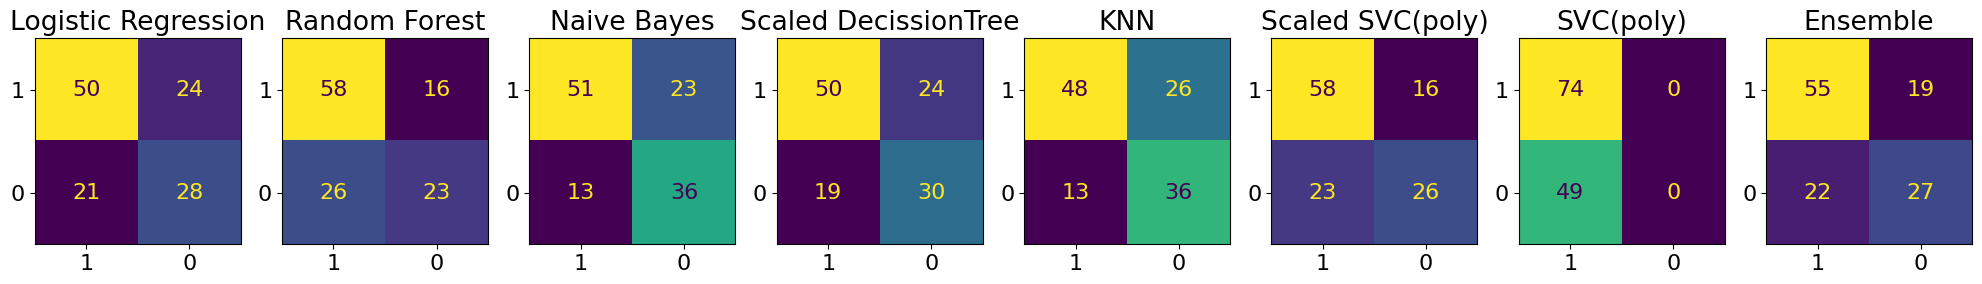

In [22]:
# Peak radial strain per patient or sliced phase strain
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['circ_strain'].apply(lambda x: np.min(list(x))).values).astype(np.float32).reshape((y.shape[0],16))
#x = np.max(x, axis=1)[:,None]
print(x.shape)
x = np.nan_to_num(x)
cross_validate_f1(x,y)

(57, 2)
********** Logistic Regression **********
[0.71428571 0.42857143 0.5        0.66666667 0.57142857]
F1: 0.58 (+/- 0.09) [Logistic Regression]
Recall: 0.58 (+/- 0.10) [Logistic Regression]
Accuracy: 0.52 (+/- 0.10) [Logistic Regression]
********** Random Forest **********
[0.71428571 0.42857143 0.5        0.66666667 0.85714286]
F1: 0.59 (+/- 0.09) [Random Forest]
Recall: 0.63 (+/- 0.15) [Random Forest]
Accuracy: 0.48 (+/- 0.11) [Random Forest]
********** naive Bayes **********
[1.         0.71428571 1.         0.66666667 0.71428571]
F1: 0.68 (+/- 0.06) [naive Bayes]
Recall: 0.82 (+/- 0.15) [naive Bayes]
Accuracy: 0.51 (+/- 0.06) [naive Bayes]
********** scaled DecissionTree **********
[0.57142857 0.28571429 0.5        0.66666667 0.71428571]
F1: 0.56 (+/- 0.11) [scaled DecissionTree]
Recall: 0.55 (+/- 0.15) [scaled DecissionTree]
Accuracy: 0.52 (+/- 0.05) [scaled DecissionTree]
********** KNN **********
[0.57142857 0.28571429 0.         0.66666667 0.14285714]
F1: 0.39 (+/- 0.25) [

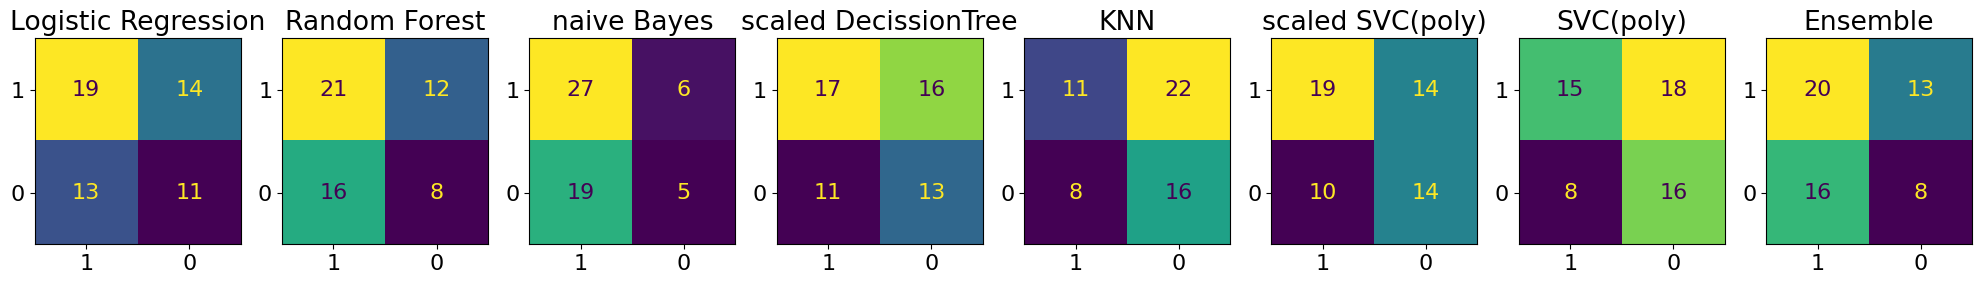

In [24]:
# Peak radial and circ strain per patient
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['radial_strain'].apply(lambda x: np.mean(list(x))).values).astype(np.float32).reshape((57,16))
x = np.max(x, axis=1)
x2 = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['circ_strain'].apply(lambda x: np.mean(list(x))).values).astype(np.float32).reshape((57,16))
x2 = np.min(x2, axis=1)
x = np.stack([x,x2], axis=1)
print(x.shape)
x = np.nan_to_num(x)
cross_validate_f1(x,y)

In [130]:
# Peak radial strain per segment
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['radial_strain'].apply(lambda x: max(list(x))).values).astype(np.float32).reshape((57,16))
print(x.shape)
x = np.nan_to_num(x)


(57, 16)


(57, 32)
********** Logistic Regression **********
[0.42857143 0.71428571 1.         0.33333333 1.        ]
F1: 0.70 (+/- 0.24) [Logistic Regression]
Recall: 0.70 (+/- 0.28) [Logistic Regression]
Accuracy: 0.68 (+/- 0.24) [Logistic Regression]
********** Random Forest **********
[0.71428571 0.71428571 0.5        0.5        0.71428571]
F1: 0.62 (+/- 0.12) [Random Forest]
Recall: 0.63 (+/- 0.10) [Random Forest]
Accuracy: 0.53 (+/- 0.17) [Random Forest]
********** naive Bayes **********
[0.57142857 0.71428571 0.5        0.66666667 0.71428571]
F1: 0.66 (+/- 0.08) [naive Bayes]
Recall: 0.63 (+/- 0.08) [naive Bayes]
Accuracy: 0.61 (+/- 0.12) [naive Bayes]
********** scaled DecissionTree **********
[0.57142857 0.42857143 0.33333333 0.5        0.57142857]
F1: 0.51 (+/- 0.10) [scaled DecissionTree]
Recall: 0.48 (+/- 0.09) [scaled DecissionTree]
Accuracy: 0.48 (+/- 0.11) [scaled DecissionTree]
********** KNN **********
[0.42857143 0.85714286 0.66666667 0.66666667 0.71428571]
F1: 0.73 (+/- 0.14) 

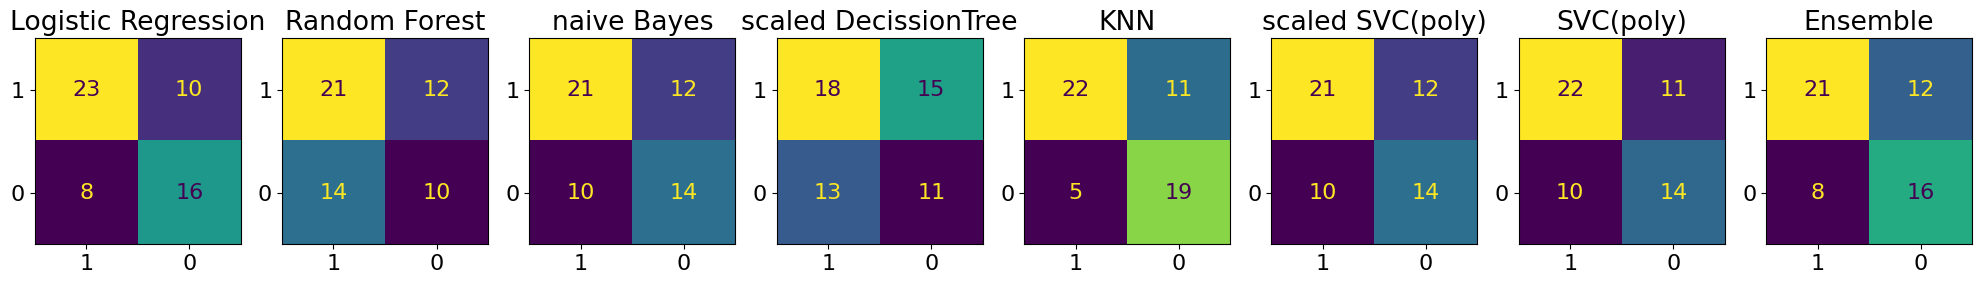

In [61]:
# Peak radial and circ strain per segment
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['radial_strain'].apply(lambda x: max(list(x))).values).astype(np.float32).reshape((57,16))
x2 = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['circ_strain'].apply(lambda x: min(list(x))).values).astype(np.float32).reshape((57,16))
x = np.concatenate([x,x2], axis=1)
print(x.shape)
x = np.nan_to_num(x)
cross_validate_f1(x,y)

In [106]:
# radial strain per segment and frame 16 x 30
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat'])['radial_strain'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
print(x.shape)
x = np.nan_to_num(x)

(57, 480)


(57, 160)
********** Logistic Regression **********
[0.42857143 0.14285714 0.5        0.83333333 0.57142857]
F1: 0.47 (+/- 0.14) [Logistic Regression]
Recall: 0.50 (+/- 0.22) [Logistic Regression]
Accuracy: 0.41 (+/- 0.10) [Logistic Regression]
********** Random Forest **********
[0.57142857 0.85714286 1.         0.83333333 0.71428571]
F1: 0.69 (+/- 0.11) [Random Forest]
Recall: 0.80 (+/- 0.14) [Random Forest]
Accuracy: 0.54 (+/- 0.16) [Random Forest]
********** naive Bayes **********
[0.28571429 0.71428571 0.5        0.66666667 0.57142857]
F1: 0.55 (+/- 0.15) [naive Bayes]
Recall: 0.55 (+/- 0.15) [naive Bayes]
Accuracy: 0.49 (+/- 0.19) [naive Bayes]
********** scaled DecissionTree **********
[0.57142857 0.71428571 0.5        0.5        0.57142857]
F1: 0.58 (+/- 0.09) [scaled DecissionTree]
Recall: 0.57 (+/- 0.08) [scaled DecissionTree]
Accuracy: 0.52 (+/- 0.11) [scaled DecissionTree]
********** KNN **********
[0.42857143 0.42857143 0.66666667 0.5        0.57142857]
F1: 0.55 (+/- 0.08)

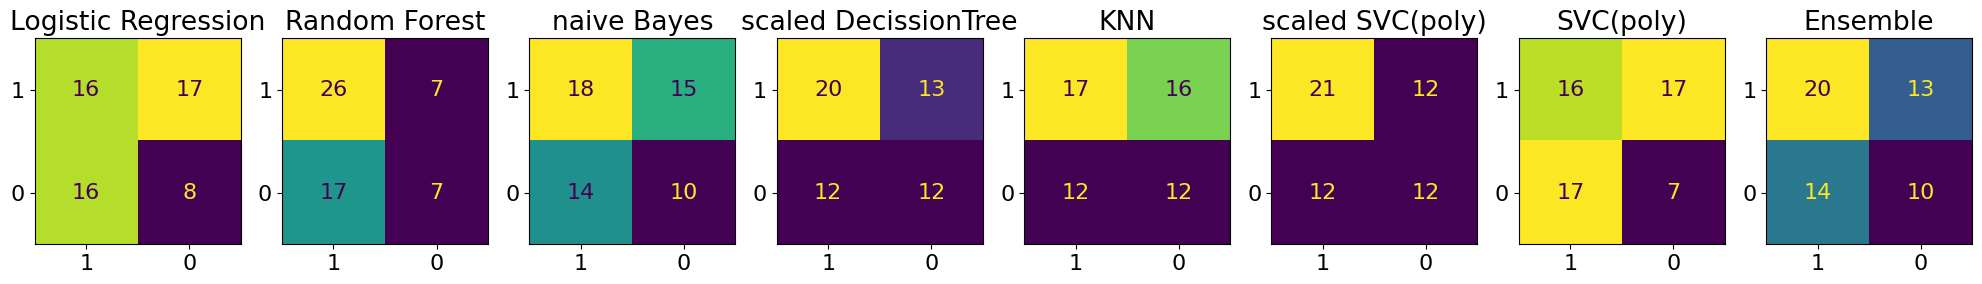

In [62]:
# radial and circ strain per segment and frame 16 x time x 2
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat'])['radial_strain'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
x2 = np.stack(df_merged.sort_values(['pat']).groupby(['pat'])['circ_strain'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
x = np.concatenate([x,x2], axis=1)
print(x.shape)
x = np.nan_to_num(x)
cross_validate_f1(x,y)

********** Logistic Regression **********
[0.42857143 0.57142857 0.83333333 0.66666667 0.57142857]
F1: 0.62 (+/- 0.10) [Logistic Regression]
Recall: 0.61 (+/- 0.13) [Logistic Regression]
Accuracy: 0.56 (+/- 0.11) [Logistic Regression]
********** Random Forest **********
[0.57142857 0.42857143 0.66666667 0.66666667 0.71428571]
F1: 0.61 (+/- 0.10) [Random Forest]
Recall: 0.61 (+/- 0.10) [Random Forest]
Accuracy: 0.54 (+/- 0.12) [Random Forest]
********** naive Bayes **********
[1.         0.71428571 1.         0.66666667 0.85714286]
F1: 0.67 (+/- 0.06) [naive Bayes]
Recall: 0.85 (+/- 0.14) [naive Bayes]
Accuracy: 0.46 (+/- 0.03) [naive Bayes]
********** scaled DecissionTree **********
[0.57142857 0.57142857 0.5        0.33333333 0.28571429]
F1: 0.50 (+/- 0.13) [scaled DecissionTree]
Recall: 0.45 (+/- 0.12) [scaled DecissionTree]
Accuracy: 0.49 (+/- 0.14) [scaled DecissionTree]
********** KNN **********
[0.57142857 0.42857143 0.33333333 0.33333333 0.28571429]
F1: 0.49 (+/- 0.09) [KNN]
Rec

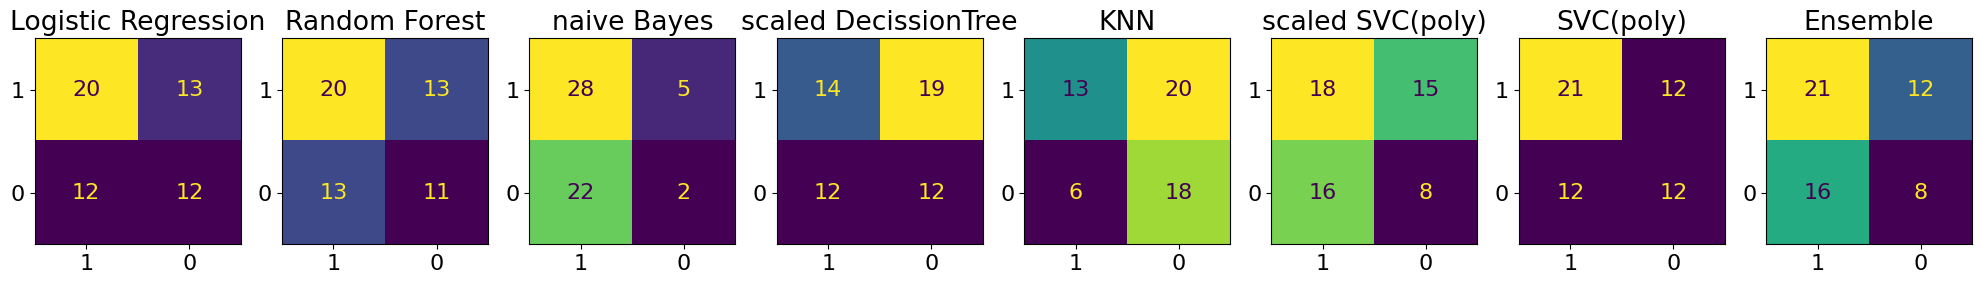

In [246]:
cross_validate_f1(x,y)